In [1]:
import tutorenvs
from tutorenvs.utils import DataShopLogger
from tutorenvs.multicolumn_std import MultiColumnAddition
from tutorenvs.trainer import AuthorTrainer

In [2]:
edge_case_set = [
    ["777", "777"],
    ["773", "773"],
    ["737", "737"],
    ["377", "377"],
    ["337", "337"],
    ["733", "733"], # missing in CHI2020
    ["333", "333"], # missing in CHI2020
    ["999", "001"],
    ["999", "010"],
    ["999", "100"],
    ["999", "111"],
    ["999", "011"],
    ["999", "110"],
    ["999", "101"],
]

training_set = [
    ["534", "698"],
    ["872", "371"],
    ["839", "445"],
    ["287", "134"],
    ["643", "534"],
    ["248", "137"],
    ["234", "142"],
    ["539", "461"],
    ["433", "576"],
    ["764", "335"],
    ["533", "698"],
]

extra = [
    # ["777", "777"],
    # ["999", "101"],
    # ["999", "111"],
    # ["999", "001"],
]

In [3]:
def log_completeness(agent, profile='ground_truth.txt', log=[]):
    completeness = agent.eval_completeness(profile)
    print("CMPLEETNESS", completeness)
    log.append(completeness)


def run_training(agent, logger_name='MulticolumnAddition', n=100,
                 n_columns=3, author_train=True, carry_zero=False, fixed_train_set=False):
    logger = DataShopLogger(logger_name, extra_kcs=['field'])
    problem_set = training_set + extra + training_set   #[["777", "777"], ["666", "666"], ["777","777"]]

    env = MultiColumnAddition(check_how=False, check_args=True,
            demo_args=True, demo_how=False, n_digits=n_columns,
            carry_zero=carry_zero)

    # make_completeness_profile(env, training_set+edge_case_set, 'exp_z_ground_truth.txt')
    kwargs = dict(problem_set=problem_set) if fixed_train_set else dict(n_problems=n)
    trainer = AuthorTrainer(agent, env, logger=logger,
                **kwargs)#, n_problems=n)
    c_log = []
    profile = "exp_z_ground_truth.txt" if carry_zero else "ground_truth.txt"
    trainer.on_problem_end = lambda : log_completeness(agent, profile, log=c_log)

    # else:
    #     env = MultiColumnAddition(check_how=False, check_args=False, demo_args=True, demo_how=True, n_digits=n_columns)
    #     trainer = Trainer(agent, env, logger=logger, problem_set=problem_set, n_problems=n)
    trainer.start()
    for i, obj in enumerate(c_log):
        print(f"corr={obj['correctness']*100:2.2f}%, compl={obj['completeness']*100:.2f}%")
    return c_log
    
def train_active_learning(agent, logger_name='MulticolumnAddition', n=100,
                 n_columns=3, carry_zero=False, fixed_train_set=False):
    logger = DataShopLogger(logger_name, extra_kcs=['field'])
    env = MultiColumnAddition(check_how=False, check_args=True,
            demo_args=True, demo_how=True, n_digits=n_columns,
            carry_zero=carry_zero)
    
    rand_problems = []
    for i in range(100):
        prob_config = env.set_random_problem()
        rand_problems.append(prob_config)
        
    p = rand_problems[0]
    
    c_log = []
    for i in range(100):
        profile = "exp_z_ground_truth.txt" if carry_zero else "ground_truth.txt"
        trainer = AuthorTrainer(agent, env, logger=logger, problem_set=[p])#, n_problems=n)
        trainer.on_problem_end = lambda : log_completeness(agent, profile, log=c_log)
        trainer.start()
        
        certainties = []
        for _p in rand_problems:
            
            env.set_problem(*_p)
            out = agent.act_rollout(env.get_state())
            print(f"CERTAINTY {_p}", out['avg_certainty'])
            certainties.append(out['avg_certainty'])
            
        import numpy as np
        p = rand_problems[np.argmin(certainties)]
    return c_log
            

In [10]:
from apprentice.agents.cre_agents.cre_agent import CREAgent
agent_args = {
    "search_depth" : 2,
    "where_learner": "antiunify",
    #"where_learner": "mostspecific",
    # "when_learner": "sklearndecisiontree",    
    "explanation_choice" : "least_operations",
    
    "planner" : "setchaining",
    "function_set" : ["OnesDigit","TensDigit","Add","Add3"],
    "feature_set" : [],
    #"feature_set" : ['Equals'],
    
    "extra_features" : ["SkillCandidates","Match"],
    "find_neighbors" : True,
    "when_args": {"encode_relative" : True, "one_hot" : True, "check_sanity" : False},
}

dt_args = {
    "when_learner": "decisiontree",
}
stand_args = {
    "when_learner": "stand",
    "which_learner": "when_prediction",
    "action_chooser" : "max_which_utility",
    "suggest_uncert_neg" : True,
}

stand_relaxed_args = {**stand_args,
    "when_args" : {
        **agent_args['when_args'],
        "split_choice" : "all_near_max"
    }
}

import numpy as np
import matplotlib.pyplot as plt

markers = ['+', '.', 'o']
def plot_cmp(d, title):
    for i, (label, prof) in enumerate(d.items()):
        if(isinstance(prof[0],dict)):
            cmp = [d['completeness'] for d in prof]
        else:
            cmp = prof
        plt.plot(np.arange(1,len(cmp)+1), cmp, label=label)#, marker=markers[i])
    plt.title(title)
    plt.xlabel('Problem #')
    plt.ylabel('Post-Problem Completeness')
    plt.legend(loc="lower right")
    plt.ylim(-0.05, 1.05)
    plt.axhline(1.0, linestyle='--', color="#dddddd99")
    plt.show()



In [5]:
log_stand_active = np.zeros(100)
for i in range(5):
    agent = CREAgent(**agent_args, **stand_args)
    log_stand_active += np.array([x['completeness'] for x in train_active_learning(agent)])
log_stand_active /= 5

STARTING PROBLEM 515_373
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(a.value) + f8(b.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(b.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + TensDigit(f8(a.value)) + (f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + TensDigit(f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + TensDigit(f8(a.value)))
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + (f8(b.value) + f8(a.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)) + (f8(a.value

/home/danny/.local/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


	_declare_skill_cands: 712.735107 ms
WILL LEARN False 0.0
fit option_tree: 35.85 ms
fit_spec_ext: 7.26 ms
HINT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
WILL LEARN True 31.0
fit option_tree: 0.15 ms
fit_spec_ext: 0.01 ms
HINT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 16.0
fit option_tree: 0.18 ms
fit_spec_ext: 0.01 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
EXPLAIN DEMO!
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_9QXdu(-1) -1
	_declare_skill_const: 489.282959 ms
WILL LEARN False 0.0
fit option_tree: 0.07 ms
fit_spec_ext: 0.01 ms
HINT:

	_declare_skill_cands: 738.895752 ms
WILL LEARN False 0.0
fit option_tree: 0.08 ms
fit_spec_ext: 0.01 ms
EXPLAIN DEMO!
foci_match True ['carry2', 'inpA3', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(f8(a.value) + TensDigit(f8(b.value)) + TensDigit(f8(c.value)))
foci_match False ['carry2', 'inpB3', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(f8(a.value) + TensDigit(f8(b.value)) + TensDigit(f8(c.value)))
foci_match True ['carry2', 'inpA3', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_pVKDk(TensDigit(a + b + c)) s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
NumericalToStr(TensDigit(Add3(CastFloat(a.value), CastFloat(b.value), CastFloat(c.value))))
------------------v-------------------
A

CERTAINTY ('724', '605') 0.468521831025798
CERTAINTY ('941', '883') 0.47186692910272726
CERTAINTY ('297', '477') 0.47186692910272726
CERTAINTY ('842', '165') 0.4681163160217428
CERTAINTY ('825', '376') 0.5255793872899553
CERTAINTY ('594', '720') 0.4720696866047549
CERTAINTY ('443', '614') 0.5093326553378917
STARTING PROBLEM 694_810
WILL LEARN True 18.0
fit option_tree: 1.07 ms
fit_spec_ext: 0.03 ms
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 144.75
fit option_tree: 1.18 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 1.50 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 1.09 ms
fit_spec_ext: 0.07 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 14.0
fit option_tree: 0.23 ms
fit_spec_ext: 0.01 ms
EXPLAIN DEMO!
foci_match False ['inpB2'

CERTAINTY ('469', '193') 0.8838236295012007
CERTAINTY ('835', '138') 0.9232293227585813
CERTAINTY ('945', '172') 0.902512109195053
CERTAINTY ('858', '498') 0.9161683867573427
CERTAINTY ('992', '966') 0.9235361808422891
CERTAINTY ('185', '548') 0.8852423004178434
CERTAINTY ('145', '737') 0.9268707793412142
CERTAINTY ('692', '598') 0.8993430969687332
CERTAINTY ('392', '113') 0.8900487746433674
CERTAINTY ('403', '631') 0.9575688170439928
CERTAINTY ('549', '685') 0.8922683174244644
CERTAINTY ('524', '229') 0.9221683148010217
CERTAINTY ('523', '686') 0.8950617003673993
CERTAINTY ('251', '688') 0.9318658487519013
CERTAINTY ('351', '374') 0.8904261331339335
CERTAINTY ('361', '488') 0.8861905762799122
CERTAINTY ('818', '692') 0.9002519316724349
CERTAINTY ('764', '982') 0.9214633931141016
CERTAINTY ('150', '103') 0.9294512279662878
CERTAINTY ('759', '459') 0.9279339480602021
CERTAINTY ('279', '866') 0.9198274788577249
CERTAINTY ('881', '385') 0.8980236069996882
CERTAINTY ('296', '367') 0.891872

Correctness : 59.78%
Completeness : 10.87%
return_diffs False
CMPLEETNESS {'completeness': 0.10869565217391304, 'correctness': 0.5978260869565217}
TOTALS  (correct:4, incorrect:11, hint:6, assistance:17)
PERCENTS(correct:19.05%, incorrect:52.38%, hint:28.57%, assistance:80.95%)
CERTAINTY ('515', '373') 0.8948569843224675
CERTAINTY ('733', '492') 0.7793726628088028
CERTAINTY ('837', '980') 0.8701788923962893
CERTAINTY ('309', '394') 0.899047996563003
CERTAINTY ('629', '899') 0.8410751698683914
CERTAINTY ('605', '199') 0.899792317718217
CERTAINTY ('340', '104') 0.87089707677943
CERTAINTY ('657', '537') 0.8787391026408465
CERTAINTY ('181', '762') 0.8472993492767549
CERTAINTY ('594', '201') 0.8190452101891376
CERTAINTY ('372', '483') 0.44545788331817054
CERTAINTY ('434', '892') 0.8474556223915259
CERTAINTY ('532', '907') 0.8737309517339973
CERTAINTY ('249', '189') 0.6269503884672188
CERTAINTY ('492', '146') 0.9022367811099831
CERTAINTY ('840', '246') 0.8623894871249326
CERTAINTY ('447', '1

CERTAINTY ('375', '218') 0.6812592754010461
CERTAINTY ('413', '308') 0.7109495059964257
CERTAINTY ('993', '314') 0.7331319746762662
CERTAINTY ('911', '604') 0.6104596118836968
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 0.9167770319303337
CERTAINTY ('241', '786') 0.7438266857510624
CERTAINTY ('605', '274') 0.9162010159651669
CERTAINTY ('694', '810') 0.9441145850913018
CERTAINTY ('272', '340') 0.7405239005038776
CERTAINTY ('856', '748') 0.6510757036384267
CERTAINTY ('987', '696') 0.6764399406287719
CERTAINTY ('276', '431') 0.664891429158081
CERTAINTY ('134', '311') 0.503011736200725
CERTAINTY ('862', '745') 0.6907407362341232
CERTAINTY ('685', '621') 0.7319436104462552
CERTAINTY ('151', '931') 0.9178156748911466
CERTAINTY ('632', '307') 0.739707743495468
CERTAINTY ('441', '604') 0.9037252056119981
CERTAINTY ('654', '905') 0.5942978068375113
CERTAINTY ('782', '987') 0.7290075942271793
CERTAINTY ('450', '291') 0.9189949201741656
CERTAINTY ('327', '286') 0.7383248164931177
CERTAI

CERTAINTY ('523', '686') 0.5957261952779056
CERTAINTY ('251', '688') 0.813820906109737
CERTAINTY ('351', '374') 0.7285323532814846
CERTAINTY ('361', '488') 0.5543971076133759
CERTAINTY ('818', '692') 0.6623816541769767
CERTAINTY ('764', '982') 0.5295861374576984
CERTAINTY ('150', '103') 0.5735482288927422
CERTAINTY ('759', '459') 0.7410815709794671
CERTAINTY ('279', '866') 0.8642397669444142
CERTAINTY ('881', '385') 0.6549537661409993
CERTAINTY ('296', '367') 0.6320636545374485
CERTAINTY ('102', '890') 0.785601063184291
CERTAINTY ('150', '913') 0.6175151783112575
CERTAINTY ('991', '215') 0.531954272166159
CERTAINTY ('186', '131') 0.5337482151838081
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 0.9516311175359103
CERTAINTY ('213', '396') 0.5252059412442825
CERTAINTY ('551', '417') 0.4612088909743246
CERTAINTY ('498', '796') 0.8121048734335384
CERTAINTY ('775', '628') 0.6652243188178281
CERTAINTY ('572', '587') 0.7022782912386037
CERTAINTY ('962', '308') 0.8104273982165028
CERTAI

CERTAINTY ('724', '605') 0.8710050249130418
CERTAINTY ('941', '883') 0.8709218434551648
CERTAINTY ('297', '477') 0.9546875920269977
CERTAINTY ('842', '165') 0.9015246027495146
CERTAINTY ('825', '376') 0.9226737246092089
CERTAINTY ('594', '720') 0.8233747753739747
CERTAINTY ('443', '614') 0.9062372468381448
STARTING PROBLEM 764_982
WILL LEARN True 56.0
fit option_tree: 3.17 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 31.0
fit option_tree: 4.39 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '6'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 190.5
fit option_tree: 3.09 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 13701.705479452054
fit option_tree: 3.56 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 4.0
fit option_tree: 3.70 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 54.0
fit option_tree: 4.03 ms
fit_spec_ext: 0.10 ms
CORRECT: carry2 -> {'value': '1'}
INCORRECT: out3 -

Correctness : 52.17%
Completeness : 34.78%
return_diffs False
CMPLEETNESS {'completeness': 0.34782608695652173, 'correctness': 0.5217391304347826}
TOTALS  (correct:6, incorrect:6, hint:2, assistance:8)
PERCENTS(correct:42.86%, incorrect:42.86%, hint:14.29%, assistance:57.14%)
CERTAINTY ('515', '373') 0.8000088048607259
CERTAINTY ('733', '492') 0.9864435232648447
CERTAINTY ('837', '980') 0.9707119953814266
CERTAINTY ('309', '394') 0.7898311214002701
CERTAINTY ('629', '899') 0.9566910718477795
CERTAINTY ('605', '199') 0.939622689541025
CERTAINTY ('340', '104') 0.6900797856834284
CERTAINTY ('657', '537') 0.6527236668331204
CERTAINTY ('181', '762') 0.9062501973990017
CERTAINTY ('594', '201') 0.6105869321588904
CERTAINTY ('372', '483') 0.6195048627748865
CERTAINTY ('434', '892') 0.7790382418044866
CERTAINTY ('532', '907') 0.9823706968608535
CERTAINTY ('249', '189') 0.636483379325739
CERTAINTY ('492', '146') 0.5103989957927568
CERTAINTY ('840', '246') 0.6507575083287476
CERTAINTY ('447', '19

CERTAINTY ('993', '314') 0.9071040958683663
CERTAINTY ('911', '604') 0.8394623794890063
CERTAINTY ('244', '311') 0.9931913392343926
CERTAINTY ('992', '928') 0.9535352984862016
CERTAINTY ('241', '786') 0.945285161382394
CERTAINTY ('605', '274') 0.9779819783335022
CERTAINTY ('694', '810') 0.8126847673600092
CERTAINTY ('272', '340') 0.8946592348931794
CERTAINTY ('856', '748') 0.8543670035012745
CERTAINTY ('987', '696') 0.6425190226976006
CERTAINTY ('276', '431') 0.9397572431612193
CERTAINTY ('134', '311') 0.7879778115262168
CERTAINTY ('862', '745') 0.835821835728345
CERTAINTY ('685', '621') 0.8793009623700919
CERTAINTY ('151', '931') 0.8580516153491974
CERTAINTY ('632', '307') 0.9100077981393362
CERTAINTY ('441', '604') 0.9130549901197421
CERTAINTY ('654', '905') 0.7759129319231295
CERTAINTY ('782', '987') 0.8837991426043733
CERTAINTY ('450', '291') 0.9351744878578692
CERTAINTY ('327', '286') 0.9092786720647963
CERTAINTY ('762', '315') 0.8983276740438955
CERTAINTY ('869', '390') 0.6695908

CERTAINTY ('862', '745') 0.6379254815746782
CERTAINTY ('685', '621') 0.6431311386488446
CERTAINTY ('151', '931') 0.5122670207566965
CERTAINTY ('632', '307') 0.9121180103303713
CERTAINTY ('441', '604') 0.6865706355216896
CERTAINTY ('654', '905') 0.5193754164281396
CERTAINTY ('782', '987') 0.6975142488891553
CERTAINTY ('450', '291') 0.6940768811796444
CERTAINTY ('327', '286') 0.9387067402752804
CERTAINTY ('762', '315') 0.9742528077778043
CERTAINTY ('869', '390') 0.5252269347710928
CERTAINTY ('952', '413') 0.8849925389767799
CERTAINTY ('496', '135') 0.804439882418906
CERTAINTY ('396', '275') 0.9088273958445507
CERTAINTY ('773', '157') 0.6401961185596667
CERTAINTY ('469', '193') 0.9988412151078083
CERTAINTY ('835', '138') 0.7578424216268181
CERTAINTY ('945', '172') 0.7456075184010332
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 0.9833707017747066
CERTAINTY ('185', '548') 0.9232576401294059
CERTAINTY ('145', '737') 0.7347977264244936
CERTAINTY ('692', '598') 0.978916482757555
CERTA

CERTAINTY ('783', '393') 0.6026374873421214
CERTAINTY ('214', '168') 0.743201168798591
CERTAINTY ('702', '848') 0.7869833011924497
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 0.9657128317399238
CERTAINTY ('429', '574') 0.9717737134077193
CERTAINTY ('951', '801') 0.7663423302222173
CERTAINTY ('957', '340') 0.7177007205609308
CERTAINTY ('724', '605') 0.7830580435374846
CERTAINTY ('941', '883') 0.7277051581923828
CERTAINTY ('297', '477') 0.9114140562389954
CERTAINTY ('842', '165') 0.7767688443850881
CERTAINTY ('825', '376') 0.9420191322953108
CERTAINTY ('594', '720') 0.9836091239008763
CERTAINTY ('443', '614') 0.6888995790384694
STARTING PROBLEM 151_931
WILL LEARN True 6.0
fit option_tree: 5.14 ms
fit_spec_ext: 0.12 ms
WILL LEARN True 100.0
fit option_tree: 6.06 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 16569.777777777777
fit option_tree: 13.89 ms
fit_spec_ext: 0.23 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: out1 

WILL LEARN False 0.0
fit option_tree: 6.20 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 89.13%
Completeness : 65.22%
return_diffs False
CMPLEETNESS {'completeness': 0.6521739130434783, 'correctness': 0.8913043478260869}
TOTALS  (correct:8, incorrect:2, hint:0, assistance:2)
PERCENTS(correct:80.00%, incorrect:20.00%, hint:0.00%, assistance:20.00%)
CERTAINTY ('515', '373') 0.9953216374269006
CERTAINTY ('733', '492') 0.8432435314104078
CERTAINTY ('837', '980') 0.9325364200099128
CERTAINTY ('309', '394') 0.9766551007868491
CERTAINTY ('629', '899') 0.9830116357732163
CERTAINTY ('605', '199') 0.9412072961393092
CERTAINTY ('340', '104') 0.9924090529353687
CERTAINTY ('657', '537') 0.7963348567638129
CERTAINTY ('181', '762') 0.7333878335244088
CERTAINTY ('594', '201') 0.5723227549529945
CERTAINTY ('372', '483') 0.982

CERTAINTY ('492', '146') 0.8342919757366577
CERTAINTY ('840', '246') 0.9213085591342025
CERTAINTY ('447', '192') 0.8037337841176093
CERTAINTY ('811', '325') 0.9191809285561715
CERTAINTY ('638', '859') 0.9277464479217304
CERTAINTY ('375', '218') 0.8953137217301129
CERTAINTY ('413', '308') 0.9155827066038357
CERTAINTY ('993', '314') 0.9145819630482422
CERTAINTY ('911', '604') 0.9879493234605925
CERTAINTY ('244', '311') 0.9971419168830797
CERTAINTY ('992', '928') 0.9783500554180953
CERTAINTY ('241', '786') 0.9847143031155019
CERTAINTY ('605', '274') 0.9885010240655403
CERTAINTY ('694', '810') 0.9982750896057349
CERTAINTY ('272', '340') 0.7957915902595435
CERTAINTY ('856', '748') 0.9820205084995084
CERTAINTY ('987', '696') 0.9791000232506561
CERTAINTY ('276', '431') 0.9915958492646372
CERTAINTY ('134', '311') 0.7668427214985324
CERTAINTY ('862', '745') 0.9209564879799383
CERTAINTY ('685', '621') 0.9225753723907015
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 0.9882827700972863
CER

CERTAINTY ('213', '396') 0.8959830696615353
CERTAINTY ('551', '417') 0.9916347511269066
CERTAINTY ('498', '796') 0.9850096987342131
CERTAINTY ('775', '628') 0.9774895876248391
CERTAINTY ('572', '587') 0.9855640524443378
CERTAINTY ('962', '308') 0.9343078479023564
CERTAINTY ('413', '522') 0.807735963193398
CERTAINTY ('783', '406') 0.979735518488132
CERTAINTY ('783', '393') 0.9839753287960114
CERTAINTY ('214', '168') 0.9258246664280075
CERTAINTY ('702', '848') 0.932030473591613
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 1.0
CERTAINTY ('429', '574') 0.9735069843290021
CERTAINTY ('951', '801') 0.9937109506170531
CERTAINTY ('957', '340') 0.9918268748571752
CERTAINTY ('724', '605') 0.9924781987135876
CERTAINTY ('941', '883') 0.9891857791802195
CERTAINTY ('297', '477') 0.9764834182908126
CERTAINTY ('842', '165') 0.9862593413088722
CERTAINTY ('825', '376') 0.978210092345807
CERTAINTY ('594', '720') 0.9212979822574139
CERTAINTY ('443', '614') 0.9823002287046302
STARTING PROBLEM 272_3

Correctness : 96.74%
Completeness : 78.26%
return_diffs False
CMPLEETNESS {'completeness': 0.782608695652174, 'correctness': 0.967391304347826}
TOTALS  (correct:4, incorrect:2, hint:1, assistance:3)
PERCENTS(correct:57.14%, incorrect:28.57%, hint:14.29%, assistance:42.86%)
CERTAINTY ('515', '373') 0.9948119325551232
CERTAINTY ('733', '492') 0.96850709043969
CERTAINTY ('837', '980') 0.9863684448369558
CERTAINTY ('309', '394') 0.9781289643062775
CERTAINTY ('629', '899') 0.9823504286182618
CERTAINTY ('605', '199') 0.9789991064551798
CERTAINTY ('340', '104') 0.9926947507276006
CERTAINTY ('657', '537') 0.9408234497031569
CERTAINTY ('181', '762') 0.9564260188855936
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9960678043349239
CERTAINTY ('434', '892') 0.9381625883251475
CERTAINTY ('532', '907') 0.9751066893762147
CERTAINTY ('249', '189') 0.9798793606073359
CERTAINTY ('492', '146') 0.9652074333838747
CERTAINTY ('840', '246') 0.9938826856003504
CERTAINTY ('447', '192') 0.902740591277

CERTAINTY ('375', '218') 0.9622105059321696
CERTAINTY ('413', '308') 0.9480082672670909
CERTAINTY ('993', '314') 0.9336237113755297
CERTAINTY ('911', '604') 0.9775111962303512
CERTAINTY ('244', '311') 0.9778188521891222
CERTAINTY ('992', '928') 0.8825627043321838
CERTAINTY ('241', '786') 0.9618069129533355
CERTAINTY ('605', '274') 0.9686750737329464
CERTAINTY ('694', '810') 0.9977772127958714
CERTAINTY ('272', '340') 0.9654153661587886
CERTAINTY ('856', '748') 0.9363669193215304
CERTAINTY ('987', '696') 0.8224744005278957
CERTAINTY ('276', '431') 0.9588064270225497
CERTAINTY ('134', '311') 0.9608132181829652
CERTAINTY ('862', '745') 0.9665099867581363
CERTAINTY ('685', '621') 0.9326939053791279
CERTAINTY ('151', '931') 0.9865259212234221
CERTAINTY ('632', '307') 0.9566408727988629
CERTAINTY ('441', '604') 0.9815649624970134
CERTAINTY ('654', '905') 0.9839508898266219
CERTAINTY ('782', '987') 0.9899649496153855
CERTAINTY ('450', '291') 0.9071484421176013
CERTAINTY ('327', '286') 0.80557

CERTAINTY ('952', '413') 0.9808994055599844
CERTAINTY ('496', '135') 0.992145972625217
CERTAINTY ('396', '275') 0.9896597556164194
CERTAINTY ('773', '157') 0.8558622383966945
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 0.9491831818782633
CERTAINTY ('945', '172') 0.9622167977433773
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 0.9886726096102468
CERTAINTY ('185', '548') 0.8622472992553001
CERTAINTY ('145', '737') 0.9687804160688422
CERTAINTY ('692', '598') 0.8991989639708703
CERTAINTY ('392', '113') 0.9632172973226847
CERTAINTY ('403', '631') 0.9779758956342662
CERTAINTY ('549', '685') 0.9866808644407907
CERTAINTY ('524', '229') 0.9680465624823887
CERTAINTY ('523', '686') 0.9251372837047155
CERTAINTY ('251', '688') 0.9653991155045027
CERTAINTY ('351', '374') 0.9459135597979599
CERTAINTY ('361', '488') 0.9618448427101476
CERTAINTY ('818', '692') 0.9460076565442804
CERTAINTY ('764', '982') 0.9960580223887001
CERTAINTY ('150', '103') 0.9538176914463901
CERTAINTY ('759', '

CERTAINTY ('145', '737') 0.9676194287870795
CERTAINTY ('692', '598') 0.8988322509521443
CERTAINTY ('392', '113') 0.9631731309627288
CERTAINTY ('403', '631') 0.9313543494589307
CERTAINTY ('549', '685') 0.9882442238450851
CERTAINTY ('524', '229') 0.9688682100586048
CERTAINTY ('523', '686') 0.9264040262244664
CERTAINTY ('251', '688') 0.9653814489605204
CERTAINTY ('351', '374') 0.9458782267099952
CERTAINTY ('361', '488') 0.962990799907217
CERTAINTY ('818', '692') 0.9472428517148441
CERTAINTY ('764', '982') 0.9960580223887001
CERTAINTY ('150', '103') 0.9539995423639951
CERTAINTY ('759', '459') 0.9492925705931586
CERTAINTY ('279', '866') 0.8303853729429352
CERTAINTY ('881', '385') 0.9943815055935946
CERTAINTY ('296', '367') 0.9954486740938897
CERTAINTY ('102', '890') 0.9722645777677028
CERTAINTY ('150', '913') 0.9324513399451387
CERTAINTY ('991', '215') 0.9692587093221562
CERTAINTY ('186', '131') 0.9128310518882902
CERTAINTY ('427', '108') 0.9533149681465863
CERTAINTY ('519', '298') 0.981172

CERTAINTY ('759', '459') 0.9505404243647242
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 0.9942639728224606
CERTAINTY ('296', '367') 0.996750133117926
CERTAINTY ('102', '890') 0.9722234261176089
CERTAINTY ('150', '913') 0.9324116651833316
CERTAINTY ('991', '215') 0.9691321399231794
CERTAINTY ('186', '131') 0.912741271442692
CERTAINTY ('427', '108') 0.9532570932364434
CERTAINTY ('519', '298') 0.9834268210647542
CERTAINTY ('213', '396') 0.8926270705641256
CERTAINTY ('551', '417') 0.9727268057618697
CERTAINTY ('498', '796') 0.9882750588504369
CERTAINTY ('775', '628') 0.9777697334556062
CERTAINTY ('572', '587') 0.9684816700428021
CERTAINTY ('962', '308') 0.9513586283965987
CERTAINTY ('413', '522') 0.9746364455877541
CERTAINTY ('783', '406') 0.9850465131770618
CERTAINTY ('783', '393') 0.925052924634291
CERTAINTY ('214', '168') 0.9715217952891033
CERTAINTY ('702', '848') 0.9884088699827691
CERTAINTY ('530', '316') 0.9749570109407458
CERTAINTY ('444', '484') 0.9789800995024875
CERTAI

CERTAINTY ('775', '628') 0.9785753836529202
CERTAINTY ('572', '587') 0.9688042813942493
CERTAINTY ('962', '308') 0.9513341648885624
CERTAINTY ('413', '522') 0.9726739948814157
CERTAINTY ('783', '406') 0.9846509966043124
CERTAINTY ('783', '393') 0.924598158994167
CERTAINTY ('214', '168') 0.9695583984566811
CERTAINTY ('702', '848') 0.9883558938270349
CERTAINTY ('530', '316') 0.9730146928922992
CERTAINTY ('444', '484') 1.0
CERTAINTY ('429', '574') 0.9644854321048806
CERTAINTY ('951', '801') 0.9334864194552649
CERTAINTY ('957', '340') 0.9545562954666615
CERTAINTY ('724', '605') 0.987132330385359
CERTAINTY ('941', '883') 0.9680731945081759
CERTAINTY ('297', '477') 1.0
CERTAINTY ('842', '165') 0.96494956552924
CERTAINTY ('825', '376') 0.9410756489882474
CERTAINTY ('594', '720') 0.9356359045268888
CERTAINTY ('443', '614') 0.97927653715996
STARTING PROBLEM 773_157
WILL LEARN False 0.0
fit option_tree: 6.28 ms
fit_spec_ext: 0.07 ms
WILL LEARN False 0.0
fit option_tree: 11.91 ms
fit_spec_ext: 0.

WILL LEARN False 0.0
fit option_tree: 2.98 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 96.74%
Completeness : 81.52%
return_diffs False
CMPLEETNESS {'completeness': 0.8152173913043478, 'correctness': 0.967391304347826}
TOTALS  (correct:9, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:90.00%, incorrect:0.00%, hint:10.00%, assistance:10.00%)
CERTAINTY ('515', '373') 0.9687337239220964
CERTAINTY ('733', '492') 0.9711490784382483
CERTAINTY ('837', '980') 0.9890406635150158
CERTAINTY ('309', '394') 0.9615797384412111
CERTAINTY ('629', '899') 0.9877920263658531
CERTAINTY ('605', '199') 0.9612463896472178
CERTAINTY ('340', '104') 0.9644019617075023
CERTAINTY ('657', '537') 0.9805187062469843
CERTAINTY ('181', '762') 0.9596821312621654
CERTAINTY ('594', '201') 0.9714793822369471
CERTAINTY ('372', '483') 0.9975

CERTAINTY ('869', '390') 0.9989686468646864
CERTAINTY ('952', '413') 0.9814734369003664
CERTAINTY ('496', '135') 0.9948235974699389
CERTAINTY ('396', '275') 0.9907830871482679
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 0.9355559376325476
CERTAINTY ('945', '172') 0.9910131150453642
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 0.9964246822164399
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9646067341903083
CERTAINTY ('692', '598') 0.9889988545753365
CERTAINTY ('392', '113') 0.9984504132231404
CERTAINTY ('403', '631') 0.9827512580514587
CERTAINTY ('549', '685') 0.9885183573470959
CERTAINTY ('524', '229') 0.9646102820726511
CERTAINTY ('523', '686') 0.9972376689128281
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.99876876013439
CERTAINTY ('361', '488') 0.9979935132495009
CERTAINTY ('818', '692') 0.9892963106335745
CERTAINTY ('764', '982') 0.9997937293729372
CERTAINTY ('150', '103') 0.9367985955422384
CERTAINTY ('759', '45

Correctness : 98.91%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9891304347826086}
TOTALS  (correct:7, incorrect:2, hint:0, assistance:2)
PERCENTS(correct:77.78%, incorrect:22.22%, hint:0.00%, assistance:22.22%)
CERTAINTY ('515', '373') 0.9873401769600471
CERTAINTY ('733', '492') 0.9994512678288432
CERTAINTY ('837', '980') 0.994229311024621
CERTAINTY ('309', '394') 0.9882057659461208
CERTAINTY ('629', '899') 0.9752916279596598
CERTAINTY ('605', '199') 0.9862601117039679
CERTAINTY ('340', '104') 0.9921917062419523
CERTAINTY ('657', '537') 0.9914498426283648
CERTAINTY ('181', '762') 0.9964030037244828
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9976501176762244
CERTAINTY ('434', '892') 0.9647748308348255
CERTAINTY ('532', '907') 0.9906591150120261
CERTAINTY ('249', '189') 0.9677615765766356
CERTAINTY ('492', '146') 0.9816224568167428
CERTAINTY ('840', '246') 0.9826141016663154
CERTAINTY ('447', '192') 0.9923316496

CERTAINTY ('818', '692') 0.9584452206064902
CERTAINTY ('764', '982') 0.9997906197654941
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.9758510680935859
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 0.9951769454658567
CERTAINTY ('296', '367') 0.9617436428257724
CERTAINTY ('102', '890') 0.9973143026054643
CERTAINTY ('150', '913') 0.9966011506134235
CERTAINTY ('991', '215') 0.99573236015604
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 0.9958333333333333
CERTAINTY ('519', '298') 0.9413181763820639
CERTAINTY ('213', '396') 0.9925287236432462
CERTAINTY ('551', '417') 0.9959714539081965
CERTAINTY ('498', '796') 0.9886494880698604
CERTAINTY ('775', '628') 0.9884069222214305
CERTAINTY ('572', '587') 0.9948152468331267
CERTAINTY ('962', '308') 0.997847488336956
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 0.9823620765446373
CERTAINTY ('783', '393') 0.9960777180251069
CERTAINTY ('214', '168') 0.982866212537252
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316'

WILL LEARN True 3456.0
fit option_tree: 6.25 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN True 384.0
fit option_tree: 6.01 ms
fit_spec_ext: 0.09 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 3.34 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 4.01 ms
fit_spec_ext: 0.11 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 2.0
fit option_tree: 7.07 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN True 4.0
fit option_tree: 3.40 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 95.65%
return_diffs Fal

WILL LEARN False 0.0
fit option_tree: 3.71 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9891304347826086}
TOTALS  (correct:10, incorrect:1, hint:0, assistance:1)
PERCENTS(correct:90.91%, incorrect:9.09%, hint:0.00%, assistance:9.09%)
CERTAINTY ('515', '373') 0.9878972091738049
CERTAINTY ('733', '492') 0.9994451316155839
CERTAINTY ('837', '980') 0.9951175024387607
CERTAINTY ('309', '394') 0.9676553223453037
CERTAINTY ('629', '899') 0.9748563071316255
CERTAINTY ('605', '199') 0.9885938473999168
CERTAINTY ('340', '104') 0.993107973752237
CERTAINTY ('657', '537') 0.9913508138705048
CERTAINTY ('181', '762') 0.9988648741992008
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9983329593055837
CER

CERTAINTY ('441', '604') 0.994727092963077
CERTAINTY ('654', '905') 0.9962010149802326
CERTAINTY ('782', '987') 0.9957825769223086
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 0.9906831408971943
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 0.9989424703891708
CERTAINTY ('952', '413') 0.9949942743865243
CERTAINTY ('496', '135') 0.9889895893197779
CERTAINTY ('396', '275') 0.9879885932498165
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 0.9924388539482879
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 0.9933000842174476
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 0.9963267573660398
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9975686453518966
CERTAINTY ('692', '598') 0.9892942369396117
CERTAINTY ('392', '113') 0.9983836206896551
CERTAINTY ('403', '631') 0.9961229950752979
CERTAINTY ('549', '685') 0.9923978132098394
CERTAINTY ('524', '229') 0.9989016109705765
CERTAINTY ('523', '686') 0.9985104789041953
CERTAINTY ('251', '688') 1.0
CERTAI

CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 0.9962863994412832
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9975141074402764
CERTAINTY ('692', '598') 0.9927498689833155
CERTAINTY ('392', '113') 0.9983766233766234
CERTAINTY ('403', '631') 0.8899356535946268
CERTAINTY ('549', '685') 0.9959287675096886
CERTAINTY ('524', '229') 0.9988914948483681
CERTAINTY ('523', '686') 0.9988998870038838
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.9987326821168505
CERTAINTY ('361', '488') 0.998641007541324
CERTAINTY ('818', '692') 0.9929286756838615
CERTAINTY ('764', '982') 0.9997884940778342
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.9972856336210373
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 0.9948526079553695
CERTAINTY ('296', '367') 0.9927550152882392
CERTAINTY ('102', '890') 0.9972531698420024
CERTAINTY ('150', '913') 0.8896078848071378
CERTAINTY ('991', '215') 0.9954119309526259
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 0.99583333

CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 0.9958325312993753
STARTING PROBLEM 413_308
WILL LEARN False 0.0
fit option_tree: 14.15 ms
fit_spec_ext: 0.20 ms
WILL LEARN True 12.0
fit option_tree: 9.72 ms
fit_spec_ext: 0.09 ms
CORRECT: carry1 -> {'value': '1'}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 13.97 ms
fit_spec_ext: 0.18 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 3.99 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN True 450.0
fit option_tree: 9.82 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 13297.055961070559
fit option_tree: 7.11 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 8598.307377049181
fit option_tree: 14.49 ms
fit_spec_ext: 0.18 ms
CORRECT: out3 -> {'value': '7'}
INCORRECT: carry2 -> {'value': '0'}
INCORRECT: carry3 -> {'value': '0'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 

CERTAINTY ('372', '483') 0.9982692043841457
CERTAINTY ('434', '892') 0.9993820918997866
CERTAINTY ('532', '907') 0.8770758047852479
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 0.9930230856065401
CERTAINTY ('840', '246') 0.9146535800227671
CERTAINTY ('447', '192') 0.9924854631137827
CERTAINTY ('811', '325') 0.9915617913820058
CERTAINTY ('638', '859') 0.9100641863937154
CERTAINTY ('375', '218') 0.9922301337950714
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 0.9977691703665464
CERTAINTY ('911', '604') 0.8776017474803612
CERTAINTY ('244', '311') 0.9985250737463126
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 0.9947586589107461
CERTAINTY ('605', '274') 0.996162905033043
CERTAINTY ('694', '810') 0.9982478104776932
CERTAINTY ('272', '340') 0.9941013236078547
CERTAINTY ('856', '748') 0.9965637033872721
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 0.9982300884955752
CERTAINTY ('862', '745') 0.9888937598250357
CERTAINTY ('685', '6

CERTAINTY ('759', '459') 0.9972472479420296
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 0.9966977434063108
CERTAINTY ('296', '367') 0.9927462237759287
CERTAINTY ('102', '890') 0.9971700085968539
CERTAINTY ('150', '913') 0.9973190218292562
CERTAINTY ('991', '215') 0.9953423284321999
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 0.9958333333333333
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 0.9933123689727463
CERTAINTY ('551', '417') 0.998585004298427
CERTAINTY ('498', '796') 0.9938638217330629
CERTAINTY ('775', '628') 0.9971542279580746
CERTAINTY ('572', '587') 0.9978588949914945
CERTAINTY ('962', '308') 0.9993305663408756
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 0.9266646375416887
CERTAINTY ('783', '393') 0.9970524342248743
CERTAINTY ('214', '168') 0.9990181639666176
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 1.0
CERTAINTY ('429', '574') 0.9915165807727099
CERTAINTY ('951', '801') 0.9978199893435007
CERTAI

WILL LEARN False 0.0
fit option_tree: 18.99 ms
fit_spec_ext: 0.46 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.01 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 96.0
fit option_tree: 5.80 ms
fit_spec_ext: 0.10 ms
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.58 ms
fit_spec_ext: 0.08 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.58 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.63 ms
fit_spec_ext: 0.12 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 10.14 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.80 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3

CERTAINTY ('837', '980') 0.9950552107756933
CERTAINTY ('309', '394') 0.9938040861606465
CERTAINTY ('629', '899') 0.9890871562477969
CERTAINTY ('605', '199') 0.995103712295594
CERTAINTY ('340', '104') 0.9946188340807176
CERTAINTY ('657', '537') 0.9399287359066649
CERTAINTY ('181', '762') 0.9984545076194135
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9985022420089043
CERTAINTY ('434', '892') 0.9987578355501275
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 0.9959448499594484
CERTAINTY ('492', '146') 0.9924664022873636
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 0.9924774427261789
CERTAINTY ('811', '325') 0.9275131122282227
CERTAINTY ('638', '859') 0.9915487313736797
CERTAINTY ('375', '218') 0.9927045660049351
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 0.9985023845227013
CERTAINTY ('911', '604') 0.94027419122892
CERTAINTY ('244', '311') 0.9985052316890881
CERTAINTY ('992', '928') 0.9974148418491483
CERTAINTY ('241', '786') 0.9969536921646588
CERTAIN

CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 0.9975429975429977
CERTAINTY ('992', '966') 0.9958612524011622
CERTAINTY ('185', '548') 0.9967239967239966
CERTAINTY ('145', '737') 0.9966445249464118
CERTAINTY ('692', '598') 0.99060706484414
CERTAINTY ('392', '113') 0.9988738738738738
CERTAINTY ('403', '631') 0.9975757078310354
CERTAINTY ('549', '685') 0.9957193400521952
CERTAINTY ('524', '229') 0.9993564993564993
CERTAINTY ('523', '686') 0.9984879984879983
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.9979013104013104
CERTAINTY ('361', '488') 0.9988226863226863
CERTAINTY ('818', '692') 0.9923658074842301
CERTAINTY ('764', '982') 1.0
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.993785018624951
CERTAINTY ('279', '866') 0.9975429975429975
CERTAINTY ('881', '385') 0.9988659988659988
CERTAINTY ('296', '367') 0.9900331000791195
CERTAINTY ('102', '890') 0.9971455666192508
CERTAINTY ('150', '913') 0.9977785955402285
CERTAINTY ('991', '215

WILL LEARN False 0.0
fit option_tree: 6.58 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 11.72 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 11.39 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 10.61 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 363466.0395683453
fit option_tree: 31.27 ms
fit_spec_ext: 0.76 ms
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
WILL LEARN True 8337.142857142857
fit option_tree: 31.08 ms
fit_spec_ext: 0.70 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.49 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.29 ms
fit_spec_ext: 0.11 ms
CORRECT: done -> {'value': -1}
APPLY: done -> 

CERTAINTY ('447', '192') 0.9924209778452433
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 0.9577047580104252
CERTAINTY ('375', '218') 0.992629139474224
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 0.998214964754982
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 0.9984779299847792
CERTAINTY ('992', '928') 0.9973304020100503
CERTAINTY ('241', '786') 0.9969205785022673
CERTAINTY ('605', '274') 0.9989417989417989
CERTAINTY ('694', '810') 0.9984333552172747
CERTAINTY ('272', '340') 0.9942486744316649
CERTAINTY ('856', '748') 0.9956841547193898
CERTAINTY ('987', '696') 0.9957138634348214
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 0.9990867579908675
CERTAINTY ('862', '745') 0.9978284166297404
CERTAINTY ('685', '621') 0.9978181904888609
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 0.9994708994708994
CERTAINTY ('441', '604') 0.9989476066171162
CERTAINTY ('654', '905') 0.9996402701158966
CERTAINTY ('782', '987') 0.9988403556242752
CERTAINTY ('450', '29

CERTAINTY ('519', '298') 0.997053872053872
CERTAINTY ('213', '396') 0.9936620193223966
CERTAINTY ('551', '417') 0.9985478370350449
CERTAINTY ('498', '796') 0.9917463922897056
CERTAINTY ('775', '628') 0.9713652405621003
CERTAINTY ('572', '587') 0.9981993181676173
CERTAINTY ('962', '308') 0.9762083368486951
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 1.0
CERTAINTY ('783', '393') 0.9966007042438826
CERTAINTY ('214', '168') 0.9981962481962482
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 0.9990530303030303
CERTAINTY ('429', '574') 0.9920801494385965
CERTAINTY ('951', '801') 0.998063922821102
CERTAINTY ('957', '340') 1.0
CERTAINTY ('724', '605') 1.0
CERTAINTY ('941', '883') 0.994832066491358
CERTAINTY ('297', '477') 0.9968434343434343
CERTAINTY ('842', '165') 0.9973255609294297
CERTAINTY ('825', '376') 0.9988215488215488
CERTAINTY ('594', '720') 0.9992229992229992
CERTAINTY ('443', '614') 0.9993696095892118
STARTING PROBLEM 638_859
WILL LEARN F

Correctness : 100.00%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 1.0}
TOTALS  (correct:10, incorrect:2, hint:0, assistance:2)
PERCENTS(correct:83.33%, incorrect:16.67%, hint:0.00%, assistance:16.67%)
CERTAINTY ('515', '373') 0.9976635514018691
CERTAINTY ('733', '492') 0.9997857754927164
CERTAINTY ('837', '980') 0.8203371204089935
CERTAINTY ('309', '394') 0.9972080468309723
CERTAINTY ('629', '899') 0.995965873056064
CERTAINTY ('605', '199') 0.9977221856484529
CERTAINTY ('340', '104') 0.9971962616822431
CERTAINTY ('657', '537') 0.9615255175472958
CERTAINTY ('181', '762') 0.8049480044978159
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9990257614914116
CERTAINTY ('434', '892') 0.9987089327263071
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 0.8310534835360022
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 0.8181327813065483
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859

CERTAINTY ('361', '488') 0.9993540051679587
CERTAINTY ('818', '692') 0.9965461238973495
CERTAINTY ('764', '982') 1.0
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.9978844284966735
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 1.0
CERTAINTY ('296', '367') 0.9994832041343671
CERTAINTY ('102', '890') 0.9980015907735137
CERTAINTY ('150', '913') 0.9976203944339461
CERTAINTY ('991', '215') 0.9993197278911564
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 0.8181301242583959
CERTAINTY ('551', '417') 0.9985335056671307
CERTAINTY ('498', '796') 0.9940521835949442
CERTAINTY ('775', '628') 0.996959929972775
CERTAINTY ('572', '587') 0.9990980966854827
CERTAINTY ('962', '308') 0.9995301855766973
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 1.0
CERTAINTY ('783', '393') 0.9973444793172473
CERTAINTY ('214', '168') 0.998154300479882
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484'

WILL LEARN False 0.0
fit option_tree: 12.60 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:87.50%, incorrect:0.00%, hint:12.50%, assistance:12.50%)
CERTAINTY ('515', '373') 0.9976525821596244
CERTAINTY ('733', '492') 0.9997824194952133
CERTAINTY ('837', '980') 0.9975902738107997
CERTAINTY ('309', '394') 0.997193301235894
CERTAINTY ('629', '899') 0.9969045100853667
CERTAINTY ('605', '199') 0.9977154944473823
CERTAINTY ('340', '104') 0.9971830985915492
CERTAINTY ('657', '537') 0.9615183339779573
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9993472584856398
CERTAINTY ('434', '892') 0.998

CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 1.0
CERTAINTY ('551', '417') 0.9985218444152961
CERTAINTY ('498', '796') 0.995073577989361
CERTAINTY ('775', '628') 0.9969489055817314
CERTAINTY ('572', '587') 0.9993169398907105
CERTAINTY ('962', '308') 0.9995252788986471
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 1.0
CERTAINTY ('783', '393') 0.9973287686031685
CERTAINTY ('214', '168') 0.9981350242446848
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 0.9993472584856397
CERTAINTY ('429', '574') 0.9919780880747279
CERTAINTY ('951', '801') 0.9981562930613107
CERTAINTY ('957', '340') 1.0
CERTAINTY ('724', '605') 1.0
CERTAINTY ('941', '883') 0.9956002570689808
CERTAINTY ('297', '477') 1.0
CERTAINTY ('842', '165') 0.9979508196721311
CERTAINTY ('825', '376') 1.0
CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 0.9994272623138603
STARTING PROBLEM 549_685
WILL LEARN False 0.0
fit option_tree: 13.21 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 

WILL LEARN False 0.0
fit option_tree: 5.65 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 0.9976415094339622
CERTAINTY ('733', '492') 0.9997812773403325
CERTAINTY ('837', '980') 0.9975093214675169
CERTAINTY ('309', '394') 0.998476304397357
CERTAINTY ('629', '899') 0.99674714383361
CERTAINTY ('605', '199') 0.9976105035315561
CERTAINTY ('340', '104') 0.9981132075471699
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9993438320209974
CERTAINTY ('434', '892') 0.9991210156217104
CERTAINTY ('532', 

CERTAINTY ('496', '135') 0.9991111111111112
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 0.9989473684210527
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9981203007518796
CERTAINTY ('692', '598') 0.9993650793650792
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 0.9997029114676173
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.9983552631578947
CERTAINTY ('361', '488') 0.9993421052631579
CERTAINTY ('818', '692') 0.9962907268170424
CERTAINTY ('764', '982') 1.0
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.9987301587301588
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 1.0
CERTAINTY ('296', '367') 0.9994736842105262
CERTAINTY ('102', '890') 0.9979870850570073
CERTAINTY ('150', '913') 0.9975970429669435
CERTAINT

fit option_tree: 7.10 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '5'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 7.48 ms
fit_spec_ext: 0.08 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.76 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.87 ms
fit_spec_ext: 0.10 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 13.01 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN True 4.0
fit option_tree: 5.05 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.30 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 0.9984202211690363
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0
CERTAINTY ('605', '274') 0.9989247311827956
CERTAINTY ('694', '810') 0.9995537634408601
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 0.998265484204153
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 0.9987619047619049
CERTAINTY ('685', '621') 0.9985378904249872
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 0.9994623655913978
CERTAINTY ('441', '604') 0.9994860469439372
CERTAINTY ('654', '905') 0.9997013142174431
CERTAINTY ('782', '987') 1.0
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 1.0
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 0.9997759856630823
CERTAINTY ('952', '413') 0.9986734081053174
CERTAINTY ('496', '135') 0.9990476190476191
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 0.9989333333333332
CERTAINTY ('835', '138'

Correctness : 100.00%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 0.9901398478532645
CERTAINTY ('733', '492') 0.9985554351751535
CERTAINTY ('837', '980') 0.9985554351751535
CERTAINTY ('309', '394') 0.9970805760996496
CERTAINTY ('629', '899') 0.9981070181774407
CERTAINTY ('605', '199') 0.9974698326196965
CERTAINTY ('340', '104') 0.9986376021798365
CERTAINTY ('657', '537') 0.9960784689974543
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 0.9995458673932788
CERTAINTY ('372', '483') 0.9993333333333334
CERTAINTY ('434', '892') 0.9985554351751535
CERTAINTY ('532', '907') 0.9973019522468807
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 0.9538194690265487
CERTAINTY ('840', '246') 0.9973019522468807
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 0.9973019522

CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9953969118982744
CERTAINTY ('692', '598') 0.9987480438184664
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 0.9973019522468807
CERTAINTY ('549', '685') 0.9987480438184664
CERTAINTY ('524', '229') 0.9967302452316076
CERTAINTY ('523', '686') 0.9985554351751535
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.9993333333333334
CERTAINTY ('361', '488') 0.9993333333333334
CERTAINTY ('818', '692') 0.9987480438184664
CERTAINTY ('764', '982') 0.9985554351751535
CERTAINTY ('150', '103') 0.9990917347865578
CERTAINTY ('759', '459') 0.9974659925364151
CERTAINTY ('279', '866') 0.9987480438184664
CERTAINTY ('881', '385') 0.9985554351751535
CERTAINTY ('296', '367') 0.9994666666666667
CERTAINTY ('102', '890') 0.996928054915112
CERTAINTY ('150', '913') 0.9960404311092717
CERTAINTY ('991', '215') 0.9978157902047393
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 0.96923063

CERTAINTY ('991', '215') 0.9978292280170634
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 0.9692198222329803
CERTAINTY ('551', '417') 0.9986376021798365
CERTAINTY ('498', '796') 0.9987596899224805
CERTAINTY ('775', '628') 0.9987596899224805
CERTAINTY ('572', '587') 0.9985688729874777
CERTAINTY ('962', '308') 0.9984496124031007
CERTAINTY ('413', '522') 0.9986376021798365
CERTAINTY ('783', '406') 0.9970701246032341
CERTAINTY ('783', '393') 0.9969942374831297
CERTAINTY ('214', '168') 0.9992257065427798
CERTAINTY ('702', '848') 0.9984496124031007
CERTAINTY ('530', '316') 0.9986376021798365
CERTAINTY ('444', '484') 0.9996612466124661
CERTAINTY ('429', '574') 0.9968601482795766
CERTAINTY ('951', '801') 0.9967153015908937
CERTAINTY ('957', '340') 0.9973178332978091
CERTAINTY ('724', '605') 0.9975655419923843
CERTAINTY ('941', '883') 0.9985688729874777
CERTAINTY ('297', '477') 1.0
CERTAINTY ('842', '165') 0.9985688729874777
CERT

fit option_tree: 6.77 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:3, hint:0, assistance:3)
PERCENTS(correct:82.35%, incorrect:17.65%, hint:0.00%, assistance:17.65%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 0.9450247071987913
CERTAINTY ('629', '899') 0.9993131868131868
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 0.9328117561803919
CERTAINTY ('657', '537') 0.9600907670026031
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 0.9330185386452388
CERTAINTY ('372', '483') 0.9993224932249323
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 0.9241253634240579
CERTAINTY ('249', '189

CERTAINTY ('818', '692') 1.0
CERTAINTY ('764', '982') 1.0
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 0.9986263736263735
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 1.0
CERTAINTY ('296', '367') 1.0
CERTAINTY ('102', '890') 0.99849937798051
CERTAINTY ('150', '913') 1.0
CERTAINTY ('991', '215') 0.999198717948718
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 1.0
CERTAINTY ('551', '417') 1.0
CERTAINTY ('498', '796') 1.0
CERTAINTY ('775', '628') 1.0
CERTAINTY ('572', '587') 1.0
CERTAINTY ('962', '308') 1.0
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 1.0
CERTAINTY ('783', '393') 0.9982910396902819
CERTAINTY ('214', '168') 0.9992193598750977
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 0.9996584699453552
CERTAINTY ('429', '574') 1.0
CERTAINTY ('951', '801') 0.9992585308032571
CERTAINTY ('957', '340') 1.0
CERTAINTY ('724', '605') 1.0
CERTAINTY ('941', '883') 1.0

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 0.9993031358885018
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9993112947658402
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 0.9995408631772268
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('

fit option_tree: 8.91 ms
fit_spec_ext: 0.09 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.20 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.79 ms
fit_spec_ext: 0.09 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 14.35 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 5.61 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.93 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 

CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 0.9992129083038174
CERTAINTY ('692', '598') 1.0
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 1.0
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('251', '688') 1.0
CERTAINTY ('351', '374') 0.9993112947658402
CERTAINTY ('361', '488') 0.9993112947658402
CERTAINTY ('818', '692') 1.0
CERTAINTY ('764', '982') 1.0
CERTAINTY ('150', '103') 1.0
CERTAINTY ('759', '459') 1.0
CERTAINTY ('279', '866') 1.0
CERTAINTY ('881', '385') 1.0
CERTAINTY ('296', '367') 1.0
CERTAINTY ('102', '890') 1.0
CERTAINTY ('150', '913') 1.0
CERTAINTY ('991', '215') 0.9991749174917492
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 1.0
CERTAINTY ('551', '417') 1.0
CERTAINTY ('498', '796') 1.0
CERTAINTY ('775', '628') 1.0
CERTAINTY ('572', '587') 1.0
CERTAINTY ('962', '308') 1.0
CERTAINTY ('413', '522') 1.0
CERTAINTY ('

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 0.9993112947658402
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 0.9995408631772268
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.

fit_spec_ext: 0.89 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.61 ms
fit_spec_ext: 0.05 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.35 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 16.18 ms
fit_spec_ext: 0.11 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAIN

CERTAINTY ('724', '605') 1.0
CERTAINTY ('941', '883') 1.0
CERTAINTY ('297', '477') 1.0
CERTAINTY ('842', '165') 1.0
CERTAINTY ('825', '376') 1.0
CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 441_604
WILL LEARN False 0.0
fit option_tree: 17.48 ms
fit_spec_ext: 0.80 ms
WILL LEARN False 0.0
fit option_tree: 16.64 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '5'}
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 16.41 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 17.22 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 98000.0
fit option_tree: 41.88 ms
fit_spec_ext: 0.65 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN True 3456.0
fit option_tree: 42.37 ms
fit_spec_ext: 0.72 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tre

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 1.0
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 1.0
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0

CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 515_373
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 167
WILL LEARN False 0.0
fit option_tree: 18.45 ms
fit_spec_ext: 0.19 ms
REPLACING FEEDBACK Skill_updur(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 19.01 ms
fit_spec_ext: 0.76 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 168
WILL LEARN False 0.0
fit option_tree: 18.41 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK Skill_updur(a + b)(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 17.97 ms
fit_spec_ext: 0.88 ms
CORRECT: out2 -> {'value': '8'}
CORRE

CERTAINTY ('694', '810') 1.0
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 1.0
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 1.0
CERTAINTY ('685', '621') 1.0
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 1.0
CERTAINTY ('441', '604') 1.0
CERTAINTY ('654', '905') 1.0
CERTAINTY ('782', '987') 1.0
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 1.0
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 1.0
CERTAINTY ('952', '413') 1.0
CERTAINTY ('496', '135') 1.0
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 1.0
CERTAINTY ('692', '598') 1.0
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 1.0
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('25

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 1.0
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 1.0
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0


CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 515_373
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 167
WILL LEARN False 0.0
fit option_tree: 18.15 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_updur(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 18.71 ms
fit_spec_ext: 0.85 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 168
WILL LEARN False 0.0
fit option_tree: 19.45 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_updur(a + b)(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 18.15 ms
fit_spec_ext: 0.78 ms
CORRECT: out2 -> {'value': '8'}
CORRE

CERTAINTY ('694', '810') 1.0
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 1.0
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 1.0
CERTAINTY ('685', '621') 1.0
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 1.0
CERTAINTY ('441', '604') 1.0
CERTAINTY ('654', '905') 1.0
CERTAINTY ('782', '987') 1.0
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 1.0
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 1.0
CERTAINTY ('952', '413') 1.0
CERTAINTY ('496', '135') 1.0
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 1.0
CERTAINTY ('692', '598') 1.0
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 1.0
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('25

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 1.0
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 1.0
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0


CERTAINTY ('825', '376') 1.0
CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 515_373
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 167
WILL LEARN False 0.0
fit option_tree: 16.75 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_updur(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 16.43 ms
fit_spec_ext: 0.80 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 168
WILL LEARN False 0.0
fit option_tree: 17.08 ms
fit_spec_ext: 0.14 ms
REPLACING FEEDBACK Skill_updur(a + b)(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 15.85 ms
fit_spec_ext: 0.76 ms
CORRECT:

CERTAINTY ('694', '810') 1.0
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 1.0
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 1.0
CERTAINTY ('685', '621') 1.0
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 1.0
CERTAINTY ('441', '604') 1.0
CERTAINTY ('654', '905') 1.0
CERTAINTY ('782', '987') 1.0
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 1.0
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 1.0
CERTAINTY ('952', '413') 1.0
CERTAINTY ('496', '135') 1.0
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 1.0
CERTAINTY ('692', '598') 1.0
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 1.0
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('25

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAINTY ('733', '492') 1.0
CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 1.0
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 1.0
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0


CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 515_373
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 167
WILL LEARN False 0.0
fit option_tree: 19.82 ms
fit_spec_ext: 0.14 ms
REPLACING FEEDBACK Skill_updur(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 19.06 ms
fit_spec_ext: 1.03 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 168
WILL LEARN False 0.0
fit option_tree: 18.77 ms
fit_spec_ext: 0.12 ms
REPLACING FEEDBACK Skill_updur(a + b)(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 18.83 ms
fit_spec_ext: 0.95 ms
CORRECT: out2 -> {'value': '8'}
CORRE

CERTAINTY ('694', '810') 1.0
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 1.0
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 1.0
CERTAINTY ('685', '621') 1.0
CERTAINTY ('151', '931') 1.0
CERTAINTY ('632', '307') 1.0
CERTAINTY ('441', '604') 1.0
CERTAINTY ('654', '905') 1.0
CERTAINTY ('782', '987') 1.0
CERTAINTY ('450', '291') 1.0
CERTAINTY ('327', '286') 1.0
CERTAINTY ('762', '315') 1.0
CERTAINTY ('869', '390') 1.0
CERTAINTY ('952', '413') 1.0
CERTAINTY ('496', '135') 1.0
CERTAINTY ('396', '275') 1.0
CERTAINTY ('773', '157') 1.0
CERTAINTY ('469', '193') 1.0
CERTAINTY ('835', '138') 1.0
CERTAINTY ('945', '172') 1.0
CERTAINTY ('858', '498') 1.0
CERTAINTY ('992', '966') 1.0
CERTAINTY ('185', '548') 1.0
CERTAINTY ('145', '737') 1.0
CERTAINTY ('692', '598') 1.0
CERTAINTY ('392', '113') 1.0
CERTAINTY ('403', '631') 1.0
CERTAINTY ('549', '685') 1.0
CERTAINTY ('524', '229') 1.0
CERTAINTY ('523', '686') 1.0
CERTAINTY ('25

WILL LEARN False 0.0
fit option_tree: 17.22 ms
fit_spec_ext: 0.77 ms
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 169
WILL LEARN False 0.0
fit option_tree: 16.26 ms
fit_spec_ext: 0.10 ms
CORRECT: out3 -> {'value': '8'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
REPLACING FEEDBACK Skill_9QXdu(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 5.17 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('515', '373') 1.0
CERTAIN

CERTAINTY ('102', '890') 1.0
CERTAINTY ('150', '913') 1.0
CERTAINTY ('991', '215') 1.0
CERTAINTY ('186', '131') 1.0
CERTAINTY ('427', '108') 1.0
CERTAINTY ('519', '298') 1.0
CERTAINTY ('213', '396') 1.0
CERTAINTY ('551', '417') 1.0
CERTAINTY ('498', '796') 1.0
CERTAINTY ('775', '628') 1.0
CERTAINTY ('572', '587') 1.0
CERTAINTY ('962', '308') 1.0
CERTAINTY ('413', '522') 1.0
CERTAINTY ('783', '406') 1.0
CERTAINTY ('783', '393') 1.0
CERTAINTY ('214', '168') 1.0
CERTAINTY ('702', '848') 1.0
CERTAINTY ('530', '316') 1.0
CERTAINTY ('444', '484') 1.0
CERTAINTY ('429', '574') 1.0
CERTAINTY ('951', '801') 1.0
CERTAINTY ('957', '340') 1.0
CERTAINTY ('724', '605') 1.0
CERTAINTY ('941', '883') 1.0
CERTAINTY ('297', '477') 1.0
CERTAINTY ('842', '165') 1.0
CERTAINTY ('825', '376') 1.0
CERTAINTY ('594', '720') 1.0
CERTAINTY ('443', '614') 1.0
STARTING PROBLEM 515_373
REPLACING FEEDBACK Skill_Schvn(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 167


CERTAINTY ('837', '980') 1.0
CERTAINTY ('309', '394') 1.0
CERTAINTY ('629', '899') 1.0
CERTAINTY ('605', '199') 1.0
CERTAINTY ('340', '104') 1.0
CERTAINTY ('657', '537') 1.0
CERTAINTY ('181', '762') 1.0
CERTAINTY ('594', '201') 1.0
CERTAINTY ('372', '483') 1.0
CERTAINTY ('434', '892') 1.0
CERTAINTY ('532', '907') 1.0
CERTAINTY ('249', '189') 1.0
CERTAINTY ('492', '146') 1.0
CERTAINTY ('840', '246') 1.0
CERTAINTY ('447', '192') 1.0
CERTAINTY ('811', '325') 1.0
CERTAINTY ('638', '859') 1.0
CERTAINTY ('375', '218') 1.0
CERTAINTY ('413', '308') 1.0
CERTAINTY ('993', '314') 1.0
CERTAINTY ('911', '604') 1.0
CERTAINTY ('244', '311') 1.0
CERTAINTY ('992', '928') 1.0
CERTAINTY ('241', '786') 1.0
CERTAINTY ('605', '274') 1.0
CERTAINTY ('694', '810') 1.0
CERTAINTY ('272', '340') 1.0
CERTAINTY ('856', '748') 1.0
CERTAINTY ('987', '696') 1.0
CERTAINTY ('276', '431') 1.0
CERTAINTY ('134', '311') 1.0
CERTAINTY ('862', '745') 1.0
CERTAINTY ('685', '621') 1.0
CERTAINTY ('151', '931') 1.0
CERTAINTY ('63

Correctness : 56.52%
Completeness : 29.35%
return_diffs False
CMPLEETNESS {'completeness': 0.29347826086956524, 'correctness': 0.5652173913043478}
TOTALS  (correct:3, incorrect:9, hint:8, assistance:17)
PERCENTS(correct:15.00%, incorrect:45.00%, hint:40.00%, assistance:85.00%)
CERTAINTY ('927', '109') 0.5863696281784057
CERTAINTY ('570', '207') 0.3618798744924075
CERTAINTY ('720', '739') 0.35941171293804414
CERTAINTY ('787', '961') 0.3574215341118929
CERTAINTY ('152', '522') 0.36931909236464217
CERTAINTY ('265', '880') 0.4325047707506293
CERTAINTY ('311', '610') 0.3678452530131315
CERTAINTY ('325', '215') 0.37425178072750476
CERTAINTY ('626', '448') 0.44558242387045055
CERTAINTY ('268', '428') 0.36720325803556975
CERTAINTY ('582', '464') 0.37191411853685313
CERTAINTY ('952', '102') 0.44648739825868444
CERTAINTY ('705', '688') 0.35844029512719516
CERTAINTY ('701', '494') 0.35538149412929504
CERTAINTY ('935', '829') 0.36140316205572487
CERTAINTY ('292', '808') 0.4365815228195092
CERTAINT

CERTAINTY ('177', '630') 0.9470765726491444
CERTAINTY ('950', '789') 0.9602037689328059
CERTAINTY ('272', '396') 0.9515690132638659
CERTAINTY ('739', '235') 0.9440999698249453
CERTAINTY ('955', '730') 0.9595054449104594
CERTAINTY ('824', '647') 0.957988721995956
CERTAINTY ('498', '882') 0.9450761611841507
CERTAINTY ('785', '385') 0.9464806998957627
CERTAINTY ('777', '363') 0.9530452191710973
CERTAINTY ('548', '444') 0.9477898168901742
CERTAINTY ('245', '787') 0.9418635048004785
CERTAINTY ('923', '188') 0.955982262131051
CERTAINTY ('773', '961') 0.9607977994191799
CERTAINTY ('779', '688') 0.9428453329134626
CERTAINTY ('647', '360') 0.9470765726491444
CERTAINTY ('866', '944') 0.9594090420414062
CERTAINTY ('761', '474') 0.9687747480730454
CERTAINTY ('407', '879') 0.9690070071457477
CERTAINTY ('660', '253') 0.9474658291691911
CERTAINTY ('330', '129') 0.9494762024313207
CERTAINTY ('821', '904') 0.9753550486822183
CERTAINTY ('642', '993') 0.9630286276898681
CERTAINTY ('393', '442') 0.9457794

WILL LEARN True 200.0
fit option_tree: 1.84 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 13.0
fit option_tree: 0.55 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 20.0
fit option_tree: 0.45 ms
fit_spec_ext: 0.02 ms
CORRECT: out1 -> {'value': '4'}
INCORRECT: out2 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 22.0
fit option_tree: 0.60 ms
fit_spec_ext: 0.03 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'carry1', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry1', 'inpB2', 'inpA2'] ['carry1', 'inpA2',

Correctness : 78.26%
Completeness : 57.61%
return_diffs False
CMPLEETNESS {'completeness': 0.5760869565217391, 'correctness': 0.782608695652174}
TOTALS  (correct:4, incorrect:6, hint:3, assistance:9)
PERCENTS(correct:30.77%, incorrect:46.15%, hint:23.08%, assistance:69.23%)
CERTAINTY ('927', '109') 0.9642359884141112
CERTAINTY ('570', '207') 0.6474262212551668
CERTAINTY ('720', '739') 0.7554043558300689
CERTAINTY ('787', '961') 0.5922623117990538
CERTAINTY ('152', '522') 0.5329423117377567
CERTAINTY ('265', '880') 0.4567043807580333
CERTAINTY ('311', '610') 0.7565362951257325
CERTAINTY ('325', '215') 0.8459584364256442
CERTAINTY ('626', '448') 0.7490106898030627
CERTAINTY ('268', '428') 0.8985167711602254
CERTAINTY ('582', '464') 0.7717900260710433
CERTAINTY ('952', '102') 0.5000344737724908
CERTAINTY ('705', '688') 0.7578011398125788
CERTAINTY ('701', '494') 0.7569525518562756
CERTAINTY ('935', '829') 0.7512507874880652
CERTAINTY ('292', '808') 0.5978861470754224
CERTAINTY ('665', '64

CERTAINTY ('950', '789') 0.6431104543730779
CERTAINTY ('272', '396') 0.8049481433136532
CERTAINTY ('739', '235') 0.7987463258068477
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 0.8326311995142064
CERTAINTY ('498', '882') 0.914118626108706
CERTAINTY ('785', '385') 0.7147415261637278
CERTAINTY ('777', '363') 0.686940685782534
CERTAINTY ('548', '444') 0.8090639444787641
CERTAINTY ('245', '787') 0.6393015891367293
CERTAINTY ('923', '188') 0.6657181581355962
CERTAINTY ('773', '961') 0.6335213515404043
CERTAINTY ('779', '688') 0.677602962852675
CERTAINTY ('647', '360') 0.8037777547476969
CERTAINTY ('866', '944') 0.7509713810631891
CERTAINTY ('761', '474') 0.6357201904490927
CERTAINTY ('407', '879') 0.9044198274838225
CERTAINTY ('660', '253') 0.8010288490464997
CERTAINTY ('330', '129') 0.6587708306558712
CERTAINTY ('821', '904') 0.9854083495568315
CERTAINTY ('642', '993') 0.6371584744849277
CERTAINTY ('393', '442') 0.5810403241305802
CERTAINTY ('885', '848') 0.6375410235885102
CERTAI

CERTAINTY ('414', '829') 0.9494542833696945
CERTAINTY ('551', '224') 0.8972398485133508
CERTAINTY ('443', '601') 0.8506116671193664
CERTAINTY ('499', '895') 0.9085890755940985
CERTAINTY ('285', '724') 0.7731434782694266
CERTAINTY ('130', '426') 0.958544972872407
CERTAINTY ('206', '617') 0.8619966887897764
CERTAINTY ('595', '992') 0.6416844182874364
CERTAINTY ('542', '582') 0.9218086505076515
CERTAINTY ('575', '320') 0.8918795805707588
CERTAINTY ('222', '221') 0.8634561542801028
CERTAINTY ('919', '660') 0.7146232765658814
CERTAINTY ('748', '941') 0.8930856597069593
CERTAINTY ('893', '809') 0.9285700011551775
CERTAINTY ('789', '394') 0.7466104867297023
CERTAINTY ('427', '440') 0.8897692651238601
CERTAINTY ('115', '205') 0.8406574740874871
CERTAINTY ('458', '135') 0.842566469356005
CERTAINTY ('149', '610') 0.9277632198492638
CERTAINTY ('888', '271') 0.9354655323635179
CERTAINTY ('252', '182') 0.9966250321069955
CERTAINTY ('206', '309') 0.8406350905782578
CERTAINTY ('717', '674') 0.9306542

CERTAINTY ('429', '131') 0.7907708552273015
CERTAINTY ('556', '742') 0.8363918012041752
CERTAINTY ('990', '510') 0.7761860005107275
CERTAINTY ('924', '219') 0.9318284902677569
CERTAINTY ('943', '531') 0.8376382731090279
CERTAINTY ('730', '791') 0.6871609415918046
CERTAINTY ('996', '251') 0.9206081947786762
CERTAINTY ('290', '382') 0.8413276780143232
CERTAINTY ('759', '912') 0.82682721780967
CERTAINTY ('530', '962') 0.8461647996962218
CERTAINTY ('879', '195') 0.9069632442857005
CERTAINTY ('414', '829') 0.9292555245475194
CERTAINTY ('551', '224') 0.9322712816955562
CERTAINTY ('443', '601') 0.8504498660422336
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 0.8070339530884175
CERTAINTY ('130', '426') 0.958334966345943
CERTAINTY ('206', '617') 0.9142943126260341
CERTAINTY ('595', '992') 0.6413298884369888
CERTAINTY ('542', '582') 0.9754578106778694
CERTAINTY ('575', '320') 0.9292326973873718
CERTAINTY ('222', '221') 0.9678356967792977
CERTAINTY ('919', '660') 0.7460161200121792
CERTAI

CERTAINTY ('919', '660') 0.7262555136986896
CERTAINTY ('748', '941') 0.8918536585963102
CERTAINTY ('893', '809') 0.9762801201347118
CERTAINTY ('789', '394') 0.9752034994325004
CERTAINTY ('427', '440') 0.9840327223148008
CERTAINTY ('115', '205') 0.8930580183579664
CERTAINTY ('458', '135') 0.8181336841003994
CERTAINTY ('149', '610') 0.791727823840106
CERTAINTY ('888', '271') 0.9236181315985073
CERTAINTY ('252', '182') 0.9965835388690967
CERTAINTY ('206', '309') 0.814256103625699
CERTAINTY ('717', '674') 0.9210013827662554
CERTAINTY ('141', '505') 0.974937130737767
STARTING PROBLEM 839_570
WILL LEARN True 40.0
fit option_tree: 4.27 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 345.4545454545455
fit option_tree: 4.05 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 4285.0
fit option_tree: 4.82 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True 

Correctness : 96.74%
Completeness : 80.43%
return_diffs False
CMPLEETNESS {'completeness': 0.8043478260869565, 'correctness': 0.967391304347826}
TOTALS  (correct:10, incorrect:1, hint:1, assistance:2)
PERCENTS(correct:83.33%, incorrect:8.33%, hint:8.33%, assistance:16.67%)
CERTAINTY ('927', '109') 0.9199049589219065
CERTAINTY ('570', '207') 0.9796897687431384
CERTAINTY ('720', '739') 0.9132909996790282
CERTAINTY ('787', '961') 0.7673480475211282
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.8695895458553352
CERTAINTY ('311', '610') 0.9783528703474165
CERTAINTY ('325', '215') 0.8943892927378964
CERTAINTY ('626', '448') 0.913035936921343
CERTAINTY ('268', '428') 0.8938162362281632
CERTAINTY ('582', '464') 0.9742914352234965
CERTAINTY ('952', '102') 0.9956157314023115
CERTAINTY ('705', '688') 0.9230777644194489
CERTAINTY ('701', '494') 0.9060403115079283
CERTAINTY ('935', '829') 0.9311042616515837
CERTAINTY ('292', '808') 0.9818623299028819
CERTAINTY ('665', '645') 0.98337868676

CERTAINTY ('821', '904') 0.9107612735691746
CERTAINTY ('642', '993') 0.9837019999864445
CERTAINTY ('393', '442') 0.9972971401999536
CERTAINTY ('885', '848') 0.9854921872902838
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9792347282502925
CERTAINTY ('580', '466') 0.9740247353586264
CERTAINTY ('749', '538') 0.9277139460991903
CERTAINTY ('377', '313') 0.8965621167870087
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 0.9160734471709966
CERTAINTY ('455', '889') 0.9947967916987377
CERTAINTY ('839', '609') 0.932890940960316
CERTAINTY ('193', '559') 0.9917499272014532
CERTAINTY ('371', '536') 0.7040390987907043
CERTAINTY ('839', '570') 0.9977107291685297
CERTAINTY ('662', '378') 0.993615999594027
CERTAINTY ('905', '925') 0.8584970960596164
CERTAINTY ('349', '762') 0.9676805623753033
CERTAINTY ('323', '315') 0.9928645371191955
CERTAINTY ('189', '818') 0.9790522046405016
CERTAINTY ('429', '131') 0.8949858852782421
CERTAINTY ('556', '742') 0.9837948761800194
CERTAINTY ('990', '5

CERTAINTY ('252', '182') 0.9964657571802346
CERTAINTY ('206', '309') 0.8057008984526477
CERTAINTY ('717', '674') 0.7409903907946791
CERTAINTY ('141', '505') 0.9899521438020387
STARTING PROBLEM 996_251
WILL LEARN True 8.0
fit option_tree: 5.09 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 4.70 ms
fit_spec_ext: 0.07 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 95854.05750273823
fit option_tree: 9.52 ms
fit_spec_ext: 0.21 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 888.0
fit option_tree: 9.39 ms
fit_spec_ext: 0.21 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 12.0
fit option_tree: 1.66 ms
fit_spec_ext: 0.03 ms
WI

WILL LEARN False 0.0
fit option_tree: 5.68 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 95.65%
Completeness : 78.26%
return_diffs False
CMPLEETNESS {'completeness': 0.782608695652174, 'correctness': 0.9565217391304348}
TOTALS  (correct:7, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:87.50%, incorrect:0.00%, hint:12.50%, assistance:12.50%)
CERTAINTY ('927', '109') 0.8669884195098784
CERTAINTY ('570', '207') 0.9863503649635037
CERTAINTY ('720', '739') 0.7301294273647145
CERTAINTY ('787', '961') 0.7952447846718287
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9884044226393024
CERTAINTY ('311', '610') 0.9906360792492179
CERTAINTY ('325', '215') 0.814892237093499
CERTAINTY ('626', '448') 0.7437918440685949
CERTAINTY ('268', '428') 0.813514273229303
CERTAINTY ('582', '464') 0.755726575648859
CERTA

CERTAINTY ('705', '688') 0.984329708241091
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.8626022985266684
CERTAINTY ('292', '808') 0.9863276272176197
CERTAINTY ('665', '645') 0.942955913156391
CERTAINTY ('895', '647') 0.9361512258580845
CERTAINTY ('839', '527') 0.8594559727559081
CERTAINTY ('124', '889') 0.9761644722328997
CERTAINTY ('112', '150') 0.9919117647058824
CERTAINTY ('128', '828') 0.9915679958297006
CERTAINTY ('757', '892') 0.9904763842061838
CERTAINTY ('862', '619') 0.9907073942788228
CERTAINTY ('177', '630') 0.9864733383640947
CERTAINTY ('950', '789') 0.9924041593724853
CERTAINTY ('272', '396') 0.9902320757362774
CERTAINTY ('739', '235') 0.9951908435701953
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 0.9807314153952809
CERTAINTY ('498', '882') 0.8876330725583326
CERTAINTY ('785', '385') 0.8835851325358839
CERTAINTY ('777', '363') 0.8791329931720735
CERTAINTY ('548', '444') 0.9793258362285974
CERTAINTY ('245', '787') 0.9749583386738249
CERTAINTY ('923', '1

Correctness : 95.65%
Completeness : 81.52%
return_diffs False
CMPLEETNESS {'completeness': 0.8152173913043478, 'correctness': 0.9565217391304348}
TOTALS  (correct:12, incorrect:1, hint:2, assistance:3)
PERCENTS(correct:80.00%, incorrect:6.67%, hint:13.33%, assistance:20.00%)
CERTAINTY ('927', '109') 0.7092222210160924
CERTAINTY ('570', '207') 0.9859412667104974
CERTAINTY ('720', '739') 0.9111069174558882
CERTAINTY ('787', '961') 0.9783999238439993
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9950048359992305
CERTAINTY ('311', '610') 0.9918584264738111
CERTAINTY ('325', '215') 0.9904411396163288
CERTAINTY ('626', '448') 0.8451826087059533
CERTAINTY ('268', '428') 0.9893829385581279
CERTAINTY ('582', '464') 0.9794591992668243
CERTAINTY ('952', '102') 0.8861037725554927
CERTAINTY ('705', '688') 0.985226374578088
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.8447148632927786
CERTAINTY ('292', '808') 0.9879555997767738
CERTAINTY ('665', '645') 0.9915677404821992
CERTAIN

Correctness : 96.74%
Completeness : 84.78%
return_diffs False
CMPLEETNESS {'completeness': 0.8478260869565217, 'correctness': 0.967391304347826}
TOTALS  (correct:12, incorrect:0, hint:2, assistance:2)
PERCENTS(correct:85.71%, incorrect:0.00%, hint:14.29%, assistance:14.29%)
CERTAINTY ('927', '109') 0.7089877834182726
CERTAINTY ('570', '207') 0.9857615595875917
CERTAINTY ('720', '739') 0.9110228157093655
CERTAINTY ('787', '961') 0.9818269872438664
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9948970553037145
CERTAINTY ('311', '610') 0.9932465895277115
CERTAINTY ('325', '215') 0.9923529309150391
CERTAINTY ('626', '448') 0.8450094292665666
CERTAINTY ('268', '428') 0.989166146502803
CERTAINTY ('582', '464') 0.9820991412756821
CERTAINTY ('952', '102') 0.8860550467296205
CERTAINTY ('705', '688') 0.9849683256109508
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.8447198201867219
CERTAINTY ('292', '808') 0.9877581190455591
CERTAINTY ('665', '645') 0.9923677756741051
CERTAINT

CERTAINTY ('777', '363') 0.8181177010616468
CERTAINTY ('548', '444') 0.9820425086299158
CERTAINTY ('245', '787') 0.9862193034657213
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.991751089617765
CERTAINTY ('779', '688') 0.7356353422271537
CERTAINTY ('647', '360') 0.9888802163672127
CERTAINTY ('866', '944') 0.7582708017111073
CERTAINTY ('761', '474') 0.9904211975870644
CERTAINTY ('407', '879') 0.9950382797138434
CERTAINTY ('660', '253') 0.9880656064757597
CERTAINTY ('330', '129') 0.9950715202640747
CERTAINTY ('821', '904') 0.9125002739245721
CERTAINTY ('642', '993') 0.9870247407521333
CERTAINTY ('393', '442') 0.9960321112645089
CERTAINTY ('885', '848') 0.984542656743374
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9858229161427331
CERTAINTY ('580', '466') 0.9838426507123675
CERTAINTY ('749', '538') 0.8641507462523417
CERTAINTY ('377', '313') 0.9961055587492826
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 0.98281353546328
CERTAINTY ('455', '889') 0.9207302805

CERTAINTY ('748', '941') 0.904275293021605
CERTAINTY ('893', '809') 0.9842385345386593
CERTAINTY ('789', '394') 0.81430703677425
CERTAINTY ('427', '440') 0.995398773006135
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 0.9851236389226259
CERTAINTY ('149', '610') 0.9900771518869679
CERTAINTY ('888', '271') 0.9824283894669331
CERTAINTY ('252', '182') 0.9960010823355552
CERTAINTY ('206', '309') 0.9896864181322877
CERTAINTY ('717', '674') 0.9916071612656474
CERTAINTY ('141', '505') 0.995398773006135
STARTING PROBLEM 779_688
WILL LEARN True 8.0
fit option_tree: 6.13 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 16000.0
fit option_tree: 15.79 ms
fit_spec_ext: 0.33 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEARN True 8000.0
fit option_tree: 15.58 ms
fit_spec_ext: 0.33 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 2.40 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match Fal

Correctness : 97.83%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 0.9782608695652174}
TOTALS  (correct:13, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:92.86%, incorrect:0.00%, hint:7.14%, assistance:7.14%)
CERTAINTY ('927', '109') 0.9986338797814208
CERTAINTY ('570', '207') 0.9853807369710677
CERTAINTY ('720', '739') 0.9129076782615387
CERTAINTY ('787', '961') 0.768232861086019
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9937195364032506
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 0.9963581578038107
CERTAINTY ('626', '448') 0.9939477994027655
CERTAINTY ('268', '428') 0.9897476293008723
CERTAINTY ('582', '464') 0.9830754415660997
CERTAINTY ('952', '102') 0.9966899022704634
CERTAINTY ('705', '688') 0.9922082097060745
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.996791641638809
CERTAINTY ('292', '808') 0.9909743070305864
CERTAINTY ('665', '645') 0.9991974317817015
CERTAINTY ('895', '647') 

CERTAINTY ('245', '787') 0.9848693970835256
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.9962630693683228
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 0.9929063783625188
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9926603068940695
CERTAINTY ('407', '879') 0.9948297718218037
CERTAINTY ('660', '253') 0.988762744460746
CERTAINTY ('330', '129') 0.9949370155038759
CERTAINTY ('821', '904') 0.9160026560424966
CERTAINTY ('642', '993') 0.9869031067102629
CERTAINTY ('393', '442') 0.9958942009738823
CERTAINTY ('885', '848') 0.9925714947479867
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9962381244253754
CERTAINTY ('580', '466') 0.9889411391918124
CERTAINTY ('749', '538') 0.8652947960624537
CERTAINTY ('377', '313') 0.9968614192179235
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 0.9851433816588658
CERTAINTY ('455', '889') 0.9204514678317144
CERTAINTY ('839', '609') 0.9938967519278629
CERTAINTY ('193', '559') 0.9919023599433288
CERTAINTY ('371', '5

CERTAINTY ('542', '582') 0.9383432941591511
CERTAINTY ('575', '320') 0.9964745479559749
CERTAINTY ('222', '221') 0.9949022209119497
CERTAINTY ('919', '660') 0.9945204642814697
CERTAINTY ('748', '941') 0.9865127538427577
CERTAINTY ('893', '809') 0.9891792319842427
CERTAINTY ('789', '394') 0.9916852379556361
CERTAINTY ('427', '440') 0.9968553459119497
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 0.9910329312860703
CERTAINTY ('149', '610') 0.9933298938679245
CERTAINTY ('888', '271') 0.989254592392903
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 0.9933479254088321
CERTAINTY ('717', '674') 0.9965544029411499
CERTAINTY ('141', '505') 0.9952830188679245
STARTING PROBLEM 595_992
WILL LEARN True 8.0
fit option_tree: 6.40 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 5.87 ms
fit_spec_ext: 0.09 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value

WILL LEARN True 457344.0
fit option_tree: 28.80 ms
fit_spec_ext: 0.42 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.45 ms
fit_spec_ext: 0.04 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.85 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 6.68 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 6.32 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 0.9891304347826086}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct

CERTAINTY ('292', '808') 0.9638250506320737
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 0.9892301143812761
CERTAINTY ('839', '527') 0.9671557606765606
CERTAINTY ('124', '889') 0.9876184043148448
CERTAINTY ('112', '150') 0.9967532467532467
CERTAINTY ('128', '828') 0.9968226374300615
CERTAINTY ('757', '892') 0.9703421964706285
CERTAINTY ('862', '619') 0.9668544567502501
CERTAINTY ('177', '630') 0.9591333370453456
CERTAINTY ('950', '789') 0.9690159936904218
CERTAINTY ('272', '396') 0.9578751730031931
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 0.9638693539901617
CERTAINTY ('824', '647') 0.9576726253273505
CERTAINTY ('498', '882') 0.9955516463249499
CERTAINTY ('785', '385') 0.9985207100591715
CERTAINTY ('777', '363') 0.9953676857877201
CERTAINTY ('548', '444') 0.9933618667201035
CERTAINTY ('245', '787') 0.9875005640453605
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.9707973626062679
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 0.9701570389586298
CERT

CERTAINTY ('371', '536') 0.9591022983884273
CERTAINTY ('839', '570') 0.9716862065766035
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 0.9722950449974277
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 0.9950980392156863
CERTAINTY ('189', '818') 0.9960740201592448
CERTAINTY ('429', '131') 0.9932117635175032
CERTAINTY ('556', '742') 0.9613915150688562
CERTAINTY ('990', '510') 0.9668946824184529
CERTAINTY ('924', '219') 0.9602180864057602
CERTAINTY ('943', '531') 0.951560181537713
CERTAINTY ('730', '791') 0.9716862065766035
CERTAINTY ('996', '251') 0.9716862065766035
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 0.9722950449974277
CERTAINTY ('530', '962') 0.9505341438130093
CERTAINTY ('879', '195') 0.9985119047619047
CERTAINTY ('414', '829') 0.9600771881698039
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 0.9531688512808311
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 0.9716862065766035
CERTAINTY ('130', '426') 0.994763522206783
CERTAINTY ('206', '61

WILL LEARN False 0.0
fit option_tree: 7.00 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9891304347826086}
TOTALS  (correct:7, incorrect:1, hint:0, assistance:1)
PERCENTS(correct:87.50%, incorrect:12.50%, hint:0.00%, assistance:12.50%)
CERTAINTY ('927', '109') 0.9716956348269777
CERTAINTY ('570', '207') 0.9930169835505234
CERTAINTY ('720', '739') 0.9637850526350771
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9989177489177489
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 0.9974684970754881
CERTAINTY ('626', '448') 0.9721801601216365
CERTAINTY ('268', '428') 0.9953703495490134
CERTAINTY ('582', '464') 0.9954270932631211
CERTAINTY ('952', '102') 0.9637

CERTAINTY ('580', '466') 0.9936366381673957
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 0.9977339994620377
CERTAINTY ('165', '599') 0.9437277449625068
CERTAINTY ('508', '983') 0.9876320387322644
CERTAINTY ('455', '889') 0.9572224844842507
CERTAINTY ('839', '609') 0.9954908014213623
CERTAINTY ('193', '559') 0.9387088502103499
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 0.9966216216216216
CERTAINTY ('189', '818') 0.9955231729425277
CERTAINTY ('429', '131') 0.9948922351904169
CERTAINTY ('556', '742') 0.9971726549346883
CERTAINTY ('990', '510') 0.9941658516283308
CERTAINTY ('924', '219') 0.9904857378547238
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 0.9950803005852834
CERTAINTY ('879', '195') 0.9985119047619047
CERTAINTY ('414', '82

WILL LEARN False 0.0
fit option_tree: 2.88 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 8.73 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 2.89 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 2.72 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:13, incorrect:2, hint:1, assistance:3)
PERCENTS(correct:81.25%, incorrect:12.50%, hint:6.25%, assistance:18.75%)
CERTAINTY ('927', '109') 0.9985250737463126
CERTAINTY ('570', '207') 0.9929163034001744
CERTAINTY ('720', '73

CERTAINTY ('785', '385') 0.998028313419299
CERTAINTY ('777', '363') 0.9969699287801669
CERTAINTY ('548', '444') 0.7102473127884998
CERTAINTY ('245', '787') 0.990006012137251
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.9988492520138091
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9949721992192121
CERTAINTY ('407', '879') 0.9370162042034175
CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 0.9941223333628396
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 0.9943757525789872
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 0.993369421110645
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 0.9976835778889159
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 0.9874003633603347
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 0.9953844804842817
CERTAINTY ('193', '559') 0.9959425858951176
CERTAINTY 

WILL LEARN True 8.0
fit option_tree: 9.18 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 2112.0
fit option_tree: 20.22 ms
fit_spec_ext: 0.30 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
WILL LEARN True 528.0
fit option_tree: 20.41 ms
fit_spec_ext: 0.32 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 96.0
fit option_tree: 4.39 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 6.0
fit option_tree: 3.66 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 4224.0
fit option_tree: 34.98 ms
fit_spec_ext: 0.64 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '1'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.70 ms
fit_spec_ext: 0.07 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 1.85 ms
fit_spec_ext: 0.05 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit opti

CERTAINTY ('177', '630') 0.9995549621717846
CERTAINTY ('950', '789') 0.9979614494460876
CERTAINTY ('272', '396') 0.998628065246782
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 0.9899776758033988
CERTAINTY ('498', '882') 0.9984308128558643
CERTAINTY ('785', '385') 0.997319501169604
CERTAINTY ('777', '363') 0.9967602183089426
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 0.9893907354539558
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.998834498834499
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9953379953379954
CERTAINTY ('407', '879') 0.9246792358533246
CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 0.9940505231202905
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 0.9943730606343105
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9997167941093175
CERTAINTY ('580', '466') 0.993257668766

CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 0.9932166521205159
CERTAINTY ('717', '674') 0.9981251727805318
CERTAINTY ('141', '505') 0.9982517482517482
STARTING PROBLEM 748_941
WILL LEARN False 0.0
fit option_tree: 8.99 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 9.33 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 8.96 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 168966.47021943575
fit option_tree: 31.60 ms
fit_spec_ext: 0.55 ms
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 44.91 ms
fit_spec_ext: 0.85 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.46 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 ->

CERTAINTY ('665', '645') 0.9998044392294906
CERTAINTY ('895', '647') 0.991339706472649
CERTAINTY ('839', '527') 0.9935937408324594
CERTAINTY ('124', '889') 0.9942183886139421
CERTAINTY ('112', '150') 0.99822695035461
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 0.9979546597193657
CERTAINTY ('862', '619') 0.9979472125208592
CERTAINTY ('177', '630') 0.9995331465919701
CERTAINTY ('950', '789') 0.9979205507294918
CERTAINTY ('272', '396') 0.9985637958349887
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 0.993368849563333
CERTAINTY ('498', '882') 0.9984308128558643
CERTAINTY ('785', '385') 0.997319501169604
CERTAINTY ('777', '363') 0.9967302715527007
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 0.9892668999548612
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 0.998834498834499
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9953379953379954
CERTAINTY ('407', '879') 1

CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 0.9976030680728668
CERTAINTY ('414', '829') 0.9992784992784993
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 0.99822695035461
CERTAINTY ('206', '617') 0.9985106382978722
CERTAINTY ('595', '992') 1.0
CERTAINTY ('542', '582') 1.0
CERTAINTY ('575', '320') 1.0
CERTAINTY ('222', '221') 1.0
CERTAINTY ('919', '660') 0.9977343661493145
CERTAINTY ('748', '941') 1.0
CERTAINTY ('893', '809') 1.0
CERTAINTY ('789', '394') 0.9962531737609945
CERTAINTY ('427', '440') 1.0
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 0.9971967821238391
CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 0.995741273142557
CERTAINTY ('717', '674') 0.9980492359873803
CERTAINTY ('141', '505') 0.99822695035461
STARTING PROBLEM 508_983
WILL LEARN False 0.0
fit option_tree: 9.64 ms
fit_spec_ext: 0.10 ms
WILL LEA

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 0.9983974358974358
CERTAINTY ('570', '207') 0.9964028776978417
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 0.9987546699875467
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 0.9966444142509305
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 0.998738753124718
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.998738753124718
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 0.9998044392294906
CERTAINTY ('895', '647') 0.9978458113056999
CERTAINTY ('839', '527') 0.995840615833043
CERTAINTY ('124', '889') 0.994136442435161
CERTAINTY ('112', '150') 0.

CERTAINTY ('455', '889') 0.9996088784589813
CERTAINTY ('839', '609') 0.9964802620867242
CERTAINTY ('193', '559') 0.9964788732394366
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 0.9964028776978417
CERTAINTY ('189', '818') 0.9989939637826961
CERTAINTY ('429', '131') 0.9956259196739037
CERTAINTY ('556', '742') 0.9968945748227586
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 0.9974849094567405
CERTAINTY ('414', '829') 0.9992609016999261
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 0.9982014388489209
CERTAINTY ('206', '617') 0.9984838502824115
CERTAINTY ('595', '992'

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 0.9983660130718954
CERTAINTY ('570', '207') 0.9964028776978417
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 0.999506538366642
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 0.9987254886776017
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 0.9987254886776017
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 0.9998044392294906
CERTAINTY ('895', '647') 0.9977680650941112
CERTAINTY ('839', '527') 0.9958104846775211
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 0.9982014388489209
CERTAINTY (

CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 0.9973931178310741
CERTAINTY ('414', '829') 0.9992609016999261
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 0.9981884057971014
CERTAINTY ('206', '617') 0.9994960947341899
CERTAINTY ('595', '992') 1.0
CERTAINTY ('542', '582') 1.0
CERTAINTY ('575', '320') 1.0
CERTAINTY ('222', '221') 1.0
CERTAINTY ('919', '660') 0.9976345507728969
CERTAINTY ('748', '941') 1.0
CERTAINTY ('893', '809') 1.0
CERTAINTY ('789', '394') 0.9980447491576255
CERTAINTY ('427', '440') 1.0
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 1.0
CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 0.9984580696405697
CERTAINTY ('717', '674') 0.9989402347125924
CERTAINTY ('141', '505') 0.9981884057971014
STARTING PROBLEM 193_559

CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 0.9996793330126663
CERTAINTY ('498', '882') 0.9981932684453875
CERTAINTY ('785', '385') 0.9969235938188091
CERTAINTY ('777', '363') 0.9985347646029125
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 1.0
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 1.0
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9986329460013669
CERTAINTY ('407', '879') 1.0
CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 0.9995110980737264
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9996793330126663
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 0.9994960947341899
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 0.9996088784589813
CERTAINTY ('839', '609')

fit option_tree: 10.98 ms
fit_spec_ext: 0.14 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 10.48 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 12096.0
fit option_tree: 34.87 ms
fit_spec_ext: 0.56 ms
CORRECT: out3 -> {'value': '5'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '5'}
WILL LEARN True 12096.0
fit option_tree: 35.66 ms
fit_spec_ext: 0.56 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 1.59 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.08 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 10.67 ms
fit_spec_ext: 0.10 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Co

CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 0.9997042295178942
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 0.9996688193409504
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 0.999479573250065
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 0.9997042295178942
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 0.9988925802879292
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.

CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 0.9989814027539216
CERTAINTY ('272', '396') 0.9983993471847342
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 1.0
CERTAINTY ('498', '882') 0.9983258928571429
CERTAINTY ('785', '385') 1.0
CERTAINTY ('777', '363') 0.9988839285714286
CERTAINTY ('548', '444') 1.0
CERTAINTY ('

WILL LEARN False 0.0
fit option_tree: 11.88 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 4.41 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 4.18 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 0.9983498349834984
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '

CERTAINTY ('272', '396') 0.9984802431610943
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 1.0
CERTAINTY ('498', '882') 1.0
CERTAINTY ('785', '385') 1.0
CERTAINTY ('777', '363') 0.998857142857143
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 1.0
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 1.0
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 0.9985454545454547
CERTAINTY ('407', '879') 1.0
CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0

CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 0.9990118577075099
CERTAINTY ('272', '396') 1.0
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 1.0
CERTAINTY ('498', '882') 1.0
CERTAINTY ('785', '385') 1.0
CERTAINTY ('777', '363') 0.998857142857143
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 1.0
CERTAINTY ('92

WILL LEARN False 0.0
fit option_tree: 4.66 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 4.31 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '6

CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 1.0
CERTAINTY ('206', '617') 1.0
CERTAINTY ('595', '992') 1.0
CERTAINTY ('542', '582') 1.0
CERTAINTY ('575', '320') 1.0
CERTAINTY ('222', '221') 1.0
CERTAINTY ('919', '660') 1.0
CERTAINTY ('748', '941') 1.0
CERTAINTY ('893', '809') 1.0
CERTAINTY ('789', '394') 1.0
CERTAINTY ('427', '440') 1.0
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 1.0
CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 1.0
CERTAINTY ('717', '674') 1.0
CERTAINTY ('141', '505') 1.0
STARTING PROBLEM 950_789
WILL LEARN False 0.0
fit option_tree: 13.51 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WIL

fit option_tree: 1.85 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.68 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 4
WILL LEARN False 0.0
fit option_tree: 12.42 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 5
WILL LEARN False 0.0
fit option_tree: 12.53 ms
fit_spec_ext: 0.21 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness :

CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0
CERTAINTY ('272', '396') 1.0
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 1.0
CERTAINTY ('498', '882') 1.0
CERTAINTY ('785', '385') 1.0
CERTAINTY ('777', '363') 1.0
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 1.0
CERTAINTY ('923', '188') 1.0
CERTAINTY ('773', '961') 1.0
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 1.0
CERTAINTY ('407', '879') 1.0
CERTAINTY ('660', '253') 1.0
CERTAINTY ('33

CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 1.0
CERTAINTY ('206', '617') 1.0
CERTAINTY ('595', '992') 1.0
CERTAINTY ('542', '582') 1.0
CERTAINTY ('575', '320') 1.0
CERTAINTY ('222', '221') 1.0
CERTAINTY ('919', '660') 1.0
CERTAINTY ('748', '941') 1.0
CERTAINTY ('893', '809') 1.0
CERTAINTY ('789', '394') 1.0
CERTAINTY ('427', '440') 1.0
CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 1.0
CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 1.0
CERTAINTY ('717', '674') 1.0
CERTAINTY ('14

fit option_tree: 23.89 ms
fit_spec_ext: 0.26 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.83 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.51 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 4
WILL LEARN False 0.0
fit option_tree: 12.88 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 5
WILL LEARN False 0.0
fi

CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0
CERTAINTY ('272', '396') 1.0
CERTAINTY ('739', '235') 1.0
CERTAINTY ('955', '730') 1.0
CERTAINTY ('824', '647') 1.0
CERTAINTY ('498', '882') 1.0
CERTAINTY ('785', '385') 1.0
CERTAINTY ('777', '363') 1.0
CERTAINTY ('548', '444') 1.0
CERTAINTY ('245', '787') 1.0
CERTAINTY ('923', '188') 1.0
CERTAINTY ('77

CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('285', '724') 1.0
CERTAINTY ('130', '426') 1.0
CERTAINTY ('206', '617') 1.0
CERTAINTY ('595', '992') 1.0
CERTAINTY ('542', '582') 1.0
CERTAINTY ('575', '320') 1.0
CERTAINTY ('222', '221') 1.0
CERTAINTY ('919', '660') 1.0
CERTAINTY ('748', '941') 1.0
CERTAINTY ('893', '809') 1.0
CERTAINTY ('78

fit option_tree: 19.38 ms
fit_spec_ext: 0.24 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry3, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 3
WILL LEARN False 0.0
fit option_tree: 20.39 ms
fit_spec_ext: 0.26 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.06 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.77 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('49

fit option_tree: 20.55 ms
fit_spec_ext: 0.23 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 20.64 ms
fit_spec_ext: 0.23 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
REPLACING FEEDBACK Skill_opbu6(OnesDigit(a + b + c))(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 92
WILL LEARN False 0.0
fit option_tree: 5.81 ms
fit_spec_ext: 0.04 ms
REPLACING FEEDBACK Skill_PUSkU(a + b + c)(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.29 ms
fit_spec_ext: 0.01 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(o

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('49

fit option_tree: 20.15 ms
fit_spec_ext: 0.23 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 19.75 ms
fit_spec_ext: 0.23 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
REPLACING FEEDBACK Skill_opbu6(OnesDigit(a + b + c))(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 92
WILL LEARN False 0.0
fit option_tree: 4.78 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_PUSkU(a + b + c)(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.33 ms
fit_spec_ext: 0.01 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(o

WILL LEARN False 0.0
fit option_tree: 13.16 ms
fit_spec_ext: 0.12 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERT

CERTAINTY ('773', '961') 1.0
CERTAINTY ('779', '688') 1.0
CERTAINTY ('647', '360') 1.0
CERTAINTY ('866', '944') 1.0
CERTAINTY ('761', '474') 1.0
CERTAINTY ('407', '879') 1.0
CERTAINTY ('660', '253') 1.0
CERTAINTY ('330', '129') 1.0
CERTAINTY ('821', '904') 1.0
CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('73

CERTAINTY ('115', '205') 1.0
CERTAINTY ('458', '135') 1.0
CERTAINTY ('149', '610') 1.0
CERTAINTY ('888', '271') 1.0
CERTAINTY ('252', '182') 1.0
CERTAINTY ('206', '309') 1.0
CERTAINTY ('717', '674') 1.0
CERTAINTY ('141', '505') 1.0
STARTING PROBLEM 927_109
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 12.97 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 19.69 ms
fit_spec_ext: 0.22 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 20.28 ms
fit_spec_ext: 0.24 ms
CORRECT: carry1 -> {'value': '1'}
AP

fit option_tree: 18.92 ms
fit_spec_ext: 0.23 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry3, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 3
WILL LEARN False 0.0
fit option_tree: 19.48 ms
fit_spec_ext: 0.21 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.75 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.61 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('49

fit option_tree: 19.38 ms
fit_spec_ext: 0.26 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry3, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 3
WILL LEARN False 0.0
fit option_tree: 19.64 ms
fit_spec_ext: 0.37 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.80 ms
fit_spec_ext: 0.06 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.26 ms
fit_spec_ext: 0.09 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('28

REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 19.18 ms
fit_spec_ext: 0.22 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
REPLACING FEEDBACK Skill_opbu6(OnesDigit(a + b + c))(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 92
WILL LEARN False 0.0
fit option_tree: 4.30 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_PUSkU(a + b + c)(out2, carry1, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.30 ms
fit_spec_ext: 0.01 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out3, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 11.81 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK S

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('642', '993') 1.0
CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('49

fit option_tree: 20.36 ms
fit_spec_ext: 0.24 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry3, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 3
WILL LEARN False 0.0
fit option_tree: 19.52 ms
fit_spec_ext: 0.21 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.65 ms
fit_spec_ext: 0.04 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.26 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('927', '109') 1.0
CERTAINTY ('570', '207') 1.0
CERTAINTY ('720', '739') 1.0
CERTAINTY ('787', '961') 1.0
CERTAINTY ('152', '522') 1.0
CERTAINTY ('265', '880') 1.0
CERTAINTY ('311', '610') 1.0
CERTAINTY ('325', '215') 1.0
CERTAINTY ('626', '448') 1.0
CERTAINTY ('268', '428') 1.0
CERTAINTY ('582', '464') 1.0
CERTAINTY ('952', '102') 1.0
CERTAINTY ('705', '688') 1.0
CERTAINTY ('701', '494') 1.0
CERTAINTY ('935', '829') 1.0
CERTAINTY ('292', '808') 1.0
CERTAINTY ('665', '645') 1.0
CERTAINTY ('895', '647') 1.0
CERTAINTY ('839', '527') 1.0
CERTAINTY ('124', '889') 1.0
CERTAINTY ('112', '150') 1.0
CERTAINTY ('128', '828') 1.0
CERTAINTY ('757', '892') 1.0
CERTAINTY ('862', '619') 1.0
CERTAINTY ('177', '630') 1.0
CERTAINTY ('950', '789') 1.0

CERTAINTY ('393', '442') 1.0
CERTAINTY ('885', '848') 1.0
CERTAINTY ('262', '914') 1.0
CERTAINTY ('680', '664') 1.0
CERTAINTY ('580', '466') 1.0
CERTAINTY ('749', '538') 1.0
CERTAINTY ('377', '313') 1.0
CERTAINTY ('165', '599') 1.0
CERTAINTY ('508', '983') 1.0
CERTAINTY ('455', '889') 1.0
CERTAINTY ('839', '609') 1.0
CERTAINTY ('193', '559') 1.0
CERTAINTY ('371', '536') 1.0
CERTAINTY ('839', '570') 1.0
CERTAINTY ('662', '378') 1.0
CERTAINTY ('905', '925') 1.0
CERTAINTY ('349', '762') 1.0
CERTAINTY ('323', '315') 1.0
CERTAINTY ('189', '818') 1.0
CERTAINTY ('429', '131') 1.0
CERTAINTY ('556', '742') 1.0
CERTAINTY ('990', '510') 1.0
CERTAINTY ('924', '219') 1.0
CERTAINTY ('943', '531') 1.0
CERTAINTY ('730', '791') 1.0
CERTAINTY ('996', '251') 1.0
CERTAINTY ('290', '382') 1.0
CERTAINTY ('759', '912') 1.0
CERTAINTY ('530', '962') 1.0
CERTAINTY ('879', '195') 1.0
CERTAINTY ('414', '829') 1.0
CERTAINTY ('551', '224') 1.0
CERTAINTY ('443', '601') 1.0
CERTAINTY ('499', '895') 1.0
CERTAINTY ('28

fit option_tree: 21.09 ms
fit_spec_ext: 0.24 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
REPLACING FEEDBACK Skill_a2ecD(TensDigit(a + b))(carry3, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 3
WILL LEARN False 0.0
fit option_tree: 20.36 ms
fit_spec_ext: 0.27 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_lqkjD(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.79 ms
fit_spec_ext: 0.04 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_2Ym8v(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.46 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_1EREA(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '6'}) 1 

INDUCE SKILL Skill_6BNN5(a + b + c) s(f8(a.value) + f8(b.value) + f8(c.value))
WILL LEARN False 0.0
fit option_tree: 0.10 ms
fit_spec_ext: 0.01 ms
HINT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
EXPLAIN DEMO!
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_I9d3u(-1) -1
WILL LEARN False 0.0
fit option_tree: 0.10 ms
fit_spec_ext: 0.01 ms
HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 2.0
fit option_tree: 0.15 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 2.0
fit option_tree: 0.14 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 4.0
fit option_tree: 0.16 ms
fit_spec_ext: 0.01 ms
INCORRECT: out3 -> {'value': '9'}
CORRECT: out2 -> {'value': '2'}
INCORRECT: done -> {'value': -1}
APPLY: out2 -> {'value': '2'}


Correctness : 28.26%
Completeness : 18.48%
return_diffs False
CMPLEETNESS {'completeness': 0.18478260869565216, 'correctness': 0.2826086956521739}
TOTALS  (correct:3, incorrect:8, hint:5, assistance:13)
PERCENTS(correct:18.75%, incorrect:50.00%, hint:31.25%, assistance:81.25%)
CERTAINTY ('352', '576') 0.8448895777384151
CERTAINTY ('280', '474') 0.841476160545928
CERTAINTY ('901', '658') 0.9131908195383737
CERTAINTY ('114', '748') 0.6813796354494028
CERTAINTY ('808', '974') 0.8305317865072386
CERTAINTY ('709', '164') 0.8488255364999552
CERTAINTY ('842', '479') 0.8233332343474461
CERTAINTY ('305', '766') 0.837070570371604
CERTAINTY ('716', '882') 0.7551738915918502
CERTAINTY ('703', '272') 0.8513275567926731
CERTAINTY ('543', '557') 0.8266715309027972
CERTAINTY ('514', '970') 0.6696806868237747
CERTAINTY ('332', '160') 0.8529491784142949
CERTAINTY ('401', '422') 0.8495398222142407
CERTAINTY ('821', '335') 0.8354249673048122
CERTAINTY ('366', '734') 0.8296431021560219
CERTAINTY ('664', '5

CERTAINTY ('216', '984') 0.9659040458127713
CERTAINTY ('343', '820') 0.9609878865395793
CERTAINTY ('384', '239') 0.8949507409248222
CERTAINTY ('196', '421') 0.8986455279714228
CERTAINTY ('191', '745') 0.8978755181870821
CERTAINTY ('205', '242') 0.9558347867357472
CERTAINTY ('441', '270') 0.8936073366450688
CERTAINTY ('731', '647') 0.9732441804628917
CERTAINTY ('147', '385') 0.7833148243449346
CERTAINTY ('696', '795') 0.9572876316246354
CERTAINTY ('747', '138') 0.9540084574773563
CERTAINTY ('305', '154') 0.969371104576566
CERTAINTY ('524', '463') 0.8915960970954331
CERTAINTY ('635', '748') 0.9731192509359582
CERTAINTY ('698', '510') 0.9598310686601538
CERTAINTY ('486', '411') 0.9595136231755901
CERTAINTY ('150', '601') 0.9659046748620221
CERTAINTY ('930', '948') 0.9738175749583046
CERTAINTY ('887', '996') 0.9488061758520328
CERTAINTY ('464', '728') 0.9703717401174841
CERTAINTY ('943', '116') 0.9812268249758471
CERTAINTY ('366', '457') 0.8970028075803783
CERTAINTY ('604', '311') 0.896247

Correctness : 35.87%
Completeness : 31.52%
return_diffs False
CMPLEETNESS {'completeness': 0.31521739130434784, 'correctness': 0.358695652173913}
TOTALS  (correct:5, incorrect:10, hint:5, assistance:15)
PERCENTS(correct:25.00%, incorrect:50.00%, hint:25.00%, assistance:75.00%)
CERTAINTY ('352', '576') 0.9036055182739843
CERTAINTY ('280', '474') 0.8165146550635726
CERTAINTY ('901', '658') 0.9212525981824751
CERTAINTY ('114', '748') 0.848479781936207
CERTAINTY ('808', '974') 0.8195355795171003
CERTAINTY ('709', '164') 0.8393615059042346
CERTAINTY ('842', '479') 0.8162150295954078
CERTAINTY ('305', '766') 0.81832009683653
CERTAINTY ('716', '882') 0.8903506720444968
CERTAINTY ('703', '272') 0.8219666269701469
CERTAINTY ('543', '557') 0.7247545645564133
CERTAINTY ('514', '970') 0.7290758328979366
CERTAINTY ('332', '160') 0.9141740384301956
CERTAINTY ('401', '422') 0.8452350763452221
CERTAINTY ('821', '335') 0.8775106519817619
CERTAINTY ('366', '734') 0.8611334315299666
CERTAINTY ('664', '56

WILL LEARN True 145.0
fit option_tree: 0.73 ms
fit_spec_ext: 0.02 ms
INCORRECT: out3 -> {'value': '12'}
INCORRECT: carry3 -> {'value': '1'}
HINT: out3 -> {'value': '2'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN True 30.0
fit option_tree: 0.81 ms
fit_spec_ext: 0.02 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 56.0
fit option_tree: 0.85 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 6780.571428571428
fit option_tree: 1.61 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 1.05 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 10370.0
fit option_tree: 4.69 ms
fit_spec_ext: 0.19 ms
INC

CERTAINTY ('543', '557') 0.7175112204889943
CERTAINTY ('514', '970') 0.4508826017493348
CERTAINTY ('332', '160') 0.5383433455716187
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 0.458508178561611
CERTAINTY ('366', '734') 0.6560969596416675
CERTAINTY ('664', '561') 0.8217803036897012
CERTAINTY ('444', '581') 0.5813176512293847
CERTAINTY ('973', '239') 0.5562078738727113
CERTAINTY ('973', '622') 0.6668132771977487
CERTAINTY ('700', '559') 0.9283392434964929
CERTAINTY ('294', '820') 0.9196615647278731
CERTAINTY ('216', '984') 0.5494702831268146
CERTAINTY ('343', '820') 0.7159621315519145
CERTAINTY ('384', '239') 0.5580541110519897
CERTAINTY ('196', '421') 0.5689284309992035
CERTAINTY ('191', '745') 0.5657204540797093
CERTAINTY ('205', '242') 0.4607031371999526
CERTAINTY ('441', '270') 0.8154752422256385
CERTAINTY ('731', '647') 0.9794001637397155
CERTAINTY ('147', '385') 0.8174286265570044
CERTAINTY ('696', '795') 0.6670926474715493
CERTAINTY ('747', '138') 0.46598633107218473
CER

CERTAINTY ('731', '647') 0.6507185219357551
CERTAINTY ('147', '385') 0.8044320468044894
CERTAINTY ('696', '795') 0.6496335184238075
CERTAINTY ('747', '138') 0.44667963556705864
CERTAINTY ('305', '154') 0.8750034560182669
CERTAINTY ('524', '463') 0.7086850011324249
CERTAINTY ('635', '748') 0.578138569019217
CERTAINTY ('698', '510') 0.8961213009542447
CERTAINTY ('486', '411') 0.9397889032213708
CERTAINTY ('150', '601') 0.6147293901701241
CERTAINTY ('930', '948') 0.8688304549559328
CERTAINTY ('887', '996') 0.5520829125998832
CERTAINTY ('464', '728') 0.5145884738669673
CERTAINTY ('943', '116') 0.931816975151984
CERTAINTY ('366', '457') 0.5964349139641574
CERTAINTY ('604', '311') 0.41711225515765915
CERTAINTY ('829', '229') 0.6852717798773186
CERTAINTY ('614', '441') 0.9956973644835098
CERTAINTY ('572', '392') 0.5011650200328649
CERTAINTY ('992', '600') 0.813288979332619
CERTAINTY ('754', '183') 0.42017690473399455
CERTAINTY ('824', '691') 0.7162444833471399
CERTAINTY ('536', '776') 0.64586

CERTAINTY ('816', '305') 0.5813536652351191
CERTAINTY ('900', '357') 0.6600184011634013
CERTAINTY ('489', '686') 0.7335149874119352
CERTAINTY ('888', '599') 0.6942125235070237
CERTAINTY ('475', '204') 0.7164314145310893
CERTAINTY ('758', '913') 0.6736261204249819
CERTAINTY ('106', '912') 0.884470271149402
CERTAINTY ('962', '999') 0.6892272606060273
CERTAINTY ('593', '855') 0.7701100167962975
CERTAINTY ('595', '671') 0.9959965757356695
CERTAINTY ('719', '731') 0.5677426989888479
CERTAINTY ('788', '657') 0.6302391550949914
CERTAINTY ('715', '755') 0.579478753152776
CERTAINTY ('389', '462') 0.6829653966537987
CERTAINTY ('249', '293') 0.5878320992609125
CERTAINTY ('332', '655') 0.7518679621741511
CERTAINTY ('382', '335') 0.5926224323176227
CERTAINTY ('878', '825') 0.6157177293939062
CERTAINTY ('208', '662') 0.7207136427331866
CERTAINTY ('887', '782') 0.5665278730179174
CERTAINTY ('743', '588') 0.606036737578541
CERTAINTY ('130', '762') 0.756432689600985
CERTAINTY ('958', '811') 0.987885169

CERTAINTY ('681', '620') 0.7349735569387014
CERTAINTY ('529', '755') 0.6559573064272455
CERTAINTY ('433', '537') 0.7187212360415586
CERTAINTY ('628', '144') 0.7200951354197964
CERTAINTY ('707', '616') 0.6671480216437399
CERTAINTY ('465', '674') 0.7396967805162613
CERTAINTY ('393', '539') 0.7184986420752031
CERTAINTY ('460', '248') 0.7527688218519979
CERTAINTY ('152', '357') 0.7567523684600802
CERTAINTY ('949', '781') 0.6683149010885514
CERTAINTY ('932', '800') 0.8226556018262577
CERTAINTY ('166', '110') 0.7677412167581397
CERTAINTY ('502', '504') 0.9876342844052848
CERTAINTY ('936', '249') 0.7051394324275911
CERTAINTY ('262', '856') 0.8563465372760531
CERTAINTY ('554', '674') 0.8700877431983094
CERTAINTY ('280', '241') 0.8191950110104255
CERTAINTY ('109', '922') 0.661041027353387
STARTING PROBLEM 719_731
WILL LEARN True 18.0
fit option_tree: 5.62 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 36.0
fit option_tree: 1.19 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 4387.275862068966
fit option_tre

WILL LEARN True 1.0
fit option_tree: 3.04 ms
fit_spec_ext: 0.10 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 12.0
fit option_tree: 1.34 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 9.0
fit option_tree: 2.39 ms
fit_spec_ext: 0.09 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 12.0
fit option_tree: 6.40 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 1.58 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 90.22%
Completeness : 50.00%
return_diffs False
CMPLEETNESS {'completeness': 0.5, 'correctness': 0.9021739130434783}
TOTALS  (correct:10, incorrect:2, hint:2, assistance:4)
PERCENTS(correct:71.43%, incorrect:14.

Correctness : 92.39%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.9239130434782609}
TOTALS  (correct:13, incorrect:2, hint:1, assistance:3)
PERCENTS(correct:81.25%, incorrect:12.50%, hint:6.25%, assistance:18.75%)
CERTAINTY ('352', '576') 0.8893994188455688
CERTAINTY ('280', '474') 0.8483800442666101
CERTAINTY ('901', '658') 0.9996308600959765
CERTAINTY ('114', '748') 0.7255505958365168
CERTAINTY ('808', '974') 0.9853038476004996
CERTAINTY ('709', '164') 0.7899586872626932
CERTAINTY ('842', '479') 0.8412285639596798
CERTAINTY ('305', '766') 0.9840611798767871
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 0.7665739932931092
CERTAINTY ('543', '557') 0.9841526683633961
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 0.7661482160556907
CERTAINTY ('401', '422') 0.8804176098061591
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 0.9812456165862617
CERTAINTY ('664', '561') 0.8429346460215662
CERTAINTY ('444', '58

CERTAINTY ('700', '559') 0.9905110659621362
CERTAINTY ('294', '820') 0.9801609623820714
CERTAINTY ('216', '984') 0.9828480327545961
CERTAINTY ('343', '820') 0.8396781177909125
CERTAINTY ('384', '239') 0.8191340379457156
CERTAINTY ('196', '421') 0.8029413185389607
CERTAINTY ('191', '745') 0.7581423796671872
CERTAINTY ('205', '242') 0.7666917268862227
CERTAINTY ('441', '270') 0.8102423037452408
CERTAINTY ('731', '647') 0.9884878610403806
CERTAINTY ('147', '385') 0.8806392457674023
CERTAINTY ('696', '795') 0.867347709670187
CERTAINTY ('747', '138') 0.7935817309871253
CERTAINTY ('305', '154') 0.767273303434376
CERTAINTY ('524', '463') 0.7672733034343759
CERTAINTY ('635', '748') 0.8917320322700281
CERTAINTY ('698', '510') 0.9808913455438804
CERTAINTY ('486', '411') 0.7681551376495436
CERTAINTY ('150', '601') 0.7670808414093123
CERTAINTY ('930', '948') 0.9884878610403806
CERTAINTY ('887', '996') 0.9772670594206063
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 0.988105126705461
CERTAI

CERTAINTY ('816', '305') 0.7806634194371914
CERTAINTY ('900', '357') 0.9889682761983435
CERTAINTY ('489', '686') 0.9984223803157627
CERTAINTY ('888', '599') 0.9374554452532337
CERTAINTY ('475', '204') 0.9046125724709901
CERTAINTY ('758', '913') 0.9819572988299891
CERTAINTY ('106', '912') 0.9929337082597964
CERTAINTY ('962', '999') 0.9212375135431282
CERTAINTY ('593', '855') 0.9231159571919643
CERTAINTY ('595', '671') 0.9932842410224317
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 0.8659842488515824
CERTAINTY ('715', '755') 0.9929875068019106
CERTAINTY ('389', '462') 0.7885040788410105
CERTAINTY ('249', '293') 0.9817547144290437
CERTAINTY ('332', '655') 0.905034935271203
CERTAINTY ('382', '335') 0.9970080878622378
CERTAINTY ('878', '825') 0.8575073267210681
CERTAINTY ('208', '662') 0.9405376488631674
CERTAINTY ('887', '782') 0.9944209275811131
CERTAINTY ('743', '588') 0.8806919576541067
CERTAINTY ('130', '762') 0.9078330403684025
CERTAINTY ('958', '811') 0.989380633917507
CERTA

fit option_tree: 5.85 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 75.0
fit option_tree: 1.47 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '5'}
INCORRECT: out1 -> {'value': '15'}
APPLY: out1 -> {'value': '5'}
WILL LEARN True 20.0
fit option_tree: 1.72 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 1.82 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 94.57%
Completeness : 82.61%
return_diffs False
CMPLEETNESS {'completeness': 0.8260869565217391, 'correctness': 0.9456521739130435}
TOTALS  (correct:13, incorrect:2, hint:1, assistance:3)
PERCENTS(correct:81.25%, incorrect:12.50%, hint:6.25%, assistance:18.75%)
CERTAINTY ('352', '576') 0.990711684901997
CERTAINTY ('280', '474') 0.9512515126876461
CERTAINTY ('901', '658') 0.9949023504691

WILL LEARN True 6.0
fit option_tree: 6.40 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 3095.0
fit option_tree: 1.57 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '2'}
INCORRECT: out1 -> {'value': '12'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 10.0
fit option_tree: 1.89 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.95 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 96.74%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.967391304347826}
TOTALS  (correct:12, incorrect:1, hint:2, assistance:3)
PERCENTS(correct:80.00%, incorrect:6.67%, hint:13.33%, assistance:20.00%)
CERTAINTY ('352', '576') 0.9908127397051315
CERTAINTY ('280', '474') 0.9832450595979351
CERTAINTY ('901', 

CERTAINTY ('664', '561') 0.9387880487727192
CERTAINTY ('444', '581') 0.946253149259706
CERTAINTY ('973', '239') 0.9338141638371272
CERTAINTY ('973', '622') 0.9851297120018871
CERTAINTY ('700', '559') 0.9912756978980541
CERTAINTY ('294', '820') 0.9847240259879096
CERTAINTY ('216', '984') 0.912116852064677
CERTAINTY ('343', '820') 0.989103902314283
CERTAINTY ('384', '239') 0.9395521076440461
CERTAINTY ('196', '421') 0.9870929994856814
CERTAINTY ('191', '745') 0.993014388672151
CERTAINTY ('205', '242') 0.995039913198481
CERTAINTY ('441', '270') 0.9839994724068705
CERTAINTY ('731', '647') 0.9241189846129421
CERTAINTY ('147', '385') 0.9982683982683983
CERTAINTY ('696', '795') 0.9464329074493142
CERTAINTY ('747', '138') 0.986539706408222
CERTAINTY ('305', '154') 0.9893286090253058
CERTAINTY ('524', '463') 0.989114279570315
CERTAINTY ('635', '748') 0.9940585696177782
CERTAINTY ('698', '510') 0.9932766844350631
CERTAINTY ('486', '411') 0.9917636252296387
CERTAINTY ('150', '601') 0.984931880674

CERTAINTY ('709', '164') 0.9902828077507831
CERTAINTY ('842', '479') 0.8953642195690303
CERTAINTY ('305', '766') 0.988383933443954
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 0.9842824719571942
CERTAINTY ('543', '557') 0.9926061591723452
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 0.9842824719571943
CERTAINTY ('401', '422') 0.9892561983471074
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 0.9504814608631946
CERTAINTY ('664', '561') 0.9378977824094864
CERTAINTY ('444', '581') 0.9455952752216803
CERTAINTY ('973', '239') 0.9341278066906841
CERTAINTY ('973', '622') 0.9845438022486811
CERTAINTY ('700', '559') 0.9905263360054762
CERTAINTY ('294', '820') 0.9837777256198348
CERTAINTY ('216', '984') 0.9856198188194708
CERTAINTY ('343', '820') 0.9899571786829257
CERTAINTY ('384', '239') 0.9421971503464444
CERTAINTY ('196', '421') 0.9816138899147954
CERTAINTY ('191', '745') 0.9825765826716034
CERTAINTY ('205', '242') 0.9852612215007059
CERTAINTY ('441', '270') 0.9795121

CERTAINTY ('709', '748') 0.9960195344258167
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 0.993639999870253
CERTAINTY ('900', '357') 0.9092034405361132
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 0.9454156001721397
CERTAINTY ('475', '204') 0.9880643525030177
CERTAINTY ('758', '913') 0.9343280647326
CERTAINTY ('106', '912') 0.9949798792500035
CERTAINTY ('962', '999') 0.9256506547628671
CERTAINTY ('593', '855') 0.98585853497172
CERTAINTY ('595', '671') 0.9906776174638178
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 0.9979049978351351
CERTAINTY ('389', '462') 0.9845626911086379
CERTAINTY ('249', '293') 0.9878473078612442
CERTAINTY ('332', '655') 0.9868132563473859
CERTAINTY ('382', '335') 0.9849665770057864
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 0.9955214425754156
CERTAINTY ('887', '782') 0.9929471210099171
CERTAINTY ('743', '588') 0.9878969651998293
CERTAINTY ('130', '762') 0.9853828377276995
CERTAINTY ('958', '811') 

CERTAINTY ('715', '755') 0.997880234949497
CERTAINTY ('389', '462') 0.9883878961754695
CERTAINTY ('249', '293') 0.9880392951966165
CERTAINTY ('332', '655') 0.9868021594156875
CERTAINTY ('382', '335') 0.9849473075130991
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 0.9954531972306826
CERTAINTY ('887', '782') 0.9929329900486131
CERTAINTY ('743', '588') 0.992338007599786
CERTAINTY ('130', '762') 0.9853506258746018
CERTAINTY ('958', '811') 0.9097452415489605
CERTAINTY ('609', '634') 0.9405036208031601
CERTAINTY ('701', '790') 0.9936815898123148
CERTAINTY ('246', '242') 0.9904952557762974
CERTAINTY ('681', '620') 0.986148400088787
CERTAINTY ('529', '755') 0.9971470971195849
CERTAINTY ('433', '537') 0.9922549029876121
CERTAINTY ('628', '144') 0.9895983138370609
CERTAINTY ('707', '616') 0.9950501679300083
CERTAINTY ('465', '674') 0.9866070665668094
CERTAINTY ('393', '539') 0.9851817750173287
CERTAINTY ('460', '248') 0.9788647503441023
CERTAINTY ('152', '357') 0.9829878694334236
CERTAI

fit option_tree: 9.98 ms
fit_spec_ext: 0.11 ms
CORRECT: out3 -> {'value': '7'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
WILL LEARN True 64.0
fit option_tree: 10.41 ms
fit_spec_ext: 0.11 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 1.31 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 300.0
fit option_tree: 2.61 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 7.72 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9782608695652174}
TOTALS  (correct:8, incorrect:0, hint:1, assistance:1)
PERCENTS(co

CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 0.9523500707133746
CERTAINTY ('664', '561') 0.9844835537745433
CERTAINTY ('444', '581') 0.9789704438518104
CERTAINTY ('973', '239') 0.9469065950841911
CERTAINTY ('973', '622') 0.9934960100646281
CERTAINTY ('700', '559') 0.9976118455627159
CERTAINTY ('294', '820') 0.9832746194389931
CERTAINTY ('216', '984') 0.9868758432797786
CERTAINTY ('343', '820') 0.9912113079849507
CERTAINTY ('384', '239') 0.9879717292647543
CERTAINTY ('196', '421') 0.9826272148774567
CERTAINTY ('191', '745') 0.9812594344210285
CERTAINTY ('205', '242') 0.9884578460080531
CERTAINTY ('441', '270') 0.9790444272391291
CERTAINTY ('731', '647') 0.9950532618032806
CERTAINTY ('147', '385') 0.9985869053226566
CERTAINTY ('696', '795') 0.9923047766511387
CERTAINTY ('747', '138') 0.9945375459865092
CERTAINTY ('305', '154') 0.9894911117073832
CERTAINTY ('524', '463') 0.9872494438367057
CERTAINTY ('635', '748') 0.9980681122373759
CERTAINTY ('698', '510') 0.9914086268561998
CER

CERTAINTY ('305', '154') 0.9902287152705809
CERTAINTY ('524', '463') 0.9872041947095657
CERTAINTY ('635', '748') 0.9980384902801561
CERTAINTY ('698', '510') 0.9913925845552645
CERTAINTY ('486', '411') 0.9928251121076233
CERTAINTY ('150', '601') 0.9896294005463636
CERTAINTY ('930', '948') 0.9945755475157044
CERTAINTY ('887', '996') 0.9858112787431166
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 0.992152188402855
CERTAINTY ('366', '457') 0.9928528511960822
CERTAINTY ('604', '311') 0.9876687097725825
CERTAINTY ('829', '229') 0.9953232194111437
CERTAINTY ('614', '441') 0.9970830064124223
CERTAINTY ('572', '392') 0.9818965749690985
CERTAINTY ('992', '600') 0.9961020899868189
CERTAINTY ('754', '183') 0.9773416158009405
CERTAINTY ('824', '691') 0.9828519804207353
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 0.9988739975059046
CERTAINTY ('238', '380') 0.9837256143337337
CERTAINTY ('709', '748') 0.9985329625890702
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 0.9963229

CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 0.9988650040046085
CERTAINTY ('238', '380') 0.983675969727167
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 0.9962839359469483
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 0.9893652983787513
CERTAINTY ('758', '913') 0.9922674170389235
CERTAINTY ('106', '912') 0.9958202103367074
CERTAINTY ('962', '999') 0.9905390909198409
CERTAINTY ('593', '855') 0.9882054576669557
CERTAINTY ('595', '671') 0.9907789729554669
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 0.9977646901497654
CERTAINTY ('389', '462') 0.9884208412814075
CERTAINTY ('249', '293') 0.9943648286836535
CERTAINTY ('332', '655') 0.990089501635268
CERTAINTY ('382', '335') 0.9857952158728239
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 0.9968223293938342
CERTAINTY ('887', '782') 0.9925726949285612
CERTAINTY ('743', '588') 0.9968808140

fit option_tree: 8.77 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.11 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.10 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 0.9934351597726516
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 0.9983459956818759
CERTAINTY ('808', '974') 0.9989474517975573
CERTAINTY ('709', '164') 0.99591559384822

CERTAINTY ('698', '510') 0.999231950844854
CERTAINTY ('486', '411') 0.9953917050691243
CERTAINTY ('150', '601') 0.9912228057014254
CERTAINTY ('930', '948') 0.9953597714745723
CERTAINTY ('887', '996') 0.9969180854159845
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 0.994149151359226
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 0.9903011467152503
CERTAINTY ('829', '229') 0.9961841396177921
CERTAINTY ('614', '441') 0.9970091729281526
CERTAINTY ('572', '392') 0.9961487942889085
CERTAINTY ('992', '600') 0.9960062844842863
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 0.9930104462390107
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 0.9994879672299027
CERTAINTY ('238', '380') 0.996308051540196
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 0.9961777734349556
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 0.9909298753259744
CERTAINTY ('758', '913') 0.99540023101

WILL LEARN False 0.0
fit option_tree: 13.45 ms
fit_spec_ext: 0.15 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 10.0
fit option_tree: 3.30 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 2.93 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 12.0
fit option_tree: 9.23 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
TOTALS  (correct:8, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 0.9952939098243456
CERTA

CERTAINTY ('294', '820') 0.9943855468964937
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 0.9959669768290459
CERTAINTY ('384', '239') 0.9952979339884103
CERTAINTY ('196', '421') 0.9949094979626588
CERTAINTY ('191', '745') 0.9979968679681324
CERTAINTY ('205', '242') 0.9972359058565955
CERTAINTY ('441', '270') 0.9967653408745363
CERTAINTY ('731', '647') 0.9966133004926109
CERTAINTY ('147', '385') 0.9994388327721662
CERTAINTY ('696', '795') 0.9961419753086421
CERTAINTY ('747', '138') 0.9977009322247418
CERTAINTY ('305', '154') 0.9972359058565955
CERTAINTY ('524', '463') 0.9972359058565955
CERTAINTY ('635', '748') 0.9985670194003526
CERTAINTY ('698', '510') 0.9991789819376026
CERTAINTY ('486', '411') 0.9980295566502463
CERTAINTY ('150', '601') 0.9972359058565955
CERTAINTY ('930', '948') 0.9962862616310892
CERTAINTY ('887', '996') 0.9968113594644208
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 0.9954044274159217
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 0.998029

CERTAINTY ('743', '588') 0.9964606958194159
CERTAINTY ('130', '762') 0.9942031872509961
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 0.9968986330128587
CERTAINTY ('246', '242') 0.999
CERTAINTY ('681', '620') 0.9964278623221631
CERTAINTY ('529', '755') 0.9984590760528924
CERTAINTY ('433', '537') 0.9982572565605258
CERTAINTY ('628', '144') 0.9982572565605258
CERTAINTY ('707', '616') 0.9977839805117521
CERTAINTY ('465', '674') 0.9965702018666764
CERTAINTY ('393', '539') 0.998780079592368
CERTAINTY ('460', '248') 0.9959750994904601
CERTAINTY ('152', '357') 0.9978779940119761
CERTAINTY ('949', '781') 0.9980959504220538
CERTAINTY ('932', '800') 0.9959250669596114
CERTAINTY ('166', '110') 0.998
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 0.9976425273321521
CERTAINTY ('262', '856') 0.9983356593585738
CERTAINTY ('554', '674') 0.998628397654952
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 0.9966035662931911
STARTING PROBLEM 305_766
WILL LE

CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 0.9948717948717949
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 0.9977661131832906
CERTAINTY ('444', '581') 0.9967524182186372
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 0.9981849513764407
CERTAINTY ('700', '559') 0.997405224280924
CERTAINTY ('294', '820') 0.9955495670502926
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 0.9970453502368396
CERTAINTY ('384', '239') 0.9952393867834777
CERTAINTY ('196', '421') 0.9953935486264227
CERTAINTY ('191', '745') 0.9979415512024208
CERTAINTY ('205', '242') 0.997948717948718
CERTAINTY ('441', '270') 0.9973005255613951
CERTAINTY ('731', '647') 0.9983989667880245
CERTAINTY ('147', '385') 0.9994353472614342
CERTAINTY ('696', '795') 0.9960606712668747
CERTAINTY ('747', '138') 0.997665887074886
CERTAINTY

CERTAINTY ('529', '755') 0.9984349357249694
CERTAINTY ('433', '537') 0.9982442560743076
CERTAINTY ('628', '144') 0.9982442560743076
CERTAINTY ('707', '616') 0.998536986218957
CERTAINTY ('465', '674') 0.9969245435708052
CERTAINTY ('393', '539') 0.9987709792520155
CERTAINTY ('460', '248') 0.9964900398544928
CERTAINTY ('152', '357') 0.9978223484242521
CERTAINTY ('949', '781') 0.9980912317715877
CERTAINTY ('932', '800') 0.9980068442742162
CERTAINTY ('166', '110') 0.9978947368421054
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 0.9976059774492027
CERTAINTY ('262', '856') 0.998278839488246
CERTAINTY ('554', '674') 0.9986208140379914
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 0.9978437501497396
STARTING PROBLEM 384_239
WILL LEARN False 0.0
fit option_tree: 10.21 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 576.0
fit option_tree: 13.08 ms
fit_spec_ext: 0.14 ms
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit

CERTAINTY ('709', '164') 0.9982024148690816
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 0.9977265695101952
CERTAINTY ('444', '581') 0.9973461520967518
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 0.9987262394669801
CERTAINTY ('700', '559') 0.9973712259168447
CERTAINTY ('294', '820') 0.9978287332302451
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 0.9987262394669801
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 0.9973975136576763
CERTAINTY ('191', '745') 0.9978759666259666
CERTAINTY ('205', '242') 0.9978835978835978
CERTAINTY ('441', '270') 0.9985373422873423
CERTAINTY ('731', '647') 0.9983623078861174
CERTAINTY ('147', '385') 0.9994172494172495
CERTAINTY ('696', '795') 0.9960117530292968
CERTAIN

CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 0.9978835978835978
CERTAINTY ('758', '913') 0.99704670186229
CERTAINTY ('106', '912') 0.9973938607732659
CERTAINTY ('962', '999') 1.0
CERTAINTY ('593', '855') 0.9967905076736159
CERTAINTY ('595', '671') 0.9991181657848324
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 1.0
CERTAINTY ('249', '293') 0.9976545625821565
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 1.0
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 0.9963488567814505
CERTAINTY ('130', '762') 0.9989417989417989
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 0.998408663137199
CERTAINTY ('246', '242') 0.9989417989417989
CERTAINTY ('681', '620') 0.9967281639147441
CERTAINTY ('529', '755') 0.9984165448184176
CERTAINTY ('433', '537') 0.9981937766617

fit option_tree: 10.71 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 0.9981738836186276
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY (

CERTAINTY ('930', '948') 0.9980144864840881
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 0.9967768244277126
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 0.9989417989417989
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 0.9994121105232215
CERTAINTY ('572', '392') 0.9993386243386243
CERTAINTY ('992', '600') 0.9978025516912687
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 1.0
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 0.9994121105232215
CERTAINTY ('238', '380') 0.9994877049180328
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 0.9972273691708957
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 0.9978835978835978
CERTAINTY ('758', '913') 0.99700794554035
CERTAINTY ('106', '912') 0.9973647139044909
CERTAINTY ('962', '999') 1.0
CERTAINTY ('593', '855') 0.9967633915785786
CERTAINTY ('595', '671') 0.9991181657848324
CERTAINTY

fit option_tree: 11.20 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 1.80 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 11.05 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 1728.0
fit option_tree: 14.43 ms
fit_spec_ext: 0.14 ms
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 576.0
fit option_tree: 14.23 ms
fit_spec_ext: 0.14 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.17 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 5.71 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 5.57 ms
fit_spec_ext: 0.06 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.69 ms
fit_sp

CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 0.9988004109650905
CERTAINTY ('191', '745') 0.9993169398907104
CERTAINTY ('205', '242') 0.9989071038251366
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 0.9995406522737713
CERTAINTY ('147', '385') 0.9993979530403372
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 0.9975449119816497
CERTAINTY ('305', '154') 0.9989071038251366
CERTAINTY ('524', '463') 0.9991735537190083
CERTAINTY ('635', '748') 0.9996427295462667
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 0.9989071038251366
CERTAINTY ('930', '948') 0.9986782945509423
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 1.0
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 1.0
CERTAINTY ('572', '392') 0.9993169398907104
CERTAINTY ('992', '600') 0.9983671854469868
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691

CERTAINTY ('554', '674') 0.9990583804143126
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 0.9982775931159793
STARTING PROBLEM 816_305
WILL LEARN True 12.0
fit option_tree: 11.38 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 1152.0
fit option_tree: 16.83 ms
fit_spec_ext: 0.16 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 14.84 ms
fit_spec_ext: 0.14 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 5.0
fit option_tree: 4.14 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 11.29 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 576.0
fit option_tree: 15.36 ms
fit_spec_ext: 0.15 ms
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 15.05 ms
fit_spec_ext: 0.14 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'v

CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 0.9994791666666667
CERTAINTY ('191', '745') 1.0
CERTAINTY ('205', '242') 0.9989010989010989
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 0.9995269631031221
CERTAINTY ('147', '385') 0.9993939393939393
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 0.9975063071586251
CERTAINTY ('305', '154') 0.9989010989010989
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 0.9996320824135394
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 1.0
CERTAINTY ('930', '948') 0.9986536642165782
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 1.0
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 1.0
CERTAINTY ('572', '392') 0.9993131868131868
CERTAINTY ('992', '600') 0.9983382389011529
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 1.0
CERTAINTY

Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
TOTALS  (correct:8, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 0.998502824858757
CERTAINTY ('444', '581') 0.9979550011639124
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 0.9993827160493827
CERTAINTY ('700', '559') 0.9989178160028926
CERTAINTY ('294', '820') 0.998709705379445
CERTAINTY ('216

WILL LEARN False 0.0
fit option_tree: 22.22 ms
fit_spec_ext: 0.17 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 5.0
fit option_tree: 4.51 ms
fit_spec_ext: 0.03 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB3', 'carry2', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'inpB3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'carry2', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry2', 'inpB3', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match True ['carry2', 'inpA3', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
Any FOCI MA

CERTAINTY ('147', '385') 0.9993815708101422
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 1.0
CERTAINTY ('305', '154') 1.0
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 0.9996283909327387
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 1.0
CERTAINTY ('930', '948') 0.9992567818654775
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 1.0
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 1.0
CERTAINTY ('572', '392') 1.0
CERTAINTY ('992', '600') 0.9983230750494178
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 1.0
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 1.0
CERTAINTY ('238', '380') 0.9994747899159664
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 1.0
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 1.0
CERTAINTY ('758', '913') 1

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 0.9984660570142733
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 0.9989069570210233
CERTAINTY ('294', '820') 0.9986737236903792
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0

CERTAINTY ('262', '856') 0.9996468926553672
CERTAINTY ('554', '674') 0.9990253411306043
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 0.9993878175696357
STARTING PROBLEM 529_755
WILL LEARN True 12.0
fit option_tree: 13.44 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 1152.0
fit option_tree: 16.10 ms
fit_spec_ext: 0.15 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 576.0
fit option_tree: 16.65 ms
fit_spec_ext: 0.15 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.59 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 13.33 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 16.43 ms
fit_spec_ext: 0.16 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 17.08 ms
fit_spec_ext: 0.15 ms
CORRECT: 

CERTAINTY ('294', '820') 0.9986649979140592
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 0.999468085106383
CERTAINTY ('191', '745') 1.0
CERTAINTY ('205', '242') 1.0
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 0.9995124329595318
CERTAINTY ('147', '385') 1.0
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 1.0
CERTAINTY ('305', '154') 1.0
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 0.999620781190747
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 1.0
CERTAINTY ('930', '948') 0.9992415623814941
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 1.0
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 1.0
CERTAINTY ('572', '392') 1.0
CERTAINTY ('992', '600') 1.0
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 1.0
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 1.0

WILL LEARN False 0.0
fit option_tree: 18.66 ms
fit_spec_ext: 0.17 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.82 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 60.0
fit option_tree: 5.88 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 5.83 ms
fit_spec_ext: 0.06 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.87 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.09 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 14.34 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 4.69 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out

CERTAINTY ('595', '671') 1.0
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 1.0
CERTAINTY ('249', '293') 1.0
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 1.0
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 0.9992389649923896
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 0.9993150684931507
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 0.9991496598639455
CERTAINTY ('932', '800') 0.9992389649923896
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('

CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 0.9993757802746567
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 0.999465811965812
CERTAINTY ('191', '745') 1.0
CERTAINTY ('205', '242') 1.0
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 0.9995073891625615
CERTAINTY ('147', '385') 1.0
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 1.0
CERTAINTY ('305', '154') 1.0
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 0.9

CERTAINTY ('109', '922') 0.9993664871713652
STARTING PROBLEM 932_800
WILL LEARN False 0.0
fit option_tree: 1.96 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 15.00 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 15.08 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 15.10 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 384.0
fit option_tree: 17.87 ms
fit_spec_ext: 0.16 ms
CORRECT: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 17.92 ms
fit_spec_ext: 0.15 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.03 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.28 ms
fit_spec_ext: 0.08 ms
C

CERTAINTY ('238', '380') 0.999465811965812
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 1.0
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 1.0
CERTAINTY ('758', '913') 1.0
CERTAINTY ('106', '912') 1.0
CERTAINTY ('962', '999') 1.0
CERTAINTY ('593', '855') 1.0
CERTAINTY ('595', '671') 1.0
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 1.0
CERTAINTY ('249', '293') 1.0
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 1.0
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0


CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196', '421') 1.0
CERTAINTY ('191', '745') 1.0
CERTAINTY ('205', '242') 1.0
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 1.0
CERTAINTY ('147', '385') 1.0
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 1.0
CERTAINTY ('305', '154') 1.0
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 1.0
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 1.0
CERTAINTY ('930', '948') 1.0
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('366', '457') 1.0
CERTAINTY ('604', '311') 1.0
CERTAINTY ('829', '229') 1.0
CERTAINTY ('614', '441') 1.0
CERTAINTY ('572', '392') 1.0
CERTAINTY ('992', '600') 1.0
CERTAINTY ('754', '183') 1.0
CERTAINTY ('824', '691') 1.0
CERTAINTY ('536', '776') 1.0
CERTAINTY ('944', '354') 1.0
CERTAINTY ('238', '380') 1.0
CERTAINTY ('70

CERTAINTY ('719', '731') 0.9901048955025218
CERTAINTY ('788', '657') 0.9908561183325864
CERTAINTY ('715', '755') 0.9901048955025218
CERTAINTY ('389', '462') 0.9884225710301074
CERTAINTY ('249', '293') 0.9968652037617555
CERTAINTY ('332', '655') 0.9749075246096023
CERTAINTY ('382', '335') 0.9917022279384824
CERTAINTY ('878', '825') 0.9926178365041183
CERTAINTY ('208', '662') 0.9764436933167296
CERTAINTY ('887', '782') 0.9953732766036595
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 0.9749075246096023
CERTAINTY ('958', '811') 0.9774344163685819
CERTAINTY ('609', '634') 0.9901048955025218
CERTAINTY ('701', '790') 0.9774344163685819
CERTAINTY ('246', '242') 0.974625038733896
CERTAINTY ('681', '620') 0.9953732766036595
CERTAINTY ('529', '755') 0.9901048955025218
CERTAINTY ('433', '537') 0.9764436933167296
CERTAINTY ('628', '144') 0.9764436933167296
CERTAINTY ('707', '616') 0.9901048955025218
CERTAINTY ('465', '674') 0.9953732766036595
CERTAINTY ('393', '539') 0.9980407523510972
CERT

fit option_tree: 15.66 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('4

CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 1.0
CERTAINTY ('758', '913') 1.0
CERTAINTY ('106', '912') 1.0
CERTAINTY ('962', '999') 1.0
CERTAINTY ('593', '855') 1.0
CERTAINTY ('595', '671') 1.0
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 0.9965855740503629
CERTAINTY ('249', '293') 0.9970123772940674
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 0.9994783515910276
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 0.9982927870251814
CERTAINTY ('

WILL LEARN False 0.0
fit option_tree: 5.53 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:1, hint:0, assistance:1)
PERCENTS(correct:92.31%, incorrect:7.69%, hint:0.00%, assistance:7.69%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 0.9662805396680861
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAI

CERTAINTY ('393', '539') 0.9982610993657505
CERTAINTY ('460', '248') 0.9611757105943153
CERTAINTY ('152', '357') 0.9978746770025838
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 0.9973385012919896
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 441_270
WILL LEARN False 0.0
fit option_tree: 2.05 ms
fit_spec_ext: 0.04 ms
WILL LEARN False 0.0
fit option_tree: 15.73 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 16.29 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 20.58 ms
fit_spec_ext: 0.16 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 19.24 ms
fit_spec_ext: 0.16 ms
CORRECT: carry2 -> {'value': '1'}

CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 0.9990762081392158
CERTAINTY ('196', '421') 1.0
CERTAINTY ('191', '745') 0.9616514355636939
CERTAINTY ('205', '242') 1.0
CERTAINTY ('441', '270') 1.0
CERTAINTY ('731', '647') 1.0
CERTAINTY ('147', '385') 1.0
CERTAINTY ('696', '795') 1.0
CERTAINTY ('747', '138') 1.0
CERTAINTY ('305', '154') 1.0
CERTAINTY ('524', '463') 1.0
CERTAINTY ('635', '748') 1.0
CERTAINTY ('698', '510') 1.0
CERTAINTY ('486', '411') 1.0
CERTAINTY ('150', '601') 1.0
CERTAINTY ('930', '948') 1.0
CERTAINTY ('887', '996') 1.0
CERTAINTY ('464', '728') 1.0
CERTAINTY ('943', '116') 1.0
CERTAINTY ('3

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 0.9990399959472125


CERTAINTY ('238', '380') 0.998804704067862
CERTAINTY ('709', '748') 1.0
CERTAINTY ('238', '448') 1.0
CERTAINTY ('816', '305') 1.0
CERTAINTY ('900', '357') 1.0
CERTAINTY ('489', '686') 1.0
CERTAINTY ('888', '599') 1.0
CERTAINTY ('475', '204') 1.0
CERTAINTY ('758', '913') 1.0
CERTAINTY ('106', '912') 1.0
CERTAINTY ('962', '999') 1.0
CERTAINTY ('593', '855') 1.0
CERTAINTY ('595', '671') 1.0
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 0.9990220306009779
CERTAINTY ('249', '293') 0.9990220306009779
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 1.0
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('19

CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 249_293
REPLACING FEEDBACK Skill_lf9ou(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 162
WILL LEARN False 0.0
fit option_tree: 16.76 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_dySES(TensDigit(a + b))(carry1, inpA1, inpB1) -> SAI(carry1, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 142
WILL LEARN False 0.0
fit 

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196

CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 352_576
REPLACING FEEDBACK Skill_lf9ou(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 211
WILL LEARN False 0.0
fit option_tree: 16.44 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK

fit option_tree: 16.27 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('

CERTAINTY ('595', '671') 1.0
CERTAINTY ('719', '731') 1.0
CERTAINTY ('788', '657') 1.0
CERTAINTY ('715', '755') 1.0
CERTAINTY ('389', '462') 1.0
CERTAINTY ('249', '293') 1.0
CERTAINTY ('332', '655') 1.0
CERTAINTY ('382', '335') 1.0
CERTAINTY ('878', '825') 1.0
CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('10

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196

CERTAINTY ('208', '662') 1.0
CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 352_576
REPLACING FEEDBACK Skill_lf9ou(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 211
WILL LEARN False 0.0
fit option_tree: 16.71 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196

CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 352_576
REPLACING FEEDBACK Skill_lf9ou(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 211
WILL LEARN False 0.0
fit option_tree: 16.18 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_1uNfP(a + b)(out1, inp

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196

CERTAINTY ('887', '782') 1.0
CERTAINTY ('743', '588') 1.0
CERTAINTY ('130', '762') 1.0
CERTAINTY ('958', '811') 1.0
CERTAINTY ('609', '634') 1.0
CERTAINTY ('701', '790') 1.0
CERTAINTY ('246', '242') 1.0
CERTAINTY ('681', '620') 1.0
CERTAINTY ('529', '755') 1.0
CERTAINTY ('433', '537') 1.0
CERTAINTY ('628', '144') 1.0
CERTAINTY ('707', '616') 1.0
CERTAINTY ('465', '674') 1.0
CERTAINTY ('393', '539') 1.0
CERTAINTY ('460', '248') 1.0
CERTAINTY ('152', '357') 1.0
CERTAINTY ('949', '781') 1.0
CERTAINTY ('932', '800') 1.0
CERTAINTY ('166', '110') 1.0
CERTAINTY ('502', '504') 1.0
CERTAINTY ('936', '249') 1.0
CERTAINTY ('262', '856') 1.0
CERTAINTY ('554', '674') 1.0
CERTAINTY ('280', '241') 1.0
CERTAINTY ('109', '922') 1.0
STARTING PROBLEM 352_576
REPLACING FEEDBACK Skill_lf9ou(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '8'}) 1 -> 1 @ index 211
WILL LEARN False 0.0
fit option_tree: 16.82 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_1uNfP(a + b)(out1, inp

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('352', '576') 1.0
CERTAINTY ('280', '474') 1.0
CERTAINTY ('901', '658') 1.0
CERTAINTY ('114', '748') 1.0
CERTAINTY ('808', '974') 1.0
CERTAINTY ('709', '164') 1.0
CERTAINTY ('842', '479') 1.0
CERTAINTY ('305', '766') 1.0
CERTAINTY ('716', '882') 1.0
CERTAINTY ('703', '272') 1.0
CERTAINTY ('543', '557') 1.0
CERTAINTY ('514', '970') 1.0
CERTAINTY ('332', '160') 1.0
CERTAINTY ('401', '422') 1.0
CERTAINTY ('821', '335') 1.0
CERTAINTY ('366', '734') 1.0
CERTAINTY ('664', '561') 1.0
CERTAINTY ('444', '581') 1.0
CERTAINTY ('973', '239') 1.0
CERTAINTY ('973', '622') 1.0
CERTAINTY ('700', '559') 1.0
CERTAINTY ('294', '820') 1.0
CERTAINTY ('216', '984') 1.0
CERTAINTY ('343', '820') 1.0
CERTAINTY ('384', '239') 1.0
CERTAINTY ('196

Correctness : 20.65%
Completeness : 11.96%
return_diffs False
CMPLEETNESS {'completeness': 0.11956521739130435, 'correctness': 0.20652173913043478}
TOTALS  (correct:3, incorrect:6, hint:8, assistance:14)
PERCENTS(correct:17.65%, incorrect:35.29%, hint:47.06%, assistance:82.35%)
CERTAINTY ('182', '970') 0.9307622949937294
CERTAINTY ('179', '563') 0.3055555555555556
CERTAINTY ('695', '101') 0.3
CERTAINTY ('722', '921') 0.3111111111111111
CERTAINTY ('443', '825') 0.3
CERTAINTY ('290', '296') 0.3
CERTAINTY ('742', '715') 0.3055555555555556
CERTAINTY ('633', '222') 0.3
CERTAINTY ('515', '187') 0.3
CERTAINTY ('747', '194') 0.3
CERTAINTY ('337', '288') 0.3
CERTAINTY ('392', '711') 0.3055555555555556
CERTAINTY ('790', '732') 0.3
CERTAINTY ('357', '415') 0.3
CERTAINTY ('936', '988') 0.3055555555555556
CERTAINTY ('692', '672') 0.3111111111111111
CERTAINTY ('617', '594') 0.3
CERTAINTY ('476', '912') 0.3055555555555556
CERTAINTY ('474', '587') 0.3
CERTAINTY ('315', '957') 0.3055555555555556
CERTAI

CERTAINTY ('135', '758') 0.9072866143563713
CERTAINTY ('705', '583') 0.9054137678234677
CERTAINTY ('838', '139') 0.9133056332760976
CERTAINTY ('923', '270') 0.9091415034535285
CERTAINTY ('104', '892') 0.9075847647974971
CERTAINTY ('832', '519') 0.9054137678234677
CERTAINTY ('684', '257') 0.906642284459464
CERTAINTY ('814', '213') 0.9014659823458454
CERTAINTY ('836', '554') 0.8985905123170908
CERTAINTY ('894', '273') 0.9086053457290948
CERTAINTY ('348', '744') 0.9087435894804772
CERTAINTY ('222', '959') 0.9091415034535284
CERTAINTY ('581', '477') 0.8800993044957487
CERTAINTY ('671', '727') 0.9013277385944631
CERTAINTY ('578', '868') 0.8992348422139979
CERTAINTY ('956', '781') 0.9076929369699706
CERTAINTY ('647', '661') 0.9086053457290947
CERTAINTY ('519', '458') 0.8963293006063344
CERTAINTY ('588', '163') 0.9104301632473428
CERTAINTY ('584', '333') 0.9060280261414657
CERTAINTY ('998', '951') 0.911342572006467
CERTAINTY ('565', '684') 0.8988285196003987
CERTAINTY ('686', '675') 0.8831296

WILL LEARN True 774.5
fit option_tree: 1.28 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 84.8
fit option_tree: 0.23 ms
fit_spec_ext: 0.01 ms
INCORRECT: out3 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 48.91%
Completeness : 33.70%
return_diffs False
CMPLEETNESS {'completeness': 0.33695652173913043, 'correctness': 0.4891304347826087}
TOTALS  (correct:9, incorrect:10, hint:2, assistance:12)
PERCENTS(correct:42.86%, incorrect:47.62%, hint:9.52%, assistance:57.14%)
CERTAINTY ('182', '970') 0.9496078715298221
CERTAINTY ('179', '563') 0.8363974891089967
CERTAINTY ('695', '101') 0.9989495798319328
CERTAINTY ('722', '921') 0.8441623409696786
CERTAINTY ('443', '825') 0.8358586960055484
CERTAINTY ('290', '296') 0.8408187081427859
CERTAINTY ('742', '715') 0.8413575012462342
CERTAINTY ('633', '222') 0.8397411219358893
CERTAINTY ('

WILL LEARN True 65.0
fit option_tree: 0.35 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 99.75
fit option_tree: 0.77 ms
fit_spec_ext: 0.02 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 4.0
fit option_tree: 2.94 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 1156.142857142857
fit option_tree: 2.25 ms
fit_spec_ext: 0.07 ms
INCORRECT: carry2 -> {'value': '1'}
HINT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 16.0
fit option_tree: 3.59 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 20.0
fit option_tree: 0.47 ms
fit_spec_ext: 0.02 ms
INCORRECT: carry3 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 40.0
fit option_tree: 0.5

WILL LEARN False 0.0
fit option_tree: 1.18 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 68.48%
Completeness : 48.91%
return_diffs False
CMPLEETNESS {'completeness': 0.4891304347826087, 'correctness': 0.6847826086956522}
TOTALS  (correct:10, incorrect:3, hint:2, assistance:5)
PERCENTS(correct:66.67%, incorrect:20.00%, hint:13.33%, assistance:33.33%)
CERTAINTY ('182', '970') 0.9917924453559187
CERTAINTY ('179', '563') 0.6426987945080249
CERTAINTY ('695', '101') 0.8531453105010492
CERTAINTY ('722', '921') 0.7836703961211264
CERTAINTY ('443', '825') 0.5178603073339917
CERTAINTY ('290', '296') 0.7290702293324953
CERTAINTY ('742', '715') 0.7802365902296345
CERTAINTY ('633', '222') 0.7788487928761519
CERTAINTY ('515', '187') 0.6382530328709358
CERTAINTY ('747', '194') 0.6440171997628117
CERTAINTY ('337', '288') 0.5

CERTAINTY ('742', '715') 0.7466351810076726
CERTAINTY ('633', '222') 0.7783899499791413
CERTAINTY ('515', '187') 0.9211076258017606
CERTAINTY ('747', '194') 0.8367750536152754
CERTAINTY ('337', '288') 0.9077781445198398
CERTAINTY ('392', '711') 0.9821167891036028
CERTAINTY ('790', '732') 0.9738494793880034
CERTAINTY ('357', '415') 0.9438976191006958
CERTAINTY ('936', '988') 0.8605320609659305
CERTAINTY ('692', '672') 0.9719048398093303
CERTAINTY ('617', '594') 0.8577640828510965
CERTAINTY ('476', '912') 0.9844678471697262
CERTAINTY ('474', '587') 0.934124270596299
CERTAINTY ('315', '957') 0.9629683649056013
CERTAINTY ('507', '987') 0.9639732441189696
CERTAINTY ('281', '607') 0.6523541518405354
CERTAINTY ('464', '898') 0.87038117437781
CERTAINTY ('228', '571') 0.5818830878954315
CERTAINTY ('399', '837') 0.8706775784058429
CERTAINTY ('202', '866') 0.9821701843814022
CERTAINTY ('166', '468') 0.8843606554624412
CERTAINTY ('737', '250') 0.7792424985990049
CERTAINTY ('458', '543') 0.96325156

CERTAINTY ('578', '868') 0.9644666924915045
CERTAINTY ('956', '781') 0.9548101258493508
CERTAINTY ('647', '661') 0.9647820526282773
CERTAINTY ('519', '458') 0.9094019498718154
CERTAINTY ('588', '163') 0.8798749483864075
CERTAINTY ('584', '333') 0.9076577092242658
CERTAINTY ('998', '951') 0.8416269462454524
CERTAINTY ('565', '684') 0.9597370843817454
CERTAINTY ('686', '675') 0.937372520688779
CERTAINTY ('671', '187') 0.9211938020625181
CERTAINTY ('934', '250') 0.9644029229032638
CERTAINTY ('681', '796') 0.9592598007372891
CERTAINTY ('265', '725') 0.9068704668488885
CERTAINTY ('550', '521') 0.9649200734884557
CERTAINTY ('289', '529') 0.9050208171626866
CERTAINTY ('765', '452') 0.961889459976718
CERTAINTY ('197', '891') 0.8244500390515325
CERTAINTY ('463', '927') 0.9535717234589152
CERTAINTY ('343', '696') 0.8929294411127392
CERTAINTY ('583', '904') 0.8941322003320414
CERTAINTY ('550', '653') 0.9644162502159999
CERTAINTY ('345', '872') 0.9633955885767962
CERTAINTY ('780', '109') 0.8807904

CERTAINTY ('584', '333') 0.9053553720580447
CERTAINTY ('998', '951') 0.7048276124486933
CERTAINTY ('565', '684') 0.8022173794600449
CERTAINTY ('686', '675') 0.7206800406974412
CERTAINTY ('671', '187') 0.9001407457859988
CERTAINTY ('934', '250') 0.8700150232121701
CERTAINTY ('681', '796') 0.798273900734071
CERTAINTY ('265', '725') 0.9741988238822596
CERTAINTY ('550', '521') 0.9819259310437858
CERTAINTY ('289', '529') 0.8159443181898324
CERTAINTY ('765', '452') 0.7312293215259024
CERTAINTY ('197', '891') 0.8338218744723208
CERTAINTY ('463', '927') 0.8499836749026011
CERTAINTY ('343', '696') 0.7226909412612921
CERTAINTY ('583', '904') 0.8585020345929031
CERTAINTY ('550', '653') 0.8025291484875595
CERTAINTY ('345', '872') 0.6544353265851574
CERTAINTY ('780', '109') 0.7776399855609183
CERTAINTY ('477', '781') 0.7725952496241838
CERTAINTY ('723', '749') 0.8429141593378854
CERTAINTY ('290', '110') 0.9015028332818033
CERTAINTY ('672', '570') 0.9808542082922376
CERTAINTY ('472', '832') 0.827083

WILL LEARN True 490.0
fit option_tree: 2.12 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 5.45 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 2.0
fit option_tree: 5.34 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 89.13%
Completeness : 67.39%
return_diffs False
CMPLEETNESS {'completeness': 0.6739130434782609, 'correctness': 0.8913043478260869}
TOTALS  (correct:10, incorrect:3, hint:1, assistance:4)
PERCENTS(correct:71.43%, incorrect:21.43%, hint:7.14%, assistance:28.57%)
CERTAINTY ('182', '970') 0.9134836760853904
CERTAINTY ('179', '563') 0.9169769174002942
CERTAINTY ('695', '101') 0.9967637540453074
CERTAINTY ('722', '921') 0.9892446190989881
CERTAINTY ('443', '825') 0.78108027

CERTAINTY ('515', '187') 0.7902713476692597
CERTAINTY ('747', '194') 0.7197729286323931
CERTAINTY ('337', '288') 0.7213601731961058
CERTAINTY ('392', '711') 0.7772609440239011
CERTAINTY ('790', '732') 0.75010332490825
CERTAINTY ('357', '415') 0.8269698872055186
CERTAINTY ('936', '988') 0.7083926134548939
CERTAINTY ('692', '672') 0.9815914662567088
CERTAINTY ('617', '594') 0.8519709028227317
CERTAINTY ('476', '912') 0.9867398368267222
CERTAINTY ('474', '587') 0.7183260042789407
CERTAINTY ('315', '957') 0.9890815854214516
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 0.7689192491849355
CERTAINTY ('464', '898') 0.7052761727785681
CERTAINTY ('228', '571') 0.8291588855831611
CERTAINTY ('399', '837') 0.9066839049360552
CERTAINTY ('202', '866') 0.9873336650728111
CERTAINTY ('166', '468') 0.7242628800878994
CERTAINTY ('737', '250') 0.7732444477752469
CERTAINTY ('458', '543') 0.7912775687746784
CERTAINTY ('256', '187') 0.7189776823499736
CERTAINTY ('160', '720') 0.771101034183712
CERTAI

CERTAINTY ('588', '163') 0.7182371065002741
CERTAINTY ('584', '333') 0.8112661783889716
CERTAINTY ('998', '951') 0.7719290456382703
CERTAINTY ('565', '684') 0.9812013098961784
CERTAINTY ('686', '675') 0.8591379589385738
CERTAINTY ('671', '187') 0.7600126527827364
CERTAINTY ('934', '250') 0.9908579332475823
CERTAINTY ('681', '796') 0.8247837166465593
CERTAINTY ('265', '725') 0.7969539734970428
CERTAINTY ('550', '521') 0.9893767227159426
CERTAINTY ('289', '529') 0.7208584232458847
CERTAINTY ('765', '452') 0.7233539956760052
CERTAINTY ('197', '891') 0.8417747644278455
CERTAINTY ('463', '927') 0.9900538793353153
CERTAINTY ('343', '696') 0.8441624915011412
CERTAINTY ('583', '904') 0.9943666388953856
CERTAINTY ('550', '653') 0.7789990497831979
CERTAINTY ('345', '872') 0.9838832920702295
CERTAINTY ('780', '109') 0.7688710900301935
CERTAINTY ('477', '781') 0.801634119498874
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 0.8098690089085911
CERTAINTY ('672', '570') 0.985632184939689
CERTA

CERTAINTY ('578', '868') 0.9636199353243294
CERTAINTY ('956', '781') 0.8260099537160533
CERTAINTY ('647', '661') 0.9913864979022877
CERTAINTY ('519', '458') 0.7946982486804323
CERTAINTY ('588', '163') 0.7193017867886985
CERTAINTY ('584', '333') 0.8132182362573863
CERTAINTY ('998', '951') 0.7735143329540444
CERTAINTY ('565', '684') 0.9845317701978831
CERTAINTY ('686', '675') 0.8888445391321892
CERTAINTY ('671', '187') 0.7618623821372422
CERTAINTY ('934', '250') 0.9907213836354559
CERTAINTY ('681', '796') 0.8288522052328479
CERTAINTY ('265', '725') 0.7971572932345824
CERTAINTY ('550', '521') 0.9891971851684345
CERTAINTY ('289', '529') 0.7219615396458047
CERTAINTY ('765', '452') 0.7268470627563319
CERTAINTY ('197', '891') 0.8442874334981998
CERTAINTY ('463', '927') 0.9930238996458667
CERTAINTY ('343', '696') 0.7877327953318863
CERTAINTY ('583', '904') 0.9942804103345714
CERTAINTY ('550', '653') 0.7802420242794629
CERTAINTY ('345', '872') 0.985320631939391
CERTAINTY ('780', '109') 0.768821

CERTAINTY ('584', '333') 0.8134039232391288
CERTAINTY ('998', '951') 0.7767598311662323
CERTAINTY ('565', '684') 0.9861553007691819
CERTAINTY ('686', '675') 0.9515537719535094
CERTAINTY ('671', '187') 0.7615571539165935
CERTAINTY ('934', '250') 0.9939124232036131
CERTAINTY ('681', '796') 0.8285886431343993
CERTAINTY ('265', '725') 0.79708535241195
CERTAINTY ('550', '521') 0.9890586220340224
CERTAINTY ('289', '529') 0.7219496896197345
CERTAINTY ('765', '452') 0.7280480105993761
CERTAINTY ('197', '891') 0.8441018605864786
CERTAINTY ('463', '927') 0.9929566985391406
CERTAINTY ('343', '696') 0.8461900494461985
CERTAINTY ('583', '904') 0.994216097561254
CERTAINTY ('550', '653') 0.7811811424108408
CERTAINTY ('345', '872') 0.9874553435628721
CERTAINTY ('780', '109') 0.7687912006769476
CERTAINTY ('477', '781') 0.8071338919704983
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 0.8106804862873058
CERTAINTY ('672', '570') 0.9900445142004249
CERTAINTY ('472', '832') 0.832080434797215
CERTAIN

CERTAINTY ('681', '796') 0.7740937041697027
CERTAINTY ('265', '725') 0.9887075595814947
CERTAINTY ('550', '521') 0.6690839362238254
CERTAINTY ('289', '529') 0.9759844571050496
CERTAINTY ('765', '452') 0.7764171797475672
CERTAINTY ('197', '891') 0.5539629838807831
CERTAINTY ('463', '927') 0.9912480601798493
CERTAINTY ('343', '696') 0.5551102837200628
CERTAINTY ('583', '904') 0.6566582133954513
CERTAINTY ('550', '653') 0.6586550627482157
CERTAINTY ('345', '872') 0.7736594512894139
CERTAINTY ('780', '109') 0.9943119517543859
CERTAINTY ('477', '781') 0.7766269450547459
CERTAINTY ('723', '749') 0.9969741627073525
CERTAINTY ('290', '110') 0.6578674431052096
CERTAINTY ('672', '570') 0.780456065145366
CERTAINTY ('472', '832') 0.7795980039619392
CERTAINTY ('492', '812') 0.77734664217258
CERTAINTY ('141', '895') 0.5557019029061672
CERTAINTY ('419', '301') 0.9756717337179331
CERTAINTY ('157', '860') 0.5414353279489903
CERTAINTY ('969', '599') 0.991175031345214
CERTAINTY ('777', '812') 0.991621059

CERTAINTY ('290', '110') 0.9861511219620775
CERTAINTY ('672', '570') 0.8808708070000565
CERTAINTY ('472', '832') 0.8239972824547542
CERTAINTY ('492', '812') 0.8215861888722166
CERTAINTY ('141', '895') 0.9949686940357245
CERTAINTY ('419', '301') 0.9764332929398543
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 0.9910455845028163
CERTAINTY ('777', '812') 0.9933994087665772
CERTAINTY ('768', '375') 0.9496072055130914
CERTAINTY ('828', '115') 0.9945924001678333
CERTAINTY ('420', '406') 0.9868747931396438
CERTAINTY ('895', '992') 0.8789161875527254
CERTAINTY ('430', '374') 0.6872892207471201
CERTAINTY ('104', '165') 0.9894550864794495
CERTAINTY ('971', '467') 0.8833113115825113
CERTAINTY ('216', '697') 0.840341269660348
CERTAINTY ('570', '929') 0.9922085429148192
CERTAINTY ('709', '464') 0.8180663204624319
CERTAINTY ('665', '760') 0.8134984529747085
CERTAINTY ('465', '887') 0.9985319805753241
CERTAINTY ('307', '912') 0.7124511724416772
CERTAINTY ('803', '505') 0.9900065357904575
CERT

Correctness : 98.91%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9891304347826086}
TOTALS  (correct:6, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:85.71%, incorrect:0.00%, hint:14.29%, assistance:14.29%)
CERTAINTY ('182', '970') 0.9869746782911134
CERTAINTY ('179', '563') 0.7744801903363423
CERTAINTY ('695', '101') 0.9978181818181818
CERTAINTY ('722', '921') 0.9938216306261719
CERTAINTY ('443', '825') 0.9913293260909779
CERTAINTY ('290', '296') 0.9885516116486771
CERTAINTY ('742', '715') 0.9976385485448026
CERTAINTY ('633', '222') 0.9914119851746971
CERTAINTY ('515', '187') 0.9943137943137943
CERTAINTY ('747', '194') 0.997981795375166
CERTAINTY ('337', '288') 0.9911914849353366
CERTAINTY ('392', '711') 0.7504015284157713
CERTAINTY ('790', '732') 0.7563333069729788
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9931649030760128
CERTAINTY ('617', '594') 0.8472228485304304
CERTAINT

CERTAINTY ('179', '563') 0.7746042254567942
CERTAINTY ('695', '101') 0.9978102189781023
CERTAINTY ('722', '921') 0.964522179821117
CERTAINTY ('443', '825') 0.950557681529317
CERTAINTY ('290', '296') 0.988287442903602
CERTAINTY ('742', '715') 0.9713746858759866
CERTAINTY ('633', '222') 0.9977139648672495
CERTAINTY ('515', '187') 0.9942534004056424
CERTAINTY ('747', '194') 0.9979215334099368
CERTAINTY ('337', '288') 0.9909732606884265
CERTAINTY ('392', '711') 0.7437869467175909
CERTAINTY ('790', '732') 0.7468666607053709
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9764194709413895
CERTAINTY ('617', '594') 0.8518026024378105
CERTAINTY ('476', '912') 0.9946458195089583
CERTAINTY ('474', '587') 0.8648516983723863
CERTAINTY ('315', '957') 0.9906624611970255
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 0.9936131386861314
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 0.9471272538132007
CERTAINTY ('202', '866

CERTAINTY ('222', '959') 0.9560537387318132
CERTAINTY ('581', '477') 0.9996657754010695
CERTAINTY ('671', '727') 0.9296367193848175
CERTAINTY ('578', '868') 0.9992214869599065
CERTAINTY ('956', '781') 0.7945823107326067
CERTAINTY ('647', '661') 0.9878397292767689
CERTAINTY ('519', '458') 0.9914771134889321
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 0.8301773218525369
CERTAINTY ('998', '951') 0.7746492236804835
CERTAINTY ('565', '684') 0.9845765387202332
CERTAINTY ('686', '675') 0.8878523716812711
CERTAINTY ('671', '187') 0.9981671730477087
CERTAINTY ('934', '250') 0.9858225935842889
CERTAINTY ('681', '796') 0.7774039451486054
CERTAINTY ('265', '725') 0.9932199533693015
CERTAINTY ('550', '521') 0.9834453392313519
CERTAINTY ('289', '529') 0.987786268947324
CERTAINTY ('765', '452') 0.788702124273872
CERTAINTY ('197', '891') 0.9923425259546451
CERTAINTY ('463', '927') 0.9881036561848825
CERTAINTY ('343', '696') 0.9902891323122248
CERTAINTY ('583', '904') 0.9946764078264667
CERTA

CERTAINTY ('969', '599') 0.9307435705668111
CERTAINTY ('777', '812') 0.9660101993442645
CERTAINTY ('768', '375') 0.9507341862413302
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9949363367260047
CERTAINTY ('895', '992') 0.9532500812663816
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 0.9935829852804023
CERTAINTY ('971', '467') 0.9973530965657385
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 0.9948040214594236
CERTAINTY ('709', '464') 0.7586373685494949
CERTAINTY ('665', '760') 0.8319643078160114
CERTAINTY ('465', '887') 0.9564732615946965
CERTAINTY ('307', '912') 0.9647410134260243
CERTAINTY ('803', '505') 0.9650655178729917
CERTAINTY ('738', '464') 0.7976224092926789
STARTING PROBLEM 222_959
WILL LEARN True 2.0
fit option_tree: 6.88 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 11938080.0
fit option_tree: 25.93 ms
fit_spec_ext: 0.42 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tr

Correctness : 98.91%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9891304347826086}
TOTALS  (correct:8, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:88.89%, incorrect:0.00%, hint:11.11%, assistance:11.11%)
CERTAINTY ('182', '970') 0.9885923465926494
CERTAINTY ('179', '563') 0.7525952206163851
CERTAINTY ('695', '101') 0.9992509363295881
CERTAINTY ('722', '921') 0.96023022956269
CERTAINTY ('443', '825') 0.9634259282505128
CERTAINTY ('290', '296') 0.9903606796688542
CERTAINTY ('742', '715') 0.7493836073170486
CERTAINTY ('633', '222') 0.9140634828865357
CERTAINTY ('515', '187') 0.9941677086751268
CERTAINTY ('747', '194') 0.9976277884975125
CERTAINTY ('337', '288') 0.9907143987293084
CERTAINTY ('392', '711') 0.8221860146535498
CERTAINTY ('790', '732') 0.8236024772613183
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9631317708660466
CERTAINTY ('617', '594') 0.8399813636386849
CERTAINTY

CERTAINTY ('684', '257') 0.7941436110387412
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 0.9930283663953368
CERTAINTY ('894', '273') 0.8081941620587477
CERTAINTY ('348', '744') 0.7917882968298804
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 0.9972369097451715
CERTAINTY ('671', '727') 0.9931769829784994
CERTAINTY ('578', '868') 0.9992214869599065
CERTAINTY ('956', '781') 0.8237978703946448
CERTAINTY ('647', '661') 0.9958190668218895
CERTAINTY ('519', '458') 0.9928030919158636
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 0.9945824136632183
CERTAINTY ('686', '675') 0.8432900744676798
CERTAINTY ('671', '187') 0.9937372062033123
CERTAINTY ('934', '250') 0.9960594093572905
CERTAINTY ('681', '796') 0.8308707397772104
CERTAINTY ('265', '725') 0.9938271620295124
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 0.9899149848480316
CERTAINTY ('765', '452') 0.993943070504974
CERTAINTY ('197', '891') 0.99478371

CERTAINTY ('290', '110') 0.9915053755931726
CERTAINTY ('672', '570') 0.994396534417105
CERTAINTY ('472', '832') 0.9960452810253403
CERTAINTY ('492', '812') 0.9949510730928108
CERTAINTY ('141', '895') 0.9926678053709465
CERTAINTY ('419', '301') 0.9862620109339973
CERTAINTY ('157', '860') 0.9981617647058824
CERTAINTY ('969', '599') 0.9496146047595121
CERTAINTY ('777', '812') 0.9933113249778993
CERTAINTY ('768', '375') 0.9505901881165247
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.990736177679673
CERTAINTY ('895', '992') 0.9933097791270781
CERTAINTY ('430', '374') 0.9967830882352942
CERTAINTY ('104', '165') 0.9881583622170276
CERTAINTY ('971', '467') 0.9949174549039036
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 0.9974099572074446
CERTAINTY ('709', '464') 0.7981060584595923
CERTAINTY ('665', '760') 0.8315918802821152
CERTAINTY ('465', '887') 0.9564354161480048
CERTAINTY ('307', '912') 0.9930885085786123
CERTAINTY ('803', '505') 0.9932109644596978
CERTAINTY ('738', '4

Correctness : 98.91%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9891304347826086}
TOTALS  (correct:8, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:88.89%, incorrect:0.00%, hint:11.11%, assistance:11.11%)
CERTAINTY ('182', '970') 0.9885280783126233
CERTAINTY ('179', '563') 0.9966719256706401
CERTAINTY ('695', '101') 0.9992337164750957
CERTAINTY ('722', '921') 0.9959111414604598
CERTAINTY ('443', '825') 0.9973298836818475
CERTAINTY ('290', '296') 0.9914456022882242
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.9930321660874988
CERTAINTY ('515', '187') 0.9948555684704464
CERTAINTY ('747', '194') 0.9975932913688978
CERTAINTY ('337', '288') 0.9944009018250733
CERTAINTY ('392', '711') 0.8319892702563895
CERTAINTY ('790', '732') 0.8337294967163873
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9963315136863389
CERTAINTY ('617', '594') 0.8398729209486295
CERTAINTY ('476', '912

CERTAINTY ('838', '139') 0.9969786880165848
CERTAINTY ('923', '270') 0.9944837662951895
CERTAINTY ('104', '892') 0.9880593324102691
CERTAINTY ('832', '519') 0.9985489458036713
CERTAINTY ('684', '257') 0.7976673291431534
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 0.9938477128246447
CERTAINTY ('894', '273') 0.8084151732302808
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 0.9983850129198967
CERTAINTY ('671', '727') 0.9960145395275517
CERTAINTY ('578', '868') 0.9992214869599065
CERTAINTY ('956', '781') 0.82453137207147
CERTAINTY ('647', '661') 0.9983850129198967
CERTAINTY ('519', '458') 0.9926368247053299
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 0.9944205063256003
CERTAINTY ('686', '675') 0.8438602693039862
CERTAINTY ('671', '187') 0.9959897152505949
CERTAINTY ('934', '250') 0.995895147743412
CERTAINTY ('681', '796') 0.8323043763406108
CERTAINTY ('265', '725') 0.9943742154

CERTAINTY ('477', '781') 0.8339996244639515
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 0.9916825073605057
CERTAINTY ('672', '570') 0.994525068709859
CERTAINTY ('472', '832') 0.9965096499310904
CERTAINTY ('492', '812') 0.9953892470645731
CERTAINTY ('141', '895') 0.9938497331955404
CERTAINTY ('419', '301') 0.985985171037245
CERTAINTY ('157', '860') 0.9987080103359173
CERTAINTY ('969', '599') 0.9494393253563796
CERTAINTY ('777', '812') 0.99450106569986
CERTAINTY ('768', '375') 0.9521354229578819
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9938073598859486
CERTAINTY ('895', '992') 0.9930969392953426
CERTAINTY ('430', '374') 0.9966085271317829
CERTAINTY ('104', '165') 0.99162964898528
CERTAINTY ('971', '467') 0.9960035976447892
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 0.9972988424475974
CERTAINTY ('709', '464') 0.816862873542708
CERTAINTY ('665', '760') 0.8315946946298765
CERTAINTY ('465', '887') 0.9563952033048072
CERTAINTY ('307', '912') 0.9939482741022

CERTAINTY ('969', '599') 0.9494310797778288
CERTAINTY ('777', '812') 0.9944818937869407
CERTAINTY ('768', '375') 0.9523291940538309
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9937862456579751
CERTAINTY ('895', '992') 0.9930815835187445
CERTAINTY ('430', '374') 0.9970817120622568
CERTAINTY ('104', '165') 0.9916145673938704
CERTAINTY ('971', '467') 0.9959907127358844
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 0.9972879831902808
CERTAINTY ('709', '464') 0.8168532243712168
CERTAINTY ('665', '760') 0.8315751175408558
CERTAINTY ('465', '887') 0.9563942332367423
CERTAINTY ('307', '912') 0.9939249458615715
CERTAINTY ('803', '505') 0.9977269480283693
CERTAINTY ('738', '464') 0.8362191115491727
STARTING PROBLEM 709_464
WILL LEARN False 0.0
fit option_tree: 10.40 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 31.53 ms
fit_spec_ext: 0.42 ms
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fi

WILL LEARN True 16800.0
fit option_tree: 23.70 ms
fit_spec_ext: 0.27 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.42 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.26 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 9.40 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 3.16 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9891304347826086}
TOTALS  (correct:10, incorrect:0, hint:2, assistance:2)
PERCENTS(correct:83

fit option_tree: 3.45 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
TOTALS  (correct:12, incorrect:0, hint:2, assistance:2)
PERCENTS(correct:85.71%, incorrect:0.00%, hint:14.29%, assistance:14.29%)
CERTAINTY ('182', '970') 0.9884591785095325
CERTAINTY ('179', '563') 0.9988555796561881
CERTAINTY ('695', '101') 0.9992277992277993
CERTAINTY ('722', '921') 0.99672497457481
CERTAINTY ('443', '825') 0.9985533080162237
CERTAINTY ('290', '296') 0.992618510595177
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.9929036885558625
CERTAINTY ('515', '187') 0.994807075164218
CERTAINTY ('747', '194') 0.9997524752475246
CERTAINTY ('337', '288') 0.996821065951927
CERTAINTY ('392', '711') 0

CERTAINTY ('290', '296') 0.992618510595177
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.9929036885558625
CERTAINTY ('515', '187') 0.9958338587890347
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 0.9968179834518962
CERTAINTY ('392', '711') 0.9949660784327511
CERTAINTY ('790', '732') 0.9962385100603096
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9969688630943446
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 0.9949514399642277
CERTAINTY ('474', '587') 0.9982739255363459
CERTAINTY ('315', '957') 0.992921664640451
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 0.9913776000732524
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 0.9952569169960475
CERTAINTY ('399', '837') 0.9969023031489618
CERTAINTY ('202', '866') 1.0
CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 0.9944847162238467
CERTAINTY ('458', '543') 0.9987323750768377
CERTAINTY ('256', '187') 0.997749804974869
CERTAINTY ('160', '720') 0.88831435896

CERTAINTY ('197', '891') 0.9963287276378147
CERTAINTY ('463', '927') 0.9964080507364692
CERTAINTY ('343', '696') 0.9948077772652595
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 0.9980089824332218
CERTAINTY ('345', '872') 0.9957960661882043
CERTAINTY ('780', '109') 0.9960045553762932
CERTAINTY ('477', '781') 0.9982165374352974
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 0.9964851537640825
CERTAINTY ('472', '832') 0.9966915486043453
CERTAINTY ('492', '812') 0.9970303019918791
CERTAINTY ('141', '895') 0.9950819473453385
CERTAINTY ('419', '301') 0.9887219149379647
CERTAINTY ('157', '860') 0.9989837398373984
CERTAINTY ('969', '599') 0.9933601438823034
CERTAINTY ('777', '812') 0.9943185450044412
CERTAINTY ('768', '375') 0.9945385169393702
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9935307329726994
CERTAINTY ('895', '992') 0.9932335351590608
CERTAINTY ('430', '374') 0.9974593495934959
CERTAINTY ('104', '165') 0.9933193960511033
CERT

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:1, hint:0, assistance:1)
PERCENTS(correct:93.33%, incorrect:6.67%, hint:0.00%, assistance:6.67%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 0.9988420181968569
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 0.9966033549262586
CERTAINTY ('443', '825') 0.998484572952658
CERTAINTY ('290', '296') 0.9952243097404389
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.996595744680851
CERTAINTY ('515', '187') 0.9958944686492867
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 0.9968562885031123
CERTAINTY ('392', '711') 0.9987586764250485
CERTAINTY ('790', '732') 0.9980033497793318
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.99822695035461
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 0.9970364236784217
CERTAINTY ('474', '587') 0.9982881318756821
CERTAINTY ('315', '957') 0.

CERTAINTY ('197', '891') 0.9975307257879378
CERTAINTY ('463', '927') 0.998989276814962
CERTAINTY ('343', '696') 0.9954482428053762
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 0.9984040664959705
CERTAINTY ('345', '872') 0.9971791557278809
CERTAINTY ('780', '109') 0.9991489361702127
CERTAINTY ('477', '781') 0.9985815602836879
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 0.998936170212766
CERTAINTY ('472', '832') 0.9980494565668926
CERTAINTY ('492', '812') 0.9984040664959705
CERTAINTY ('141', '895') 0.9970696711409079
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 0.999645390070922
CERTAINTY ('969', '599') 0.9934633409050774
CERTAINTY ('777', '812') 0.9955620323500578
CERTAINTY ('768', '375') 0.995586936536443
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9974468085106384
CERTAINTY ('895', '992') 0.9940890523791728
CERTAINTY ('430', '374') 0.9973404255319149
CERTAINTY ('104', '165') 0.9957969808629501
CERTAINTY ('971', '467'

WILL LEARN False 0.0
fit option_tree: 11.48 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN True 4.0
fit option_tree: 3.93 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:10, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 0.9965537508850579
CERTAINTY ('443', '825') 0.9990543735224586
CERTAINTY ('290', '296') 0.9961357424840571
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.996595744680851
CERTAINTY ('515', '187') 0.9968694898106663
CERTAINTY ('747', '194') 1.0
CERT

CERTAINTY ('463', '927') 0.998967473967474
CERTAINTY ('343', '696') 0.9956775713169576
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 0.9987347903588312
CERTAINTY ('345', '872') 0.9976086642327052
CERTAINTY ('780', '109') 0.9991304347826088
CERTAINTY ('477', '781') 0.9985507246376812
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 0.9989130434782609
CERTAINTY ('472', '832') 0.9980101526776717
CERTAINTY ('492', '812') 0.9983724715182515
CERTAINTY ('141', '895') 0.9973442694030931
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 0.9996376811594203
CERTAINTY ('969', '599') 0.9971142202523922
CERTAINTY ('777', '812') 0.9954633274491604
CERTAINTY ('768', '375') 0.9955307131773362
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9973913043478261
CERTAINTY ('895', '992') 0.9958946416938745
CERTAINTY ('430', '374') 0.9972826086956521
CERTAINTY ('104', '165') 0.9957596482657548
CERTAINTY ('971', '467') 0.9992753623188406
CERTAINTY ('216', '6

WILL LEARN False 0.0
fit option_tree: 13.12 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 0.9964269743801589
CERTAINTY ('443', '825') 0.9989989989989989
CERTAINTY ('290', '296') 0.9970219001974917
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.9990990990990991
CERTAINTY ('515', '187') 0.9975164809349717
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 0.9979217839070385
CERTAINTY ('392', '711') 0.9986952386470072
CERTAINTY ('790', '732') 0.9993747767059663
C

CERTAINTY ('705', '583') 0.9994994994994995
CERTAINTY ('838', '139') 0.9966383652742365
CERTAINTY ('923', '270') 0.9958454964473051
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 0.9994935426690303
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 0.9971847599106867
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 0.9996246246246246
CERTAINTY ('671', '727') 0.9993809965954813
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 0.9996246246246246
CERTAINTY ('519', '458') 0.9966383652742365
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 0.9996246246246246
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 0.9994369369369369
CERTAINTY ('934', '250') 0.9958454964473051
CERTAINTY ('681', '796') 0.8134713779168561
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529

CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 0.9983747792736557
CERTAINTY ('803', '505') 0.9993757802746567
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 104_165
WILL LEARN False 0.0
fit option_tree: 12.69 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 1.80 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '9'}
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 12.41 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 13.20 ms
fit_spec_ext: 0.11 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
WILL LEARN True 144.0
fit option_tree: 3.87 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_d

CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 0.9971602080238334
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 0.9996159754224271
CERTAINTY ('671', '727') 0.9993722536095417
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 0.9966166452106359
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 0.9994239631336406
CERTAINTY ('934', '250') 0.9978361552992498
CERTAINTY ('681', '796') 0.9963839827156429
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 0.9996159754224271
CERTAINTY ('197', '891') 0.9993493987652289
CERTAINTY ('463', '927') 0.9989387441909394
CERTAINTY ('343', '696') 0.99599995813807
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:7, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 0.9980571761736535
CERTAINTY ('443', '825') 0.9994855967078189
CERTAINTY ('290', '296') 0.9992836676217765
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 0.999074074074074
CERTAINTY ('515', '187') 0.9974399079930996
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 0.9978780931950272
CERTAINTY ('392', '711') 0.9998198198198199
CERTAINTY ('790', '732') 0.9993693693693694
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 0.9992283950617283
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 0.9979267729064288
CERTAINTY ('474', '587') 0.9993389742325913
CERTAINTY ('315', '957') 1.0
CERTAINTY 

CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('681', '796') 0.9993422649010042
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 0.9996050552922591
CERTAINTY ('197', '891') 0.9993422649010042
CERTAINTY ('463', '927') 0.9989313858716973
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 0.9998198198198199
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 0.9990521327014218
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 0.9998198198198199
CERTAINTY ('492', '812') 0.9998198198198199
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 0.9987984336920508
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9990521327014218
CERTAINTY ('895', '992') 0.99856998659

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 0.9980457796019757
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 0.9992795389048992
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 0.9978678028205152
CERTAINTY ('392', '711') 0.9998190372783208
CERTAINTY ('790', '732') 0.9993666304741223
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 0.9993272907520182
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 

CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 0.9990521327014218
CERTAINTY ('895', '992') 0.9985570620034901
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 0.9996050552922591
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 0.9994734070563455
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 0.9993540051679586
CERTAINTY ('803', '505') 0.9993540051679586
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 722_921
WILL LEARN False 0.0
fit option_tree: 2.03 ms
fit_spec_ext: 0.04 ms
WILL LEARN False 0.0
fit option_tree: 13.75 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '3'}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 14.37 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 15.12 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 268

CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 0.9993262736313342
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 0.9995316159250586
CERTAINTY ('202', '866') 1.0
CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 0.9990140175813732
CERTAINTY ('256', '187') 0.9997050147492625
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 0.9997814207650274
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 0.9997814207650274
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY (

CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 0.9993444772205833
CERTAINTY ('803', '505') 0.9993444772205833
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 458_543
WILL LEARN False 0.0
fit option_tree: 15.31 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 20.20 ms
fit_spec_ext: 0.20 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 19.21 ms
fit_spec_ext: 0.17 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.75 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 720.0
fit option_tree: 19.61 ms
fit_spec_ext: 0.28 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 20.11 ms
fit_spec_ext: 0.30 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.77 ms
fit_spec_ext: 0.

CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 0.9996031746031746
CERTAINTY ('671', '727') 0.9993444772205833
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('681', '796') 0.9993243991222074
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 0.9996031746031746
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('

CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 0.9998158379373848
CERTAINTY ('790', '732') 0.9996316758747698
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 0.9996842936069454
CERTAINTY ('202', '866') 1.0
CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 0.9997032640949556
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 0.9997790055248619
CERTAINTY ('741', '662') 1

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:9, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 0.9998158379373848
CERTAINTY ('790', '732') 0.9996316758747698
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 0.9

WILL LEARN False 0.0
fit option_tree: 4.56 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 16.95 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 4.98 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAIN

CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 1.0
CERTAINTY ('803', '505') 1.0
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 197_434
WILL LEARN False 0.0
fit option_tree: 16.15 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 20.10 ms
fit_spec_ext: 0.19 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 20.48 ms
fit_spec_ext: 0.22 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.22 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 360.0
fit option_tree: 20.98 

CERTAINTY ('202', '866') 1.0
CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('68

CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('681', '796') 1.0
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 1.0
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 1.0
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('70

CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 1.0
CERTAINTY ('803', '505') 1.0
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 182_970
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 119
WILL LEARN False 0.0
fit option_tree: 18.02 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_ZZV8Z(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.56 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 16.63 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree

WILL LEARN False 0.0
fit option_tree: 21.61 ms
fit_spec_ext: 0.30 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_mlmgC(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.11 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_L7Ovn(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.60 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 16.50 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
REPLACING FEEDBACK Skill_XTNPC(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '1'}) 1 -> 1 

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 1.0
CERTAINTY ('790', '732') 1.0
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 1.0
CERTAINTY ('202', '866') 1.0

CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('67

CERTAINTY ('681', '796') 1.0
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 1.0
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 1.0
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('46

CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 182_970
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 119
WILL LEARN False 0.0
fit option_tree: 17.33 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_ZZV8Z(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.28 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 16.49 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 20.38 ms
fit_spec_ext: 0.19 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'v

REPLACING FEEDBACK Skill_uz75a(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 21.39 ms
fit_spec_ext: 0.31 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_mlmgC(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 1.97 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_L7Ovn(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.85 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 16.94 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 1.0
CERTAINTY ('790', '732') 1.0
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 1.0
CERTAINTY ('202', '866') 1.0

CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('68

CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 1.0
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 1.0
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('30

REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 119
WILL LEARN False 0.0
fit option_tree: 18.17 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_ZZV8Z(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.27 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 16.00 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 20.07 ms
fit_spec_ext: 0.17 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
REPLACING FE

fit option_tree: 16.56 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
REPLACING FEEDBACK Skill_XTNPC(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 57
WILL LEARN False 0.0
fit option_tree: 5.73 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_uz75a(TensDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 7
WILL LEARN False 0.0
fit option_tree: 22.58 ms
fit_spec_ext: 0.30 ms
CORRECT: out3 -> {'value': '1'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%

CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 1.0
CERTAINTY ('790', '732') 1.0
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 1.0
CERTAINTY ('202', '866') 1.0
CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('65

CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('681', '796') 1.0
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('55

CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 1.0
CERTAINTY ('803', '505') 1.0
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 182_970
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 119
WILL LEARN False 0.0
fit option_tree: 16.40 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK

REPLACING FEEDBACK Skill_uz75a(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 21.25 ms
fit_spec_ext: 0.31 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_mlmgC(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.13 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_L7Ovn(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.58 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 16.27 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 1.0
CERTAINTY ('790', '732') 1.0
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 1.0
CERTAINTY ('202', '866') 1.0

CERTAINTY ('166', '468') 1.0
CERTAINTY ('737', '250') 1.0
CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('67

CERTAINTY ('934', '250') 1.0
CERTAINTY ('681', '796') 1.0
CERTAINTY ('265', '725') 1.0
CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 1.0
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 1.0
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('66

CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 1.0
CERTAINTY ('803', '505') 1.0
CERTAINTY ('738', '464') 1.0
STARTING PROBLEM 182_970
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 119
WILL LEARN False 0.0
fit option_tree: 16.32 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_ZZV8Z(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.44 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 16.22 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree

fit option_tree: 23.32 ms
fit_spec_ext: 0.32 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_mlmgC(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.05 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_L7Ovn(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.54 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 16.14 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
REPLACING FEEDBACK Skill_XTNPC(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 57
WILL LEARN

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('182', '970') 1.0
CERTAINTY ('179', '563') 1.0
CERTAINTY ('695', '101') 1.0
CERTAINTY ('722', '921') 1.0
CERTAINTY ('443', '825') 1.0
CERTAINTY ('290', '296') 1.0
CERTAINTY ('742', '715') 1.0
CERTAINTY ('633', '222') 1.0
CERTAINTY ('515', '187') 1.0
CERTAINTY ('747', '194') 1.0
CERTAINTY ('337', '288') 1.0
CERTAINTY ('392', '711') 1.0
CERTAINTY ('790', '732') 1.0
CERTAINTY ('357', '415') 1.0
CERTAINTY ('936', '988') 1.0
CERTAINTY ('692', '672') 1.0
CERTAINTY ('617', '594') 1.0
CERTAINTY ('476', '912') 1.0
CERTAINTY ('474', '587') 1.0
CERTAINTY ('315', '957') 1.0
CERTAINTY ('507', '987') 1.0
CERTAINTY ('281', '607') 1.0
CERTAINTY ('464', '898') 1.0
CERTAINTY ('228', '571') 1.0
CERTAINTY ('399', '837') 1.0
CERTAINTY ('202', '866') 1.0

CERTAINTY ('458', '543') 1.0
CERTAINTY ('256', '187') 1.0
CERTAINTY ('160', '720') 1.0
CERTAINTY ('197', '434') 1.0
CERTAINTY ('741', '662') 1.0
CERTAINTY ('303', '438') 1.0
CERTAINTY ('379', '434') 1.0
CERTAINTY ('652', '733') 1.0
CERTAINTY ('402', '310') 1.0
CERTAINTY ('135', '758') 1.0
CERTAINTY ('705', '583') 1.0
CERTAINTY ('838', '139') 1.0
CERTAINTY ('923', '270') 1.0
CERTAINTY ('104', '892') 1.0
CERTAINTY ('832', '519') 1.0
CERTAINTY ('684', '257') 1.0
CERTAINTY ('814', '213') 1.0
CERTAINTY ('836', '554') 1.0
CERTAINTY ('894', '273') 1.0
CERTAINTY ('348', '744') 1.0
CERTAINTY ('222', '959') 1.0
CERTAINTY ('581', '477') 1.0
CERTAINTY ('671', '727') 1.0
CERTAINTY ('578', '868') 1.0
CERTAINTY ('956', '781') 1.0
CERTAINTY ('647', '661') 1.0
CERTAINTY ('519', '458') 1.0
CERTAINTY ('588', '163') 1.0
CERTAINTY ('584', '333') 1.0
CERTAINTY ('998', '951') 1.0
CERTAINTY ('565', '684') 1.0
CERTAINTY ('686', '675') 1.0
CERTAINTY ('671', '187') 1.0
CERTAINTY ('934', '250') 1.0
CERTAINTY ('68

CERTAINTY ('550', '521') 1.0
CERTAINTY ('289', '529') 1.0
CERTAINTY ('765', '452') 1.0
CERTAINTY ('197', '891') 1.0
CERTAINTY ('463', '927') 1.0
CERTAINTY ('343', '696') 1.0
CERTAINTY ('583', '904') 1.0
CERTAINTY ('550', '653') 1.0
CERTAINTY ('345', '872') 1.0
CERTAINTY ('780', '109') 1.0
CERTAINTY ('477', '781') 1.0
CERTAINTY ('723', '749') 1.0
CERTAINTY ('290', '110') 1.0
CERTAINTY ('672', '570') 1.0
CERTAINTY ('472', '832') 1.0
CERTAINTY ('492', '812') 1.0
CERTAINTY ('141', '895') 1.0
CERTAINTY ('419', '301') 1.0
CERTAINTY ('157', '860') 1.0
CERTAINTY ('969', '599') 1.0
CERTAINTY ('777', '812') 1.0
CERTAINTY ('768', '375') 1.0
CERTAINTY ('828', '115') 1.0
CERTAINTY ('420', '406') 1.0
CERTAINTY ('895', '992') 1.0
CERTAINTY ('430', '374') 1.0
CERTAINTY ('104', '165') 1.0
CERTAINTY ('971', '467') 1.0
CERTAINTY ('216', '697') 1.0
CERTAINTY ('570', '929') 1.0
CERTAINTY ('709', '464') 1.0
CERTAINTY ('665', '760') 1.0
CERTAINTY ('465', '887') 1.0
CERTAINTY ('307', '912') 1.0
CERTAINTY ('80

fit option_tree: 16.88 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_ZZV8Z(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.39 ms
fit_spec_ext: 0.04 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 17.16 ms
fit_spec_ext: 0.11 ms
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 20.98 ms
fit_spec_ext: 0.19 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
REPLACING FEEDBACK Skill_nYMMO(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option

fit option_tree: 21.79 ms
fit_spec_ext: 0.36 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_mlmgC(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 2.07 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
REPLACING FEEDBACK Skill_L7Ovn(-1)(done) -> SAI(done, PressButton, {'value': -1}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.64 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
REPLACING FEEDBACK Skill_B1uQ3(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '5'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 16.20 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
REPLACING FEEDBACK Skill_XTNPC(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 57
WILL LEARN

$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_AYsMy(-1) -1
WILL LEARN False 0.0
fit option_tree: 0.10 ms
fit_spec_ext: 0.01 ms
HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 2.0
fit option_tree: 0.21 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 2.0
fit option_tree: 0.17 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 2.0
fit option_tree: 0.18 ms
fit_spec_ext: 0.01 ms
WILL LEARN True 8.0
fit option_tree: 0.16 ms
fit_spec_ext: 0.01 ms
INCORRECT: out3 -> {'value': '2'}
CORRECT: out2 -> {'value': '0'}
INCORRECT: carry3 -> {'value': '1'}
INCORRECT: done -> {'value': -1}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 2.0
fit option_tree: 0.14 ms


Correctness : 54.35%
Completeness : 42.39%
return_diffs False
CMPLEETNESS {'completeness': 0.42391304347826086, 'correctness': 0.5434782608695652}
TOTALS  (correct:4, incorrect:10, hint:6, assistance:16)
PERCENTS(correct:20.00%, incorrect:50.00%, hint:30.00%, assistance:80.00%)
CERTAINTY ('473', '731') 0.698400409124837
CERTAINTY ('188', '447') 0.8551054586629417
CERTAINTY ('810', '961') 0.46155093252829704
CERTAINTY ('578', '518') 0.6962630968975222
CERTAINTY ('676', '234') 0.563620455718926
CERTAINTY ('884', '745') 0.5148671980035254
CERTAINTY ('677', '447') 0.6973075924501226
CERTAINTY ('993', '145') 0.5188229427093385
CERTAINTY ('748', '202') 0.6960163379324746
CERTAINTY ('946', '369') 0.6973515848251449
CERTAINTY ('424', '595') 0.5188486213723525
CERTAINTY ('774', '391') 0.5180583786782651
CERTAINTY ('522', '822') 0.549275857857564
CERTAINTY ('946', '322') 0.5466797659500641
CERTAINTY ('694', '456') 0.6924909873246857
CERTAINTY ('178', '140') 0.48001431444239817
CERTAINTY ('710', 

Correctness : 64.13%
Completeness : 38.04%
return_diffs False
CMPLEETNESS {'completeness': 0.3804347826086957, 'correctness': 0.6413043478260869}
TOTALS  (correct:5, incorrect:11, hint:3, assistance:14)
PERCENTS(correct:26.32%, incorrect:57.89%, hint:15.79%, assistance:73.68%)
CERTAINTY ('473', '731') 0.8375761152580514
CERTAINTY ('188', '447') 0.6166350730151315
CERTAINTY ('810', '961') 0.8290735104725725
CERTAINTY ('578', '518') 0.8053108246884202
CERTAINTY ('676', '234') 0.6531657624674814
CERTAINTY ('884', '745') 0.5531268376540939
CERTAINTY ('677', '447') 0.6005859245218989
CERTAINTY ('993', '145') 0.9734724416300841
CERTAINTY ('748', '202') 0.6699745299166968
CERTAINTY ('946', '369') 0.5984255037174278
CERTAINTY ('424', '595') 0.855915896144001
CERTAINTY ('774', '391') 0.8371289480139769
CERTAINTY ('522', '822') 0.8800084534930677
CERTAINTY ('946', '322') 0.8758246508990881
CERTAINTY ('694', '456') 0.5958829977315443
CERTAINTY ('178', '140') 0.5296662228598602
CERTAINTY ('710', '

CERTAINTY ('711', '893') 0.6555633697721814
CERTAINTY ('125', '904') 0.8451741416551075
CERTAINTY ('702', '664') 0.7734644669126484
CERTAINTY ('869', '740') 0.5833173102403345
CERTAINTY ('499', '149') 0.7960944240243414
CERTAINTY ('315', '460') 0.5619184220840964
CERTAINTY ('843', '535') 0.6831414441200346
CERTAINTY ('564', '904') 0.7775308471576367
CERTAINTY ('283', '241') 0.6342654905635856
CERTAINTY ('158', '926') 0.7256057036716204
CERTAINTY ('494', '219') 0.9057987525057207
CERTAINTY ('277', '718') 0.8855987680567159
CERTAINTY ('818', '583') 0.6603275356983709
CERTAINTY ('143', '405') 0.6165845375508007
CERTAINTY ('824', '942') 0.7021697986948475
CERTAINTY ('196', '552') 0.767785695843588
CERTAINTY ('872', '978') 0.6279441097793047
CERTAINTY ('766', '211') 0.8400609332986382
CERTAINTY ('221', '243') 0.8506049960967994
CERTAINTY ('811', '692') 0.7232030677475656
CERTAINTY ('723', '182') 0.712030951577315
CERTAINTY ('740', '204') 0.8489190302714893
CERTAINTY ('600', '360') 0.8441592

CERTAINTY ('196', '152') 0.8082809617435914
CERTAINTY ('190', '486') 0.8105316653093211
CERTAINTY ('421', '734') 0.5153668776092971
CERTAINTY ('464', '486') 0.800503961635326
CERTAINTY ('993', '933') 0.6577364811565257
CERTAINTY ('935', '861') 0.8394237295756221
CERTAINTY ('748', '329') 0.8456431162340836
CERTAINTY ('588', '845') 0.8874050417279588
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 0.8126463398127854
CERTAINTY ('695', '774') 0.6050701823861758
CERTAINTY ('710', '841') 0.7134348317556443
CERTAINTY ('704', '319') 0.8509103597010338
CERTAINTY ('959', '535') 0.9692403355639888
CERTAINTY ('196', '677') 0.8891734207886177
CERTAINTY ('843', '681') 0.6336806190183897
CERTAINTY ('161', '114') 0.5312896374750776
CERTAINTY ('874', '404') 0.7569026905117417
CERTAINTY ('812', '755') 0.6828120810117613
CERTAINTY ('888', '816') 0.9777567460276623
CERTAINTY ('468', '115') 0.9772435348810118
CERTAINTY ('125', '949') 0.7974007114332731
CERTAINTY ('357', '574') 0.8505271530025964
CERT

Correctness : 90.22%
Completeness : 73.91%
return_diffs False
CMPLEETNESS {'completeness': 0.7391304347826086, 'correctness': 0.9021739130434783}
TOTALS  (correct:8, incorrect:3, hint:3, assistance:6)
PERCENTS(correct:57.14%, incorrect:21.43%, hint:21.43%, assistance:42.86%)
CERTAINTY ('473', '731') 0.9916755881542617
CERTAINTY ('188', '447') 0.9976253298153035
CERTAINTY ('810', '961') 0.7451853671620401
CERTAINTY ('578', '518') 0.9331699148705423
CERTAINTY ('676', '234') 0.7690345864640583
CERTAINTY ('884', '745') 0.6048777393947395
CERTAINTY ('677', '447') 0.6768951261366287
CERTAINTY ('993', '145') 0.8516005774780326
CERTAINTY ('748', '202') 0.978819658478605
CERTAINTY ('946', '369') 0.9243263912509113
CERTAINTY ('424', '595') 0.6805059633220247
CERTAINTY ('774', '391') 0.9978139207348133
CERTAINTY ('522', '822') 0.6348786820314445
CERTAINTY ('946', '322') 0.9212314892547279
CERTAINTY ('694', '456') 0.8796017585770258
CERTAINTY ('178', '140') 0.6635391009852216
CERTAINTY ('710', '80

CERTAINTY ('350', '722') 0.6603092886159322
CERTAINTY ('625', '377') 0.5840268359902154
CERTAINTY ('388', '836') 0.6028408863279904
CERTAINTY ('698', '110') 0.5577167028099207
CERTAINTY ('675', '336') 0.7619009204026564
CERTAINTY ('618', '446') 0.5854615095339469
CERTAINTY ('711', '893') 0.7099760665124523
CERTAINTY ('125', '904') 0.7787274711425041
CERTAINTY ('702', '664') 0.5626024123054842
CERTAINTY ('869', '740') 0.593132899745076
CERTAINTY ('499', '149') 0.5731453460582693
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 0.5814375279198954
CERTAINTY ('564', '904') 0.502979079155854
CERTAINTY ('283', '241') 0.659507700968543
CERTAINTY ('158', '926') 0.5346508586863251
CERTAINTY ('494', '219') 0.6339065338049874
CERTAINTY ('277', '718') 0.6379192348751846
CERTAINTY ('818', '583') 0.5333148473747001
CERTAINTY ('143', '405') 0.7397210647339372
CERTAINTY ('824', '942') 0.546581936835186
CERTAINTY ('196', '552') 0.5553487748699045
CERTAINTY ('872', '978') 0.6717640273154502
CERTAIN

CERTAINTY ('437', '381') 0.8630212924272589
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 0.9688829821255711
CERTAINTY ('497', '433') 0.8615345402905711
CERTAINTY ('347', '268') 0.9753106198137056
CERTAINTY ('338', '367') 0.9731751084531695
CERTAINTY ('975', '474') 0.934680484925483
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 0.9258753827276373
CERTAINTY ('420', '744') 0.8815124844991237
CERTAINTY ('585', '124') 0.9846871882724879
CERTAINTY ('196', '152') 0.9744270523344581
CERTAINTY ('190', '486') 0.9800895534945128
CERTAINTY ('421', '734') 0.8824384104250496
CERTAINTY ('464', '486') 0.8630606123971413
CERTAINTY ('993', '933') 0.9776854412901533
CERTAINTY ('935', '861') 0.8717029751258312
CERTAINTY ('748', '329') 0.9059747045515193
CERTAINTY ('588', '845') 0.8820754593518768
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 0.9786334632768208
CERTAINTY ('695', '774') 0.977998654804307
CERTAINTY ('710', '841') 0.8713898746297525
CERTAINTY ('704', '319') 0.90629736

WILL LEARN True 6.0
fit option_tree: 1.34 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 20.0
fit option_tree: 2.27 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '0'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 1.32 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 91.30%
Completeness : 80.43%
return_diffs False
CMPLEETNESS {'completeness': 0.8043478260869565, 'correctness': 0.9130434782608695}
TOTALS  (correct:12, incorrect:2, hint:2, assistance:4)
PERCENTS(correct:75.00%, incorrect:12.50%, hint:12.50%, assistance:25.00%)
CERTAINTY ('473', '731') 0.9653686106757554
CERTAINTY ('188', '447') 0.9938868834545528
CERTAINTY ('810', '961') 0.9470064370187519
CERTAINTY ('578', '518') 0.7646100522809862
CERTAINTY ('676', '234') 0.9462909313035673
CERTAINTY ('884

CERTAINTY ('698', '110') 0.7821964871761381
CERTAINTY ('675', '336') 0.973642881137569
CERTAINTY ('618', '446') 0.7735744767719375
CERTAINTY ('711', '893') 0.9890041683112758
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 0.9050732024200606
CERTAINTY ('869', '740') 0.7600532855668837
CERTAINTY ('499', '149') 0.9753695616943799
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 0.9871848845501607
CERTAINTY ('564', '904') 0.9130374319948631
CERTAINTY ('283', '241') 0.7812189537125983
CERTAINTY ('158', '926') 0.7725919113022414
CERTAINTY ('494', '219') 0.9760149795109605
CERTAINTY ('277', '718') 0.989620404820989
CERTAINTY ('818', '583') 0.9788363092453725
CERTAINTY ('143', '405') 0.9936277475297439
CERTAINTY ('824', '942') 0.9085631128146087
CERTAINTY ('196', '552') 0.7662479427707665
CERTAINTY ('872', '978') 0.8892402479253237
CERTAINTY ('766', '211') 0.9904416212946159
CERTAINTY ('221', '243') 0.9875176446864287
CERTAINTY ('811', '692') 0.9817754437124915
CERTAINTY ('723', '1

CERTAINTY ('975', '474') 0.7552328195797251
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 0.9606227776529721
CERTAINTY ('420', '744') 0.8912160022911859
CERTAINTY ('585', '124') 0.9939393529295006
CERTAINTY ('196', '152') 0.9929626387858539
CERTAINTY ('190', '486') 0.9930573716392075
CERTAINTY ('421', '734') 0.9917397534742177
CERTAINTY ('464', '486') 0.9509305089613154
CERTAINTY ('993', '933') 0.9820142365683773
CERTAINTY ('935', '861') 0.9914515148797798
CERTAINTY ('748', '329') 0.9355481442294344
CERTAINTY ('588', '845') 0.9203067857900646
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 0.9792677891137067
CERTAINTY ('695', '774') 0.7997929441125458
CERTAINTY ('710', '841') 0.9853299816792754
CERTAINTY ('704', '319') 0.9181917694996735
CERTAINTY ('959', '535') 0.9282122188580044
CERTAINTY ('196', '677') 0.9525861374211854
CERTAINTY ('843', '681') 0.9879118051910423
CERTAINTY ('161', '114') 0.9985119047619048
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 0.888967

WILL LEARN False 0.0
fit option_tree: 1.59 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 97.83%
Completeness : 86.96%
return_diffs False
CMPLEETNESS {'completeness': 0.8695652173913043, 'correctness': 0.9782608695652174}
TOTALS  (correct:14, incorrect:2, hint:0, assistance:2)
PERCENTS(correct:87.50%, incorrect:12.50%, hint:0.00%, assistance:12.50%)
CERTAINTY ('473', '731') 0.9980179950768187
CERTAINTY ('188', '447') 0.956399819742064
CERTAINTY ('810', '961') 0.989872981942636
CERTAINTY ('578', '518') 0.9346707659932362
CERTAINTY ('676', '234') 0.8252974130144883
CERTAINTY ('884', '745') 0.9926769728500328
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 0.9439597836537655
CERTAINTY ('748', '202') 0.9809755582960813
CERTAINTY ('946', '369') 0.944292437565795
CERTAINTY ('424', '595') 0.9829569921392585
CER

CERTAINTY ('564', '904') 0.9227635501761694
CERTAINTY ('283', '241') 0.8146284416022482
CERTAINTY ('158', '926') 0.901252342022493
CERTAINTY ('494', '219') 0.8806935481400296
CERTAINTY ('277', '718') 0.9913851300295545
CERTAINTY ('818', '583') 0.892400637137109
CERTAINTY ('143', '405') 0.9933200619332005
CERTAINTY ('824', '942') 0.916198430046865
CERTAINTY ('196', '552') 0.9872006017507383
CERTAINTY ('872', '978') 0.9333833347543394
CERTAINTY ('766', '211') 0.9899800928998008
CERTAINTY ('221', '243') 0.9887746073877461
CERTAINTY ('811', '692') 0.9808243661672281
CERTAINTY ('723', '182') 0.9898463890119101
CERTAINTY ('740', '204') 0.9918049104180491
CERTAINTY ('600', '360') 0.9951448794514488
CERTAINTY ('346', '288') 0.9823725554081917
CERTAINTY ('393', '188') 0.8772008573661634
CERTAINTY ('541', '688') 0.9974524489317389
CERTAINTY ('802', '589') 0.9844334117060374
CERTAINTY ('437', '381') 0.9911931903587116
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 0.980843910055454
CERTAIN

CERTAINTY ('459', '370') 0.9934682686102496
CERTAINTY ('407', '522') 0.9881944444444445
CERTAINTY ('850', '818') 0.912604919464519
CERTAINTY ('255', '145') 0.9934161037693522
CERTAINTY ('168', '581') 0.9954803410448572
CERTAINTY ('493', '888') 0.983088134901944
STARTING PROBLEM 625_377
WILL LEARN True 22.0
fit option_tree: 5.62 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 28.0
fit option_tree: 6.66 ms
fit_spec_ext: 0.13 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 7.0
fit option_tree: 6.26 ms
fit_spec_ext: 0.10 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 9.0
fit option_tree: 1.74 ms
fit_spec_ext: 0.03 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_matc

Correctness : 98.91%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 0.9891304347826086}
TOTALS  (correct:7, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:87.50%, incorrect:0.00%, hint:12.50%, assistance:12.50%)
CERTAINTY ('473', '731') 0.9879437416162933
CERTAINTY ('188', '447') 0.9486802446308185
CERTAINTY ('810', '961') 0.9923095595583885
CERTAINTY ('578', '518') 0.9886548391748575
CERTAINTY ('676', '234') 0.8812319687843562
CERTAINTY ('884', '745') 0.9909989701069295
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 0.9378230437971744
CERTAINTY ('748', '202') 0.9895182228850332
CERTAINTY ('946', '369') 0.9170703847737662
CERTAINTY ('424', '595') 0.9864690693420625
CERTAINTY ('774', '391') 0.9971961493126871
CERTAINTY ('522', '822') 0.90721180777494
CERTAINTY ('946', '322') 0.9121404120196057
CERTAINTY ('694', '456') 0.9235065406866058
CERTAINTY ('178', '140') 0.9371728211758403
CERTAINTY ('710', '802') 0.98652625731

CERTAINTY ('499', '149') 0.9857509920993615
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 0.9879436899006598
CERTAINTY ('564', '904') 0.9097312950056617
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 0.9427211164223179
CERTAINTY ('494', '219') 0.9859826581963574
CERTAINTY ('277', '718') 0.9954725798654138
CERTAINTY ('818', '583') 0.9849191777354188
CERTAINTY ('143', '405') 0.994886474848307
CERTAINTY ('824', '942') 0.9909442603433805
CERTAINTY ('196', '552') 0.8235349470838581
CERTAINTY ('872', '978') 0.98427931741127
CERTAINTY ('766', '211') 0.996489038950871
CERTAINTY ('221', '243') 0.9932839107457428
CERTAINTY ('811', '692') 0.985009940778527
CERTAINTY ('723', '182') 0.8077260111073592
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 0.9922815489841122
CERTAINTY ('393', '188') 0.9869730664743178
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.9892027826777002
CERTAINTY ('437', '381') 0.9949519552468901
CERTAINTY ('206', '158')

CERTAINTY ('588', '845') 0.8808721993757131
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 0.9268423843783803
CERTAINTY ('695', '774') 0.9649343581148013
CERTAINTY ('710', '841') 0.9484414873122137
CERTAINTY ('704', '319') 0.9526001779946379
CERTAINTY ('959', '535') 0.9474164343232143
CERTAINTY ('196', '677') 0.9857745899929533
CERTAINTY ('843', '681') 0.9440881919953611
CERTAINTY ('161', '114') 0.910721273030305
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 0.9140493944047745
CERTAINTY ('888', '816') 0.9983039574326572
CERTAINTY ('468', '115') 0.9277858364948526
CERTAINTY ('125', '949') 0.9196644791951242
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 0.9640376130259097
CERTAINTY ('407', '522') 0.906521876877765
CERTAINTY ('850', '818') 0.9285260364864444
CERTAINTY ('255', '145') 0.9885373103106635
CERTAINTY ('168', '581') 0.9653424601190311
CERTAINTY ('493', '888') 0.9613019317151763
STARTING PROBLEM 993_145
WILL LEARN False 0.0
fit option_tree: 6.26 ms
fit_spec

CERTAINTY ('959', '535') 0.9356743121016571
CERTAINTY ('196', '677') 0.9848695388037568
CERTAINTY ('843', '681') 0.9935798857666173
CERTAINTY ('161', '114') 0.9983870967741936
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 0.9833885387356379
CERTAINTY ('888', '816') 0.9982753998748995
CERTAINTY ('468', '115') 0.9932579384342178
CERTAINTY ('125', '949') 0.9414587476746497
CERTAINTY ('357', '574') 0.9969817895148
CERTAINTY ('459', '370') 0.9940990191003863
CERTAINTY ('407', '522') 0.9948210685483871
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 0.990845013916012
CERTAINTY ('168', '581') 0.8016207793016403
CERTAINTY ('493', '888') 0.9846243886923245
STARTING PROBLEM 869_740
WILL LEARN True 22.0
fit option_tree: 6.38 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 22.0
fit option_tree: 6.51 ms
fit_spec_ext: 0.08 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value))

Correctness : 98.91%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9891304347826086}
TOTALS  (correct:7, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:87.50%, incorrect:0.00%, hint:12.50%, assistance:12.50%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 0.999753086419753
CERTAINTY ('810', '961') 0.992801838238531
CERTAINTY ('578', '518') 0.9628086082540253
CERTAINTY ('676', '234') 0.9365075742112822
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 0.9448214592909762
CERTAINTY ('946', '369') 0.9447246125023102
CERTAINTY ('424', '595') 0.9952808918307742
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 0.9470091520632898
CERTAINTY ('694', '456') 0.9517328408254067
CERTAINTY ('178', '140') 0.9257608778104134
CERTAINTY ('710', '802') 0.9901629634170768
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 0.9437810842182

CERTAINTY ('338', '367') 0.883964031018684
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 0.808254409148287
CERTAINTY ('447', '868') 0.9160149003938071
CERTAINTY ('420', '744') 0.8095445544989662
CERTAINTY ('585', '124') 0.9011721207271559
CERTAINTY ('196', '152') 0.9954777203020763
CERTAINTY ('190', '486') 0.9955585008278217
CERTAINTY ('421', '734') 0.8061778959031457
CERTAINTY ('464', '486') 0.96154142440844
CERTAINTY ('993', '933') 0.9648959457838551
CERTAINTY ('935', '861') 0.754398542760273
CERTAINTY ('748', '329') 0.7545988953030698
CERTAINTY ('588', '845') 0.9485177426635806
CERTAINTY ('284', '406') 0.8502762436749507
CERTAINTY ('629', '204') 0.8857787742608043
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 0.7544770151462268
CERTAINTY ('704', '319') 0.8072134085115801
CERTAINTY ('959', '535') 0.8374322890579181
CERTAINTY ('196', '677') 0.9553991898064165
CERTAINTY ('843', '681') 0.9940353737077228
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 0.80518230781

Correctness : 98.91%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9891304347826086}
TOTALS  (correct:7, incorrect:0, hint:1, assistance:1)
PERCENTS(correct:87.50%, incorrect:0.00%, hint:12.50%, assistance:12.50%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 0.995967741935484
CERTAINTY ('810', '961') 0.9971537001897534
CERTAINTY ('578', '518') 0.9956538429996296
CERTAINTY ('676', '234') 0.9901784961564698
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 0.9918788245070636
CERTAINTY ('946', '369') 0.9413524573117602
CERTAINTY ('424', '595') 0.9952205413594739
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 0.9492438109368159
CERTAINTY ('178', '140') 0.9965437788018434
CERTAINTY ('710', '802') 0.9915097087221986
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 0.9881655200419671
CERTAINTY 

CERTAINTY ('818', '583') 0.987211778588565
CERTAINTY ('143', '405') 0.9965986394557823
CERTAINTY ('824', '942') 0.9989754098360657
CERTAINTY ('196', '552') 0.9931540270510434
CERTAINTY ('872', '978') 0.943748069279679
CERTAINTY ('766', '211') 0.9962831906956331
CERTAINTY ('221', '243') 0.9982993197278911
CERTAINTY ('811', '692') 0.9855798141094515
CERTAINTY ('723', '182') 0.9976484022683724
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 0.9897520121188559
CERTAINTY ('393', '188') 0.9838325464520145
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.9950140264749716
CERTAINTY ('437', '381') 0.9953253683483
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 0.9917948444703394
CERTAINTY ('497', '433') 0.9909010404701456
CERTAINTY ('347', '268') 0.9890930387993787
CERTAINTY ('338', '367') 0.9933943593918392
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 0.9445883914754156
CERTAINTY ('420', '744') 0.997950819672

CERTAINTY ('704', '319') 0.9501630968419504
CERTAINTY ('959', '535') 0.9912191188665079
CERTAINTY ('196', '677') 0.9865440596725732
CERTAINTY ('843', '681') 0.9939057175576783
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 0.9392932019361097
CERTAINTY ('812', '755') 0.9287322307181358
CERTAINTY ('888', '816') 0.9984035719550979
CERTAINTY ('468', '115') 0.9917071846289699
CERTAINTY ('125', '949') 0.9533285225696458
CERTAINTY ('357', '574') 0.9423522759400621
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 0.9982993197278911
CERTAINTY ('850', '818') 0.9392932019361097
CERTAINTY ('255', '145') 0.9897036896053096
CERTAINTY ('168', '581') 0.9967471939702818
CERTAINTY ('493', '888') 0.9454192226696576
STARTING PROBLEM 812_755
WILL LEARN False 0.0
fit option_tree: 7.95 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 189657.64705882352
fit option_tree: 12.45 ms
fit_spec_ext: 0.30 ms
CORRECT: out1 -> {'value': '7'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEA

CERTAINTY ('676', '234') 0.894703679036426
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 0.8572444696182868
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 0.9929220845555508
CERTAINTY ('946', '369') 0.8694223197628768
CERTAINTY ('424', '595') 0.997501384422101
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 0.8546197162053866
CERTAINTY ('178', '140') 0.9977233921457029
CERTAINTY ('710', '802') 0.9962838301964556
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 0.9914167317311757
CERTAINTY ('222', '711') 0.9927614705044172
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 0.9962838301964556
CERTAINTY ('443', '643') 0.9935636763291662
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 0.9930047818494033
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 0.9953640869975532
CERTAINTY ('350', '722') 0.9953148379483936
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 0.885445754501118
CERTAINTY

CERTAINTY ('872', '978') 0.98902707802295
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 0.9982758620689656
CERTAINTY ('811', '692') 0.9859572057667151
CERTAINTY ('723', '182') 0.9975947934352009
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 0.9953904747844365
CERTAINTY ('393', '188') 0.9940774973900389
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.9971242810702676
CERTAINTY ('437', '381') 0.9988479262672811
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 0.9939470792242624
CERTAINTY ('497', '433') 0.9954668403125627
CERTAINTY ('347', '268') 0.9953904747844365
CERTAINTY ('338', '367') 0.994742832624515
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 0.9954574980276052
CERTAINTY ('196', '152') 0.996442719702482
CERTAINTY ('190', '486') 0.995826259196378
CERTAINTY ('421', '734') 0.915994623655914
CERTAINTY ('464', '486') 0.99689440993788

WILL LEARN True 3.0
fit option_tree: 2.61 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN True 22.0
fit option_tree: 8.31 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 678761.139101862
fit option_tree: 27.80 ms
fit_spec_ext: 0.44 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 26.76 ms
fit_spec_ext: 0.41 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 1.22 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 16.0
fit option_tree: 2.38 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 8.20 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 8.21 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '0'}
APPL

CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 0.9976090854751943
CERTAINTY ('350', '722') 0.9962214711786419
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 0.9941268127659333
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 0.9990783410138249
CERTAINTY ('618', '446') 0.99923925446938
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 0.9989539748953975
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 0.993810230800378
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 0.9951754460740393
CERTAINTY ('564', '904') 0.9989539748953975
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 0.994764352936846
CERTAINTY ('277', '718') 0.9965068404398949
CERTAINTY ('818', '583') 0.991982339484473
CERTAINTY ('143', '405') 0.9982517482517482
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 0.9966100844761934
CERTAINTY ('872', '978') 0.9886321577837961
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 0

CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 0.9890024593614356
CERTAINTY ('168', '581') 0.9987944544906571
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 255_145
WILL LEARN False 0.0
fit option_tree: 8.60 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 490464.0
fit option_tree: 28.22 ms
fit_spec_ext: 0.41 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 27.86 ms
fit_spec_ext: 0.43 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.57 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 120.0
fit option_tree: 4.37 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 4.33 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 22.0
fit option_tree: 9.62 ms
fit_spec_ext: 0.10 ms
CORRECT: carry2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '3'}
APPLY: carry2 -> {'v

CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 0.9960956783329663
CERTAINTY ('676', '234') 0.9942627058412536
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 0.9948576040585725
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 0.9971454591449532
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 0.997867803837953
CERTAINTY ('178', '140') 0.9975786924939466
CERTAINTY ('710', '802') 0.9961207925519218
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 0.9925040205278925
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 0.9961207925519218
CERTAINTY ('443', '643') 0.9933009071377417
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 0.9975786924939466
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 0.9987893462469734
CERTAINTY ('350', '722') 0.9961801145858199
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836'

CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 0.99693370912931
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 0.9973732407942933
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 0.9959935897435898
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 0.9987468671679197
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 0.99822695035461
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 443_643
WILL LEARN False 0.0
fit option_tree: 10.46 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 10.28 ms
fit_spec_ext: 0.11 ms
CORRECT:

CERTAINTY ('578', '518') 0.9974853577794754
CERTAINTY ('676', '234') 0.9956196409861653
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 0.9946478591436575
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 0.9978003866362645
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 0.9978189749182116
CERTAINTY ('178', '140') 0.9987244897959184
CERTAINTY ('710', '802') 0.9959692959917781
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 0.9987244897959184
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 0.9970853674203495
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446')

CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 0.9982014388489209
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 748_202
WILL LEARN False 0.0
fit option_tree: 10.67 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 980928.0
fit option_tree: 30.61 ms
fit_spec_ext: 0.42 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 30.26 ms
fit_spec_ext: 0.43 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 3.02 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 10.81 ms
fit_spec_ext: 0.10 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 2.61 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit 

CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 0.9984251968503937
CERTAINTY ('393', '188') 0.9974251968503938
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.9991621281943863
CERTAINTY ('437', '381') 0.9986833443054641
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 0.9968926171618577
CERTAINTY ('497', '433') 0.9975035378642186
CERTAINTY ('347', '268') 0.9984251968503937
CERTAINTY ('338', '367') 0.9990783410138249
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 0.9986833443054641
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 0.9981566820276498
CERTAINTY ('421', '734') 1.0
CERTAINTY ('464', '486') 1.0
CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 0.9967882413315847
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774'

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 0.9974074074074074
CERTAINTY ('676', '234') 0.9983870967741936
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 1.0
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 0.9991582491582491
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 0.9976958525345623
CERTAINTY ('178', '140') 0.9986772486772486
CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY (

fit option_tree: 5.32 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 3.0
fit option_tree: 3.31 ms
fit_spec_ext: 0.03 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.40 ms
fit_spec_ext: 0.06 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.41 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 5.54 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 5.20 ms
fit_spec_ext: 0.05 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.40 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.73 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_

CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 0.9983606557377049
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 0.9983606557377049
CERTAINTY ('393', '188') 0.9973402475744395
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.999138302455838
CERTAINTY ('437', '381') 0.998645903859174
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 1.0
CERTAINTY ('497', '433') 1.0
CERTAINTY ('347', '268') 0.9

WILL LEARN False 0.0
fit option_tree: 2.81 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 12.43 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.57 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 3.55 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:14, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518

CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 676_234
WILL LEARN False 0.0
fit option_tree: 12.35 ms
fit_spec_ext: 0.12 ms
WILL LEARN False 0.0
fit option_tree: 33.79 ms
fit_spec_ext: 0.44 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 33.64 ms
fit_spec_ext: 0.43 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit o

CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 0.999117387466902
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 1.0
CERTAINTY ('497', '433') 1.0
CERTAINTY ('347', '268') 1.0
CERTAINTY ('338', '367') 0.9990291262135923
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 0.998613037447989
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 1.0
CERTAINTY ('421', '734') 1.0


CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 1.0
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 1.0
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 1.0
CERTAINTY ('178', '140') 1.0
CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('56

fit option_tree: 36.01 ms
fit_spec_ext: 0.43 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.60 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.07 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 13.20 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 13.19 ms
fit_spec_ext: 0.12 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:11, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0

CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('76

CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 1.0
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 1.0
CERTAINTY ('421', '734') 1.0
CERTAINTY ('464', '486') 1.0
CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(

fit option_tree: 11.03 ms
fit_spec_ext: 0.10 ms
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 37.22 ms
fit_spec_ext: 0.46 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 36.18 ms
fit_spec_ext: 0.44 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 4.01 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_s7lGO(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0

fit option_tree: 10.94 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 4.05 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('

CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('20

CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.80 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.32 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '

fit option_tree: 35.26 ms
fit_spec_ext: 0.41 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.98 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_s7lGO(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 6.38 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
REPLACING FEEDBACK Skill_s7lGO(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 6.05 ms
fit_spec_ext: 0.07 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_xmgGG(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'

fit option_tree: 10.88 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 4.02 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('

CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('89

CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.82 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.31 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}


Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 1.0
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 1.0
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 1.0
CERTAINTY ('178', '140') 1.0
CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0

CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 1.0
CERTAINTY ('497', '433') 1.0
CERTAINTY ('347', '268') 1.0
CERTAINTY ('338', '367') 1.0
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 1.0
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 1.0
CERTAINTY ('421', '734') 1.0
CERTAINTY ('464', '486') 1.0
CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('28

CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.76 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.31 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 10.56 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 34.78 ms
fit_spec_ext: 0.38 ms
CORRECT: out2 -> {'value'

REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 11.06 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 4.02 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERT

CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('74

CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.74 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, Updat

fit option_tree: 35.67 ms
fit_spec_ext: 0.42 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 3.97 ms
fit_spec_ext: 0.03 ms
REPLACING FEEDBACK Skill_s7lGO(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 6.45 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
REPLACING FEEDBACK Skill_s7lGO(TensDigit(a + b + c))(carry3, carry2, inpA3, inpB3) -> SAI(carry3, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 6.04 ms
fit_spec_ext: 0.08 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
REPLACING FEEDBACK Skill_xmgGG(a)(out4, carry3) -> SAI(out4, UpdateTextField, {'

fit option_tree: 10.98 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 3.95 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('

CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('89

CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.89 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.31 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4

REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 10.95 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 4.48 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERT

CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('74

CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.76 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inp

REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 11.06 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2, inpA3, inpB3) -> SAI(out3, UpdateTextField, {'value': '2'}) 1 -> 1 @ index 2
WILL LEARN False 0.0
fit option_tree: 3.96 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 1 of 1
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERT

CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0
CERTAINTY ('416', '565') 1.0
CERTAINTY ('350', '722') 1.0
CERTAINTY ('625', '377') 1.0
CERTAINTY ('388', '836') 1.0
CERTAINTY ('698', '110') 1.0
CERTAINTY ('675', '336') 1.0
CERTAINTY ('618', '446') 1.0
CERTAINTY ('711', '893') 1.0
CERTAINTY ('125', '904') 1.0
CERTAINTY ('702', '664') 1.0
CERTAINTY ('869', '740') 1.0
CERTAINTY ('499', '149') 1.0
CERTAINTY ('315', '460') 1.0
CERTAINTY ('843', '535') 1.0
CERTAINTY ('564', '904') 1.0
CERTAINTY ('283', '241') 1.0
CERTAINTY ('158', '926') 1.0
CERTAINTY ('494', '219') 1.0
CERTAINTY ('277', '718') 1.0
CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('34

CERTAINTY ('629', '204') 1.0
CERTAINTY ('695', '774') 1.0
CERTAINTY ('710', '841') 1.0
CERTAINTY ('704', '319') 1.0
CERTAINTY ('959', '535') 1.0
CERTAINTY ('196', '677') 1.0
CERTAINTY ('843', '681') 1.0
CERTAINTY ('161', '114') 1.0
CERTAINTY ('874', '404') 1.0
CERTAINTY ('812', '755') 1.0
CERTAINTY ('888', '816') 1.0
CERTAINTY ('468', '115') 1.0
CERTAINTY ('125', '949') 1.0
CERTAINTY ('357', '574') 1.0
CERTAINTY ('459', '370') 1.0
CERTAINTY ('407', '522') 1.0
CERTAINTY ('850', '818') 1.0
CERTAINTY ('255', '145') 1.0
CERTAINTY ('168', '581') 1.0
CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 11.02 ms
fit_spec_ext: 0.08 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.31 ms
fit_spec_ext: 0.01 ms
COR

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 1.0
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 1.0
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 1.0
CERTAINTY ('178', '140') 1.0
CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0

CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 1.0
CERTAINTY ('497', '433') 1.0
CERTAINTY ('347', '268') 1.0
CERTAINTY ('338', '367') 1.0
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 1.0
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 1.0
CERTAINTY ('421', '734') 1.0
CERTAINTY ('464', '486') 1.0
CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('284', '406') 1.0
CERTAINTY ('629', '204') 1.0
CERTAINTY ('69

WILL LEARN False 0.0
fit option_tree: 0.32 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 10.93 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 37.39 ms
fit_spec_ext: 0.45 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 1
WILL LEARN False 0.0
fit option_tree: 35.46 ms
fit_spec_ext: 0.41 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
REPLACING FEEDBACK Skill_zBM1T(OnesDigit(a + b + c))(out3, carry2

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:12, incorrect:0, hint:0, assistance:0)
PERCENTS(correct:100.00%, incorrect:0.00%, hint:0.00%, assistance:0.00%)
CERTAINTY ('473', '731') 1.0
CERTAINTY ('188', '447') 1.0
CERTAINTY ('810', '961') 1.0
CERTAINTY ('578', '518') 1.0
CERTAINTY ('676', '234') 1.0
CERTAINTY ('884', '745') 1.0
CERTAINTY ('677', '447') 1.0
CERTAINTY ('993', '145') 1.0
CERTAINTY ('748', '202') 1.0
CERTAINTY ('946', '369') 1.0
CERTAINTY ('424', '595') 1.0
CERTAINTY ('774', '391') 1.0
CERTAINTY ('522', '822') 1.0
CERTAINTY ('946', '322') 1.0
CERTAINTY ('694', '456') 1.0
CERTAINTY ('178', '140') 1.0
CERTAINTY ('710', '802') 1.0
CERTAINTY ('490', '150') 1.0
CERTAINTY ('919', '508') 1.0
CERTAINTY ('222', '711') 1.0
CERTAINTY ('956', '829') 1.0
CERTAINTY ('536', '643') 1.0
CERTAINTY ('443', '643') 1.0
CERTAINTY ('261', '310') 1.0
CERTAINTY ('130', '172') 1.0
CERTAINTY ('312', '106') 1.0

CERTAINTY ('818', '583') 1.0
CERTAINTY ('143', '405') 1.0
CERTAINTY ('824', '942') 1.0
CERTAINTY ('196', '552') 1.0
CERTAINTY ('872', '978') 1.0
CERTAINTY ('766', '211') 1.0
CERTAINTY ('221', '243') 1.0
CERTAINTY ('811', '692') 1.0
CERTAINTY ('723', '182') 1.0
CERTAINTY ('740', '204') 1.0
CERTAINTY ('600', '360') 1.0
CERTAINTY ('346', '288') 1.0
CERTAINTY ('393', '188') 1.0
CERTAINTY ('541', '688') 1.0
CERTAINTY ('802', '589') 1.0
CERTAINTY ('437', '381') 1.0
CERTAINTY ('206', '158') 1.0
CERTAINTY ('890', '192') 1.0
CERTAINTY ('497', '433') 1.0
CERTAINTY ('347', '268') 1.0
CERTAINTY ('338', '367') 1.0
CERTAINTY ('975', '474') 1.0
CERTAINTY ('268', '921') 1.0
CERTAINTY ('447', '868') 1.0
CERTAINTY ('420', '744') 1.0
CERTAINTY ('585', '124') 1.0
CERTAINTY ('196', '152') 1.0
CERTAINTY ('190', '486') 1.0
CERTAINTY ('421', '734') 1.0
CERTAINTY ('464', '486') 1.0
CERTAINTY ('993', '933') 1.0
CERTAINTY ('935', '861') 1.0
CERTAINTY ('748', '329') 1.0
CERTAINTY ('588', '845') 1.0
CERTAINTY ('28

CERTAINTY ('493', '888') 1.0
STARTING PROBLEM 473_731
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 182
WILL LEARN False 0.0
fit option_tree: 10.82 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_xv1D9(a + b)(out1, inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 0.31 ms
fit_spec_ext: 0.01 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
REPLACING FEEDBACK Skill_kRee9(OnesDigit(a + b))(out2, inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '0'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 10.56 ms
fit_spec_ext: 0.09 ms
REPLACING FEEDBACK Skill_vKfJ1(TensDigit(a + b))(carry2, inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '1'}) 1 -> 1 @ index 0
WILL LEARN False 0.0
fit option_tree: 35.22 ms
fit_spec_ext: 0.40 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'v

In [6]:
log_stand = np.zeros(100)
for i in range(5):
    agent = CREAgent(**agent_args, **stand_args)
    log_stand += np.array([x['completeness'] for x in run_training(agent)])
log_stand /= 5

STARTING PROBLEM 701_820
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
ENCODE MISSING True ONE HOT True
SPLIT CHOICE: all_max
INDUCE SKILL Skill_paV35(a + b) s(f8(a.value) + f8(b.value))
WILL LEARN False 0.0
fit option_tree: 0.18 ms
fit_spec_ext: 0.01 ms
HINT: out1 -> {'value': '1'}
APPLY: out1 -> {'value

Correctness : 54.35%
Completeness : 44.57%
return_diffs False
CMPLEETNESS {'completeness': 0.44565217391304346, 'correctness': 0.5434782608695652}
STARTING PROBLEM 295_513
WILL LEARN True 21.0
fit option_tree: 1.77 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 96.0
fit option_tree: 0.93 ms
fit_spec_ext: 0.02 ms
INCORRECT: carry1 -> {'value': '0'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN True 816.7037037037037
fit option_tree: 0.97 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 112.71875
fit option_tree: 1.00 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 24.0
fit option_tree: 1.30 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 233653.25
fit option_tree: 1.51 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 6344.0
fit option_tree: 1.96 ms
fit_spec_ext: 0.06 ms
WILL LEARN False 0.0
fit option_tree: 1.12 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 12010.47330960854
fit option_tree: 1.46 ms
fit_spec_ext: 0.03 ms
INCORRECT: out2 -> {'value': '10'}
CORRECT: out2 -> {'value': '0'}
INCORRECT: ou

Correctness : 81.52%
Completeness : 51.09%
return_diffs False
CMPLEETNESS {'completeness': 0.5108695652173914, 'correctness': 0.8152173913043478}
STARTING PROBLEM 732_755
WILL LEARN True 1259.7073170731708
fit option_tree: 2.25 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 1221.0
fit option_tree: 1.65 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 215.97142857142856
fit option_tree: 0.83 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 3249804.138515453
fit option_tree: 2.68 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 3448.0
fit option_tree: 2.76 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 29769.304426377596
fit option_tree: 2.27 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 1480.3861003861002
fit option_tree: 1.90 ms
fit_spec_ext: 0.05 ms
WILL LEARN False 0.0
fit option_tree: 2.94 ms
fit_spec_ext: 0.08 ms
INCORRECT: out2 -> {'value': '8'}
CORRECT: out1 -> {'value': '7'}
INCORRECT: done -> {'value': -1}
INCORRECT: carry1 -> {'value': '0'}
INCORRECT: carry2 -> {'value': '0'}
CORRECT: out1 -> {'value': '7'}
INCORRECT

Correctness : 83.70%
Completeness : 58.70%
return_diffs False
CMPLEETNESS {'completeness': 0.5869565217391305, 'correctness': 0.8369565217391305}
STARTING PROBLEM 643_974
WILL LEARN True 84.0
fit option_tree: 3.39 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 8869975.0
fit option_tree: 14.16 ms
fit_spec_ext: 0.41 ms
CORRECT: out1 -> {'value': '7'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
WILL LEARN True 56.0
fit option_tree: 3.43 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 228078.48840803708
fit option_tree: 8.96 ms
fit_spec_ext: 0.20 ms
CORRECT

Correctness : 90.22%
Completeness : 76.09%
return_diffs False
CMPLEETNESS {'completeness': 0.7608695652173914, 'correctness': 0.9021739130434783}
STARTING PROBLEM 392_646
WILL LEARN True 536.0
fit option_tree: 4.77 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN True 268.0
fit option_tree: 5.16 ms
fit_spec_ext: 0.11 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 8854.923076923076
fit option_tree: 7.22 ms
fit_spec_ext: 0.19 ms
CORRECT: out2 -> {'value': '3'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN True 131.0
fit option_tree: 5.47 ms
fit_spec_ext: 0.08 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 12.0
fit option_tree: 1.28 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match Fals

Correctness : 97.83%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.9782608695652174}
STARTING PROBLEM 725_184
WILL LEARN False 0.0
fit option_tree: 5.36 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 1.76 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '9'}
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 5.14 ms
fit_spec_ext: 0.09 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 821.9997516280898
fit option_tree: 22.11 ms
fit_spec_ext: 0.36 ms
CORRECT: out2 -> {'value': '0'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 22.14 ms
fit_spec_ext: 0.36 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'

Correctness : 100.00%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 1.0}
STARTING PROBLEM 553_379
WILL LEARN False 0.0
fit option_tree: 6.17 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 4782624.0
fit option_tree: 23.38 ms
fit_spec_ext: 0.35 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 23.38 ms
fit_spec_ext: 0.35 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.60 ms
fit_spec_ext: 0.02 ms
WILL LEARN False 0.0
fit option_tree: 2.91 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 2.93 ms
fit_spec_ext: 0.06 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.61 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '9'}
APPL

fit option_tree: 50.75 ms
fit_spec_ext: 0.92 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 2.85 ms
fit_spec_ext: 0.09 ms
INCORRECT: carry3 -> {'value': '0'}
HINT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
WILL LEARN True 46.0
fit option_tree: 2.71 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 8.72 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 27 

WILL LEARN False 0.0
fit option_tree: 7.64 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 7.80 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 31 of 100
Correctness : 97.83%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.9782608695652174}
STARTING PROBLEM 515_289
WILL LEARN False 0.0
fit option_tree: 8.10 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 742656.0
fit option_tree: 25.59 ms
fit_spec_ext: 0.34 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 185664.0
fit option_tree: 25.76 ms
fit_spec_ext: 0.34 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.26 ms
fit_spec_ext: 0.02 

Correctness : 96.74%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.967391304347826}
STARTING PROBLEM 969_146
WILL LEARN False 0.0
fit option_tree: 9.66 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 185664.0
fit option_tree: 29.89 ms
fit_spec_ext: 0.38 ms
CORRECT: out1 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 28.98 ms
fit_spec_ext: 0.42 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 2.55 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c

Correctness : 96.74%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.967391304347826}
STARTING PROBLEM 524_460
WILL LEARN False 0.0
fit option_tree: 8.88 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 320.0
fit option_tree: 4.67 ms
fit_spec_ext: 0.21 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 8.75 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 954.0
fit option_tree: 10.16 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 6235661.72943198
fit option_tree: 13.73 ms
fit_spec_ext: 0.17 ms
WILL LEARN True 61735.894736842114
fit option_tree: 4.12 ms
fit_spec_ext: 0.13 ms
CORRECT: out3 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '0'}
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 2.20 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: 

Correctness : 96.74%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.967391304347826}
STARTING PROBLEM 766_436
WILL LEARN False 0.0
fit option_tree: 12.67 ms
fit_spec_ext: 0.13 ms
WILL LEARN False 0.0
fit option_tree: 16.82 ms
fit_spec_ext: 0.18 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 15.95 ms
fit_spec_ext: 0.18 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.94 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 1800.0
fit option_tree: 5.36 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 5.24 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 6720.0
fit option_tree: 21.47 ms
fit_spec_ext: 0.25 ms
CORRECT: carry2 -> {'value': '1'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: carry2 -> {

fit option_tree: 35.94 ms
fit_spec_ext: 0.72 ms
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
WILL LEARN True 109440.0
fit option_tree: 37.01 ms
fit_spec_ext: 0.41 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.11 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.68 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 18.29 ms
fit_spec_ext: 0.17 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 13.98 ms
fit_spec_ext: 0.12 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 48 of 100
Correctness : 96.74%
Completeness : 94.57%
return_diffs False
CMPLEETN

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 952_954
WILL LEARN False 0.0
fit option_tree: 16.13 ms
fit_spec_ext: 0.14 ms
WILL LEARN True 64.0
fit option_tree: 5.64 ms
fit_spec_ext: 0.15 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 15.57 ms
fit_spec_ext: 0.13 ms
WILL LEARN True 94848.0
fit option_tree: 41.00 ms
fit_spec_ext: 0.40 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 38.65 ms
fit_spec_ext: 0.69 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.97 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 6.39 ms
fit_spec_ext: 0.31 ms
CORRECT: out3 -> {'value': '9'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': 

fit option_tree: 11.66 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 686400.0
fit option_tree: 5.07 ms
fit_spec_ext: 0.26 ms
CORRECT: out3 -> {'value': '2'}
INCORRECT: out3 -> {'value': '12'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 56 of 100
Correctness : 100.00%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 1.0}
STARTING PROBLEM 450_112
WILL LEARN False 0.0
fit option_tree: 15.00 ms
fit_spec_ext: 0.15 ms
WILL LEARN True 16.0
fit option_tree: 7.89 ms
fit_spec_ext: 0.30 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 12.81 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 24.0
fit option_tree: 6.09 ms
fit_spec_ext: 0.20 ms
CORRECT: out2 -> {'value': '6'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN True 6.0
fit option_tree:

WILL LEARN False 0.0
fit option_tree: 13.08 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 62 of 100
Correctness : 100.00%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 1.0}
STARTING PROBLEM 788_686
WILL LEARN False 0.0
fit option_tree: 12.99 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 28.30 ms
fit_spec_ext: 0.27 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 27.94 ms
fit_spec_ext: 0.27 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.97 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 1200.0
fit option_tree: 5.89 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '7'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2

WILL LEARN False 0.0
fit option_tree: 13.39 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 4.86 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 4.51 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 66 of 100
Correctness : 100.00%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 1.0}
STARTING PROBLEM 578_993
WILL LEARN False 0.0
fit option_tree: 18.73 ms
fit_spec_ext: 0.12 ms
WILL LEARN True 57344.0
fit option_tree: 38.39 ms
fit_spec_ext: 0.37 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 38.51 ms
fit_spec_ext: 0.38 ms
CORRECT: carry1 ->

WILL LEARN False 0.0
fit option_tree: 8.63 ms
fit_spec_ext: 0.12 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.56 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.51 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 14.38 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 5.36 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 70 of 100
Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
STARTING PROBLEM 197_373
WILL LEARN False 0.0
fit option_tree: 20.36 ms
fit_spec_ext: 0

Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
STARTING PROBLEM 536_544
WILL LEARN False 0.0
fit option_tree: 15.39 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 28672.0
fit option_tree: 31.52 ms
fit_spec_ext: 0.29 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 30.93 ms
fit_spec_ext: 0.28 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.85 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 15.00 ms
fit_spec_ext: 0.11 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 1054773.037735849
fit option_tree

WILL LEARN False 0.0
fit option_tree: 15.17 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 5.30 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.35 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 80 of 100
Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
STARTING PROBLEM 496_425
WILL LEARN False 0.0
fit option_tree: 15.08 ms
fit_spec_ext: 0.09 ms
WILL LEARN False 0.0
fit option_tree: 31.94 ms
fit_spec_ext: 0.28 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 32.93 ms
fit_spec_ext: 0.30 ms
CORRECT: carry1 -> {'

fit option_tree: 21.58 ms
fit_spec_ext: 0.15 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 85 of 100
Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
STARTING PROBLEM 730_908
WILL LEARN False 0.0
fit option_tree: 27.60 ms
fit_spec_ext: 0.14 ms
WILL LEARN True 1024.0
fit option_tree: 11.12 ms
fit_spec_ext: 0.32 ms
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 25.26 ms
fit_spec_ext: 0.16 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 24.66 ms
fit_spec_ext: 0.18 ms
WILL LEARN True 64512.0
fit option_tree: 84.77 ms
fit_spec_ext: 0.92 ms
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
WIL

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 394_590
WILL LEARN False 0.0
fit option_tree: 7.59 ms
fit_spec_ext: 0.17 ms
WILL LEARN False 0.0
fit option_tree: 17.05 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 16.77 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 41.90 ms
fit_spec_ext: 0.36 ms
CORRECT: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 42.37 ms
fit_spec_ext: 0.35 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 6.05 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 3.98 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}

fit option_tree: 7.13 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 4.66 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 19.08 ms
fit_spec_ext: 0.13 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 95 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 250_500
WILL LEARN False 0.0
fit option_tree: 7.91 ms
fit_spec_ext: 0.17 ms
WILL LEARN False 0.0
fit option_tree: 19.51 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 20.08 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:959, incorrect:75, hint:48, assistance:123)
PERCENTS(correct:88.63%, incorrect:6.93%, hint:4.44%, assistance:11.37%)
corr=25.00%, compl=14.13%
corr=54.35%, compl=44.57%
corr=54.35%, compl=34.78%
corr=58.70%, compl=39.13%
corr=81.52%, compl=51.09%
corr=68.48%, compl=40.22%
corr=63.04%, compl=36.96%
corr=65.22%, compl=38.04%
corr=78.26%, compl=52.17%
corr=83.70%, compl=58.70%
corr=89.13%, compl=57.61%
corr=89.13%, compl=56.52%
corr=89.13%, compl=70.65%
corr=90.22%, compl=76.09%
corr=88.04%, compl=76.09%
corr=91.30%, compl=77.17%
corr=97.83%, compl=80.43%
corr=97.83%, compl=69.57%
corr=97.83%, compl=69.57%
corr=97.83%, compl=82.61%
corr=100.00%, compl=86.96%
corr=100.00%, compl=91.30%
corr=100.00%, compl=91.30%
corr=100.00%, compl=91.30%
corr=98.91%, compl=89.13%
corr=96.74%, compl=88.04%
corr=97.83%, compl=85.87%
corr=97.83%, compl=85.87%
corr=98.91%, com

Correctness : 55.43%
Completeness : 26.09%
return_diffs False
CMPLEETNESS {'completeness': 0.2608695652173913, 'correctness': 0.5543478260869565}
STARTING PROBLEM 901_707
WILL LEARN True 4.0
fit option_tree: 0.65 ms
fit_spec_ext: 0.02 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN True 15.0
fit option_tree: 0.69 ms
fit_spec_ext: 0.63 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 10.0
fit option_tree: 0.80 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 5931.460654288241
fit option_tree: 1.17 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '6'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 1.19 ms
fit_spec_ext: 0.04 ms
CORRECT: carry3 -> {'value': '1'}
APP

WILL LEARN True 22.0
fit option_tree: 0.67 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'carry1', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry1', 'inpB2', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match True ['carry1', 'inpA2', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
Any FOCI MATCH True
WILL LEARN True 83.52941176470588
fit option_tree: 0.49 ms
fit_spec_ext: 0.02 ms
INCORRECT: carry3 -> {'value': '1'}
HINT: ou

Correctness : 93.48%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.9347826086956522}
STARTING PROBLEM 629_541
WILL LEARN True 180.0
fit option_tree: 3.37 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 60.0
fit option_tree: 3.46 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.39 ms
fit_spec_ext: 0.05 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 750.0
fit option_tree: 1.52 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 15.0
fit option_tree: 0.78 ms
fit_spec_ext: 0.02 ms
INCORRECT: carry2 -> {'value': '0'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN True 540.0
fit option_tree: 3.26 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 70.0
fit option_tree: 1.59 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.valu

Correctness : 92.39%
Completeness : 78.26%
return_diffs False
CMPLEETNESS {'completeness': 0.782608695652174, 'correctness': 0.9239130434782609}
STARTING PROBLEM 892_880
WILL LEARN True 5609.266821345707
fit option_tree: 4.93 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 48071.38461538461
fit option_tree: 4.66 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '2'}
INCORRECT: carry1 -> {'value': '0'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 3273.499065420561
fit option_tree: 3.80 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 4.68 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '7'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
WILL LEARN True 30.0
fit option_tree: 5.61 ms
fit_spec_ext: 0.12 ms
CORRECT: carry2 -> {'value': '1'}
APP

Correctness : 93.48%
Completeness : 72.83%
return_diffs False
CMPLEETNESS {'completeness': 0.7282608695652174, 'correctness': 0.9347826086956522}
STARTING PROBLEM 774_111
WILL LEARN True 24.0
fit option_tree: 4.19 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN True 24.0
fit option_tree: 4.16 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 24.0
fit option_tree: 4.29 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN True 24.0
fit option_tree: 1.28 ms
fit_spec_ext: 0.04 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 17 of 100
Correctness : 94.57%
Completeness : 76.09%
return_diffs False
CMPLEETNESS {'completeness': 0.7608695652173914, 'correctness': 0.9456521739130435}
STARTING PROBLEM 755_771
WILL LEARN T

Correctness : 97.83%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.9782608695652174}
STARTING PROBLEM 842_838
WILL LEARN False 0.0
fit option_tree: 5.16 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 71352.0
fit option_tree: 11.32 ms
fit_spec_ext: 0.22 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 11.29 ms
fit_spec_ext: 0.20 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.42 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 5.09 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 662414.0074779883
fit

Correctness : 97.83%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 0.9782608695652174}
STARTING PROBLEM 543_955
WILL LEARN False 0.0
fit option_tree: 6.31 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 5.90 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 5.99 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 30816.0
fit option_tree: 12.80 ms
fit_spec_ext: 0.22 ms
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 12.65 ms
fit_spec_ext: 0.22 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 0.78 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.09 ms
fit_spec_ext: 0.05 ms
C

Correctness : 97.83%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 0.9782608695652174}
STARTING PROBLEM 835_935
WILL LEARN False 0.0
fit option_tree: 7.63 ms
fit_spec_ext: 0.08 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 279820.95238095237
fit option_tree: 15.12 ms
fit_spec_ext: 0.23 ms
CORRECT: out1 -> {'value': '0'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 14.76 ms
fit_spec_ext: 0.22 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.95 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 7.36 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 46080.0
fit o

Correctness : 98.91%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9891304347826086}
STARTING PROBLEM 433_804
WILL LEARN False 0.0
fit option_tree: 8.20 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 8.14 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 8.15 ms
fit_spec_ext: 0.08 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 569400.6922702965
fit option_tree: 16.72 ms
fit_spec_ext: 0.23 ms
CORRECT: out3 -> {'value': '2'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN True 12024.0
fit option_tree: 16.30 ms
fit_spec_ext: 0.25 ms
CORRECT: carry3 -> {'value': '1'

Correctness : 98.91%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9891304347826086}
STARTING PROBLEM 949_890
WILL LEARN False 0.0
fit option_tree: 8.91 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 648.0
fit option_tree: 8.83 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 413216.42004773265
fit option_tree: 16.77 ms
fit_spec_ext: 0.22 ms
WILL LEARN True 95986.56333511492
fit option_tree: 18.26 ms
fit_spec_ext: 0.29 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN True 6912.0
fit option_tree: 18.41 ms
fit_spec_ext: 0.32 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 60.0
fit option_tree: 3.26 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 3.0
fit option_tree: 2.25 ms
fit_spec_ext: 0.02 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '

fit option_tree: 9.37 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 46 of 100
Correctness : 100.00%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 1.0}
STARTING PROBLEM 687_822
WILL LEARN False 0.0
fit option_tree: 9.36 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 287649.93739703466
fit option_tree: 19.31 ms
fit_spec_ext: 0.33 ms
CORRECT: out1 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 9.27 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 5120.0
fit option_tree: 19.19 ms
fit_spec_ext: 0.32 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 2560.0
fit option_tree: 18.99 ms
fit_spec_ext: 0.30 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> 

WILL LEARN False 0.0
fit option_tree: 4.67 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 13.19 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 3.68 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 52 of 100
Correctness : 100.00%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 1.0}
STARTING PROBLEM 563_710
WILL LEARN False 0.0
fit option_tree: 12.40 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 12.55 ms
fit_spec_ext: 0.10 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 12.47 ms
fit_spec_ext: 0.10

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 819_376
WILL LEARN False 0.0
fit option_tree: 13.64 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 26.68 ms
fit_spec_ext: 0.37 ms
CORRECT: out1 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 25.82 ms
fit_spec_ext: 0.36 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.27 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 17.25 ms
fit_spec_ext: 0.19 ms
WILL LEARN True 42596.53333333334
fit option_tree: 31.80 ms
fit_spec_ext: 0.39 ms
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 27.15 ms
fit_spec_ext: 0.39 ms
CORRECT: carry3 -> {'value':

fit option_tree: 3.54 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 12.46 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 12.53 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 61 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 633_473
WILL LEARN False 0.0
fit option_tree: 13.73 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 13.25 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 26.31 ms
fit_spec_ext: 0.35 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 220_816
WILL LEARN False 0.0
fit option_tree: 13.13 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 12.78 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 12.88 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 28.84 ms
fit_spec_ext: 0.36 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 28.25 ms
fit_spec_ext: 0.36 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.31 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.40 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 675_670
WILL LEARN False 0.0
fit option_tree: 13.60 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 13.41 ms
fit_spec_ext: 0.08 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 444743.16083916085
fit option_tree: 27.00 ms
fit_spec_ext: 0.30 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 27.12 ms
fit_spec_ext: 0.29 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.54 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 60.0
fit option_tree: 4.44 ms
fit_spec_

WILL LEARN False 0.0
fit option_tree: 4.31 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 14.32 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 3.68 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.61 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 75 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 701_492
WILL LEARN False 0.0
fit option_tree: 15.12 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 14.38 ms
fit_spec_ext: 0.10 ms
CORRECT: o

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 553_438
WILL LEARN False 0.0
fit option_tree: 16.30 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 31.13 ms
fit_spec_ext: 0.38 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 30.92 ms
fit_spec_ext: 0.35 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.97 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 15.94 ms
fit_spec_ext: 0.11 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 3.97 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 17.42 ms
fit_spec_ext: 0.16 ms
CORRECT: out1 -> {'value': '1'

fit option_tree: 45.03 ms
fit_spec_ext: 0.46 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.19 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 6.13 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 25.89 ms
fit_spec_ext: 0.29 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 86 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 764_310
WILL LEARN False 0.0
fit option_tree: 17.51 ms
fit_spec_ext: 0.19 ms
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 16.85 ms
fit_spec_ext: 0.12 ms
CORRECT: out2 -> {'value':

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 468_291
WILL LEARN False 0.0
fit option_tree: 18.37 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 17.12 ms
fit_spec_ext: 0.12 ms
WILL LEARN False 0.0
fit option_tree: 32.57 ms
fit_spec_ext: 0.32 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 33.48 ms
fit_spec_ext: 0.32 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.07 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 4.31 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 18.92 ms
fit_spec_ext: 0.12 ms
CORRECT: out2 -> {'value': '5'

fit option_tree: 19.60 ms
fit_spec_ext: 0.14 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 97 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 937_888
WILL LEARN False 0.0
fit option_tree: 19.38 ms
fit_spec_ext: 0.12 ms
WILL LEARN False 0.0
fit option_tree: 36.41 ms
fit_spec_ext: 0.32 ms
CORRECT: out1 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 36.40 ms
fit_spec_ext: 0.31 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.20 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 5.56 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0

Correctness : 46.74%
Completeness : 11.96%
return_diffs False
CMPLEETNESS {'completeness': 0.11956521739130435, 'correctness': 0.4673913043478261}
STARTING PROBLEM 717_572
WILL LEARN False 0.0
fit option_tree: 0.59 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 87.88235294117648
fit option_tree: 0.28 ms
fit_spec_ext: 0.02 ms
CORRECT: out1 -> {'value': '9'}
INCORRECT: done -> {'value': -1}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 79.83333333333333
fit option_tree: 0.61 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 741.1538461538462
fit option_tree: 0.44 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '8'}
INCORRECT: done -> {'value': -1}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 10.0
fit option_tree: 0.66 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 45.0
fit option_tree

Correctness : 47.83%
Completeness : 32.61%
return_diffs False
CMPLEETNESS {'completeness': 0.32608695652173914, 'correctness': 0.4782608695652174}
STARTING PROBLEM 806_300
WILL LEARN False 0.0
fit option_tree: 2.15 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 1.75 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 2.11 ms
fit_spec_ext: 0.06 ms
INCORRECT: carry1 -> {'value': '0'}
CORRECT: out1 -> {'value': '6'}
INCORRECT: out3 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 1379.75
fit option_tree: 1.99 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 252.0
fit option_tree: 2.07 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(

Correctness : 75.00%
Completeness : 31.52%
return_diffs False
CMPLEETNESS {'completeness': 0.31521739130434784, 'correctness': 0.75}
STARTING PROBLEM 471_273
WILL LEARN True 960.0
fit option_tree: 3.49 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 102.0
fit option_tree: 3.72 ms
fit_spec_ext: 0.07 ms
INCORRECT: carry2 -> {'value': '1'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 136.0
fit option_tree: 3.61 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 4.86 ms
fit_spec_ext: 0.12 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 5376.0
fit option_tree: 4.95 ms
fit_spec_ext: 0.12 ms
WILL LEARN True 48384.0
fit option_tree: 4.40 ms
fit_spec_ext: 0.14 ms
CORRECT: car

Correctness : 78.26%
Completeness : 47.83%
return_diffs False
CMPLEETNESS {'completeness': 0.4782608695652174, 'correctness': 0.782608695652174}
STARTING PROBLEM 855_490
WILL LEARN True 34.0
fit option_tree: 4.42 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 7020.0
fit option_tree: 5.61 ms
fit_spec_ext: 0.15 ms
CORRECT: out1 -> {'value': '5'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 4.38 ms
fit_spec_ext: 0.06 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 516402.31678486994
fit option_tree: 5.62 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 5.77 ms
fit_spec_ext: 0.11 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value':

fit option_tree: 6.86 ms
fit_spec_ext: 0.11 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 9.0
fit option_tree: 0.60 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.77 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 84.0
fit option_tree: 7.20 ms
fit_spec_ext: 0.17 ms
WILL LEARN True 16.0
fit option_tree: 5.00 ms
fit_spec_ext: 0.06 ms
INCORRECT: carry2 -> {'value': '1'}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN True 81.0
fit option_tree: 8.09 ms
fit_spec_ext: 0.21 ms
WILL LEARN True 125.0
fit option_tree: 0.89 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value) + f8

fit option_tree: 1.01 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 9.0
fit option_tree: 1.93 ms
fit_spec_ext: 0.07 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 5.62 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 1.38 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 1.60 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 18 of 100
Correctness : 94.57%
Completeness : 83.70%
return_diffs False
CMPLEETNESS {'completeness': 0.8369565217391305, 'correctness': 0.9456521739130435}
STARTING PROBLEM 163_617
WILL LEARN True 16.0
fit option_tree: 5.75 ms
fit_spec_ext: 0.07 ms
WILL LE

Correctness : 97.83%
Completeness : 86.96%
return_diffs False
CMPLEETNESS {'completeness': 0.8695652173913043, 'correctness': 0.9782608695652174}
STARTING PROBLEM 361_245
WILL LEARN False 0.0
fit option_tree: 6.82 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 6.20 ms
fit_spec_ext: 0.38 ms
WILL LEARN True 336.0
fit option_tree: 11.27 ms
fit_spec_ext: 0.16 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 11.43 ms
fit_spec_ext: 0.16 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.70 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 2.17 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 7.12 ms
fit_spec_ext: 0.07 ms
CORR

Correctness : 97.83%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 0.9782608695652174}
STARTING PROBLEM 726_518
WILL LEARN False 0.0
fit option_tree: 7.46 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 10800.0
fit option_tree: 11.09 ms
fit_spec_ext: 0.18 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 2700.0
fit option_tree: 11.66 ms
fit_spec_ext: 0.16 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 2.06 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 17.0
fit option_tree: 7.44 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 8100.0
fit option_tree: 11.45 ms
fit_spec_ext: 0.16 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 11.99 ms
fit_spec_ext: 0.16 ms
CORRECT: carry3 -> {'va

WILL LEARN True 12.0
fit option_tree: 3.01 ms
fit_spec_ext: 0.09 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 8.62 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 2.18 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 2.20 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 31 of 100
Correctness : 97.83%
Completeness : 85.87%
return_diffs False
CMPLEETNESS {'completeness': 0.8586956521739131, 'correctness': 0.9782608695652174}
STARTING PROBLEM 158_264
WILL LEARN False 0.0
fit option_tree: 8.67 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 2700.0
fit option_tree: 12.61 ms
fit_spec_ext: 0.16 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: car

Correctness : 97.83%
Completeness : 86.96%
return_diffs False
CMPLEETNESS {'completeness': 0.8695652173913043, 'correctness': 0.9782608695652174}
STARTING PROBLEM 228_821
WILL LEARN False 0.0
fit option_tree: 9.44 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 17.0
fit option_tree: 8.99 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 9.14 ms
fit_spec_ext: 0.11 ms
WILL LEARN True 8100.0
fit option_tree: 13.60 ms
fit_spec_ext: 0.17 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 14.45 ms
fit_spec_ext: 0.18 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 1.02 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.09 ms
fit_spec_ext: 0.09 ms
CO

WILL LEARN False 0.0
fit option_tree: 3.25 ms
fit_spec_ext: 0.09 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 12.38 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 10.62 ms
fit_spec_ext: 0.11 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 40 of 100
Correctness : 97.83%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9782608695652174}
STARTING PROBLEM 136_930
WILL LEARN False 0.0
fit option_tree: 10.87 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 11.05 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 10.40 ms
fi

WILL LEARN False 0.0
fit option_tree: 13.67 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 3.15 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 45 of 100
Correctness : 98.91%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9891304347826086}
STARTING PROBLEM 430_633
WILL LEARN False 0.0
fit option_tree: 12.53 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 12.41 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 11.91 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 2376.0
fit option_tree: 17.32 ms
fit_spec_ext: 0.18 ms
CORRECT: out3 -> {'value': '0'}
CORREC

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 964_517
WILL LEARN False 0.0
fit option_tree: 14.73 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 20.31 ms
fit_spec_ext: 0.22 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 20.11 ms
fit_spec_ext: 0.20 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.21 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 15.0
fit option_tree: 1.07 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '8'}
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 14.40 ms
fit_spec_ext: 0.11 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'

fit option_tree: 20.84 ms
fit_spec_ext: 0.25 ms
WILL LEARN True 6.0
fit option_tree: 4.20 ms
fit_spec_ext: 0.04 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 25.05 ms
fit_spec_ext: 0.25 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 1.88 ms
fit_spec_ext: 0.04 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 6.60 ms
fit_spec_ext: 0.17 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 17.31 ms
fit_spec_ext: 0.11 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 6.83 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 5.77 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
+++++++

Correctness : 98.91%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9891304347826086}
STARTING PROBLEM 710_295
WILL LEARN False 0.0
fit option_tree: 13.38 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 13.23 ms
fit_spec_ext: 0.09 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 93827.01298701299
fit option_tree: 19.30 ms
fit_spec_ext: 0.20 ms
CORRECT: out2 -> {'value': '0'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN True 51984.0
fit option_tree: 18.80 ms
fit_spec_ext: 0.19 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.21 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 3528.0
fi

Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 978_751
WILL LEARN False 0.0
fit option_tree: 15.53 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 15.38 ms
fit_spec_ext: 0.09 ms
WILL LEARN True 672.0
fit option_tree: 25.14 ms
fit_spec_ext: 0.25 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 25.25 ms
fit_spec_ext: 0.26 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 1764.0
fit option_tree: 22.95 ms
fit_spec_ext: 0.19 ms
WILL LEARN True 6.0
fit option_tree: 4.95 ms
fit_spec_ext: 0.03 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 23.13 ms
fit_spec_ext: 0.19 ms
CORRECT: carry3 -> {'valu

Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 165_867
WILL LEARN False 0.0
fit option_tree: 14.92 ms
fit_spec_ext: 0.11 ms
WILL LEARN False 0.0
fit option_tree: 27.02 ms
fit_spec_ext: 0.26 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 29.41 ms
fit_spec_ext: 0.29 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 29.32 ms
fit_spec_ext: 0.24 ms
WILL LEARN False 0.0
fit option_tree: 6.15 ms
fit_spec_ext: 0.11 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 26.95 ms
fit_spec_ext: 0.26 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 30.71 ms
fit_spec_ext: 0.24 ms
WILL LEARN False 0.0
fi

fit option_tree: 25.30 ms
fit_spec_ext: 0.23 ms
WILL LEARN True 56.0
fit option_tree: 18.07 ms
fit_spec_ext: 0.13 ms
CORRECT: carry2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '5'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.37 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 5.34 ms
fit_spec_ext: 0.10 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN True 72.0
fit option_tree: 17.88 ms
fit_spec_ext: 0.13 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.27 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 71 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 2

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 513_407
WILL LEARN False 0.0
fit option_tree: 17.87 ms
fit_spec_ext: 0.14 ms
WILL LEARN False 0.0
fit option_tree: 26.60 ms
fit_spec_ext: 0.27 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 26.73 ms
fit_spec_ext: 0.27 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 5.28 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 4640.124087591241
fit option_tree: 1.01 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN True 72.0
fit option_tree: 17.95 ms
fit_spec_ext: 0.13 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN True 1716.0
fit option_tree: 5.13 ms
fit_spec_ext: 0.10 ms
WILL LEARN True 232686.0
fit option_tree: 24.

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 635_759
WILL LEARN False 0.0
fit option_tree: 24.24 ms
fit_spec_ext: 0.23 ms
WILL LEARN False 0.0
fit option_tree: 35.99 ms
fit_spec_ext: 0.32 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 35.69 ms
fit_spec_ext: 0.35 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 7.40 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 24.15 ms
fit_spec_ext: 0.16 ms
WILL LEARN False 0.0
fit option_tree: 34.83 ms
fit_spec_ext: 0.30 ms
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 35.16 ms
fit_spec_ext: 0.30 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'va

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 390_249
WILL LEARN False 0.0
fit option_tree: 20.37 ms
fit_spec_ext: 0.14 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 20.11 ms
fit_spec_ext: 0.14 ms
WILL LEARN True 480.0
fit option_tree: 29.89 ms
fit_spec_ext: 0.27 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 29.66 ms
fit_spec_ext: 0.28 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.77 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 5.68 ms
fit_spec_ext: 0.11 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 20.98 ms
fit_spec_ext: 0.15 ms
CORRECT: out2 -> {'value': '3

WILL LEARN False 0.0
fit option_tree: 2.09 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 6.35 ms
fit_spec_ext: 0.11 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 24.09 ms
fit_spec_ext: 0.14 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 93 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 148_490
WILL LEARN False 0.0
fit option_tree: 21.88 ms
fit_spec_ext: 0.17 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 21.95 ms
fit_spec_ext: 0.16 ms
WILL LEARN False 0.0
fit option_tree: 30.96 ms
fit_spec_ext: 0.27 ms
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY

WILL LEARN False 0.0
fit option_tree: 23.96 ms
fit_spec_ext: 0.17 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 98 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 215_499
WILL LEARN False 0.0
fit option_tree: 25.35 ms
fit_spec_ext: 0.17 ms
WILL LEARN False 0.0
fit option_tree: 34.59 ms
fit_spec_ext: 0.29 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 37.13 ms
fit_spec_ext: 0.36 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 31.71 ms
fit_spec_ext: 0.29 ms
WILL LEARN False 0.0
fit option_tree: 6.85 ms
fit_spec_ext: 0.06 ms
CORRECT: carry2 -> {'value': '1'}
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '

Correctness : 47.83%
Completeness : 21.74%
return_diffs False
CMPLEETNESS {'completeness': 0.21739130434782608, 'correctness': 0.4782608695652174}
STARTING PROBLEM 467_232
WILL LEARN True 140.51724137931035
fit option_tree: 0.31 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 11.0
fit option_tree: 0.22 ms
fit_spec_ext: 0.01 ms
INCORRECT: done -> {'value': -1}
HINT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 1371.304347826087
fit option_tree: 0.37 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 25.0
fit option_tree: 0.28 ms
fit_spec_ext:

Correctness : 69.57%
Completeness : 64.13%
return_diffs False
CMPLEETNESS {'completeness': 0.6413043478260869, 'correctness': 0.6956521739130435}
STARTING PROBLEM 905_580
WILL LEARN False 0.0
fit option_tree: 2.01 ms
fit_spec_ext: 0.08 ms
WILL LEARN True 24.0
fit option_tree: 2.06 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '5'}
INCORRECT: carry1 -> {'value': '0'}
APPLY: out1 -> {'value': '5'}
WILL LEARN True 367.0
fit option_tree: 2.46 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 2302.8888888888887
fit option_tree: 2.50 ms
fit_spec_ext: 0.07 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 2.68 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '4'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'

Correctness : 91.30%
Completeness : 67.39%
return_diffs False
CMPLEETNESS {'completeness': 0.6739130434782609, 'correctness': 0.9130434782608695}
STARTING PROBLEM 233_162
WILL LEARN True 592.8846153846154
fit option_tree: 2.88 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 1911.0
fit option_tree: 3.37 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 30143.657142857144
fit option_tree: 1.21 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '5'}
INCORRECT: carry1 -> {'value': '0'}
INCORRECT: done -> {'value': -1}
APPLY: out1 -> {'value': '5'}
WILL LEARN True 80.0
fit option_tree: 2.76 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN True 14.0
fit option_tree: 4.64 ms
fit_spec_ext: 0.15 ms
WILL LEARN True 160.0
fit option_tree: 2.74 ms
fit_spec_ext: 0.05 ms
INCORRECT: carry3 -> {'value': '0'}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
WILL LEARN True 13779.0
fit option_tree: 1.04 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 938.0
fit opt

Correctness : 94.57%
Completeness : 80.43%
return_diffs False
CMPLEETNESS {'completeness': 0.8043478260869565, 'correctness': 0.9456521739130435}
STARTING PROBLEM 295_554
WILL LEARN False 0.0
fit option_tree: 3.21 ms
fit_spec_ext: 0.05 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 80.0
fit option_tree: 3.14 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 5.12 ms
fit_spec_ext: 0.11 ms
CORRECT: out2 -> {'value': '4'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
WILL LEARN True 10.0
fit option_tree: 5.26 ms
fit_spec_ext: 0.17 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 1.88 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 ->

Correctness : 96.74%
Completeness : 88.04%
return_diffs False
CMPLEETNESS {'completeness': 0.8804347826086957, 'correctness': 0.967391304347826}
STARTING PROBLEM 690_742
WILL LEARN True 479.59615384615387
fit option_tree: 4.19 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 81649.88235294117
fit option_tree: 6.12 ms
fit_spec_ext: 0.12 ms
CORRECT: out1 -> {'value': '2'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN True 3360.0
fit option_tree: 5.60 ms
fit_spec_ext: 0.11 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 458.9230769230769
fit option_tree: 4.02 ms
fit_spec_ext: 0.04 ms
CORRECT: carry2 -> {'value': '1'}
HINT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.86 ms
fit_spec_ext: 0.12 ms
CORRECT: carry2 -> {'value': '1'}


Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
STARTING PROBLEM 705_610
WILL LEARN False 0.0
fit option_tree: 5.37 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 5.85 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN True 320.0
fit option_tree: 12.00 ms
fit_spec_ext: 0.66 ms
WILL LEARN True 32.0
fit option_tree: 5.66 ms
fit_spec_ext: 0.05 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 13.14 ms
fit_spec_ext: 0.26 ms
WILL LEARN True 15616.0
fit option_tree: 8.87 ms
fit_spec_ext: 0.22 ms
CORRECT: carry3 -> {'value': '1'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 0.88 ms
fit_spec_ext: 0.05 ms
CORRECT: out4 -> {'value'

Correctness : 95.65%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 0.9565217391304348}
STARTING PROBLEM 342_945
WILL LEARN False 0.0
fit option_tree: 6.01 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 5.71 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 16.0
fit option_tree: 5.72 ms
fit_spec_ext: 0.05 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN False 0.0
fit option_tree: 8.13 ms
fit_spec_ext: 0.14 ms
CORRECT: out3 -> {'value': '2'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 8.05 ms
fit_spec_ext: 0.13 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 508_448
WILL LEARN False 0.0
fit option_tree: 6.45 ms
fit_spec_ext: 0.05 ms
WILL LEARN False 0.0
fit option_tree: 8.39 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '6'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 8.33 ms
fit_spec_ext: 0.10 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 2.06 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 6.38 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 1.75 ms
fit_spec_ext: 0.03 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 6.25 ms
fit_spec_ext: 0.05 ms
CORRECT: 

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 667_596
WILL LEARN False 0.0
fit option_tree: 7.13 ms
fit_spec_ext: 0.05 ms
WILL LEARN False 0.0
fit option_tree: 9.99 ms
fit_spec_ext: 0.18 ms
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 9.45 ms
fit_spec_ext: 0.16 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 3.0
fit option_tree: 2.37 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 27.0
fit option_tree: 3.52 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '6'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '6'}
WILL LEARN True 9.0
fit option_tree: 3.73 ms
fit_spec_ext: 0.05 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.70 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 855_162
WILL LEARN False 0.0
fit option_tree: 7.44 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 7.32 ms
fit_spec_ext: 0.05 ms
WILL LEARN True 16.0
fit option_tree: 9.63 ms
fit_spec_ext: 0.15 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN True 8.0
fit option_tree: 11.41 ms
fit_spec_ext: 0.17 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.57 ms
fit_spec_ext: 0.02 ms
WILL LEARN True 18.0
fit option_tree: 3.46 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.38 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 4.0
fit option_tre

Correctness : 97.83%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9782608695652174}
STARTING PROBLEM 222_947
WILL LEARN False 0.0
fit option_tree: 8.51 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 8.20 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 8.39 ms
fit_spec_ext: 0.07 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 538471.7465145753
fit option_tree: 14.84 ms
fit_spec_

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 145_342
WILL LEARN False 0.0
fit option_tree: 9.73 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 9.49 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 10.05 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 3.05 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 55 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 401_978
WILL LEARN False 0.0
fit option_tree: 9.62 ms
fit_spec_ext: 0.08 ms

WILL LEARN False 0.0
fit option_tree: 3.33 ms
fit_spec_ext: 0.06 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 11.15 ms
fit_spec_ext: 0.08 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 3.76 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 3.89 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 60 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 970_551
WILL LEARN False 0.0
fit option_tree: 10.13 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 10.00 ms
fit_spec_ext: 0.07 ms
WILL LEARN

fit option_tree: 11.07 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 11.36 ms
fit_spec_ext: 0.08 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 65 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 342_978
WILL LEARN False 0.0
fit option_tree: 11.33 ms
fit_spec_ext: 0.07 ms
WILL LEARN False 0.0
fit option_tree: 18.78 ms
fit_spec_ext: 0.21 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 17.65 ms
fit_spec_ext: 0.20 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.54 ms
fit_spec_ext: 0.03 ms
WILL LEARN False 0.0
fit option_tree: 5.43 ms
fit_s

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 911_806
WILL LEARN False 0.0
fit option_tree: 12.45 ms
fit_spec_ext: 0.49 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 12.80 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 12.13 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 20.52 ms
fit_spec_ext: 0.22 ms
CORRECT: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 19.76 ms
fit_spec_ext: 0.21 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.92 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.65 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 320_295
WILL LEARN False 0.0
fit option_tree: 13.35 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 13.56 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 20.57 ms
fit_spec_ext: 0.20 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 20.58 ms
fit_spec_ext: 0.22 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 4.69 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 3.61 ms
fit_spec_ext: 0.05 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 12.73 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '1'

WILL LEARN False 0.0
fit option_tree: 12.84 ms
fit_spec_ext: 0.07 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 12.70 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 82 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 637_434
WILL LEARN False 0.0
fit option_tree: 13.58 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 23.86 ms
fit_spec_ext: 0.24 ms
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 31.18 ms
fit_spec_ext: 0.39 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.22 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '7'

WILL LEARN False 0.0
fit option_tree: 4.53 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 86 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 636_450
WILL LEARN False 0.0
fit option_tree: 13.14 ms
fit_spec_ext: 0.10 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 12.73 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 12.69 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 20.53 ms
fit_spec_ext: 0.23 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 20.55 ms
fit_spec_ext: 0.20 ms
CORRECT: carry3 -> {'value': '1'}


Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 265_549
WILL LEARN False 0.0
fit option_tree: 15.78 ms
fit_spec_ext: 0.10 ms
WILL LEARN False 0.0
fit option_tree: 27.56 ms
fit_spec_ext: 0.39 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN False 0.0
fit option_tree: 24.20 ms
fit_spec_ext: 0.23 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.75 ms
fit_spec_ext: 0.04 ms
WILL LEARN False 0.0
fit option_tree: 6.89 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 6.73 ms
fit_spec_ext: 0.08 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.73 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value

fit option_tree: 14.53 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 4.91 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 5.07 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 96 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 688_211
WILL LEARN False 0.0
fit option_tree: 13.94 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 14.01 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 14.27 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '

fit option_tree: 14.68 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.55 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.22 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 100 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
TOTALS  (correct:906, incorrect:57, hint:34, assistance:91)
PERCENTS(correct:90.87%, incorrect:5.72%, hint:3.41%, assistance:9.13%)
corr=47.83%, compl=21.74%
corr=20.65%, compl=17.39%
corr=81.52%, compl=63.04%
corr=69.57%, compl=64.13%
corr=77.17%, compl=57.61%
corr=70.65%, compl=38.04%
corr=88.04%, compl=68.48%
corr=83.70%, compl=68.48%
corr=91.30%, compl=67.39%
corr=88.04%, comp

Correctness : 29.35%
Completeness : 20.65%
return_diffs False
CMPLEETNESS {'completeness': 0.20652173913043478, 'correctness': 0.29347826086956524}
STARTING PROBLEM 469_412
WILL LEARN True 14.0
fit option_tree: 1.13 ms
fit_spec_ext: 0.04 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 37.0
fit option_tree: 0.24 ms
fit_spec_ext: 0.01 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 41.0
fit option_tree: 0.39 ms
fit_spec_ext: 0.01 ms
INCORRECT: out1 -> {'value': '11'}
HINT: out1 -> {'value': '1'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
WILL LEARN True 2.0
fit option_tree: 0.66 ms
fit_spe

WILL LEARN True 60.0
fit option_tree: 0.73 ms
fit_spec_ext: 0.02 ms
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB3', 'carry2', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'inpB3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'carry2', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry2', 'inpB3', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match True ['carry2', 'inpA3', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
Any FOCI MATCH True
WILL LEARN True 60.0
fit option_tree: 0.52 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '0'}
HINT: carry3 -> {'value':

fit option_tree: 12.24 ms
fit_spec_ext: 0.23 ms
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
WILL LEARN True 2.0
fit option_tree: 1.63 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 6 of 100
Correctness : 58.70%
Completeness : 38.04%
return_diffs False
CMPLEETNESS {'completeness': 0.3804347826086957, 'correctness': 0.5869565217391305}
STARTING PROBLEM 327_374
WILL LEARN False 0.0
fit option_tree: 0.49 ms
fit_spec_ext: 0.01 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value)

Correctness : 63.04%
Completeness : 31.52%
return_diffs False
CMPLEETNESS {'completeness': 0.31521739130434784, 'correctness': 0.6304347826086957}
STARTING PROBLEM 569_944
WILL LEARN False 0.0
fit option_tree: 15.62 ms
fit_spec_ext: 0.23 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 1428.0
fit option_tree: 3.07 ms
fit_spec_ext: 0.06 ms
CORRECT: out1 -> {'value': '3'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 4.20 ms
fit_spec_ext: 0.09 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.84 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 784.0
fit option_tree: 4.71 ms
fit_spec_ext: 0.10 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(OnesDigit(f

Correctness : 63.04%
Completeness : 20.65%
return_diffs False
CMPLEETNESS {'completeness': 0.20652173913043478, 'correctness': 0.6304347826086957}
STARTING PROBLEM 463_933
WILL LEARN True 468.0
fit option_tree: 19.21 ms
fit_spec_ext: 0.34 ms
WILL LEARN True 30.0
fit option_tree: 6.30 ms
fit_spec_ext: 0.14 ms
WILL LEARN True 23.0
fit option_tree: 4.14 ms
fit_spec_ext: 0.07 ms
WILL LEARN True 52883.668411867366
fit option_tree: 5.99 ms
fit_spec_ext: 0.13 ms
WILL LEARN True 398512.73634945403
fit option_tree: 19.09 ms
fit_spec_ext: 0.32 ms
WILL LEARN False 0.0
fit option_tree: 18.96 ms
fit_spec_ext: 0.28 ms
WILL LEARN False 0.0
fit option_tree: 18.86 ms
fit_spec_ext: 0.28 ms
CORRECT: out1 -> {'value': '6'}
INCORRECT: carry1 -> {'value': '0'}
CORRECT: out1 -> {'value': '6'}
INCORRECT: carry2 -> {'value': '0'}
INCORRECT: carry1 -> {'value': '6'}
INCORRECT: carry1 -> {'value': '3'}
INCORRECT: carry1 -> {'value': '9'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 3782.666666666667
fit option_

WILL LEARN True 10.0
fit option_tree: 2.48 ms
fit_spec_ext: 0.02 ms
CORRECT: carry3 -> {'value': '1'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 4.39 ms
fit_spec_ext: 0.07 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN True 6.0
fit option_tree: 0.83 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 30.0
fit option_tree: 3.13 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 21.16 ms
fit_spec_ext: 0.30 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 2.53 ms
fit_spec_ext: 0.03 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 2.54 ms
fit_spec_ext: 0.02 ms
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++

fit option_tree: 5.31 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
WILL LEARN True 144.0
fit option_tree: 5.29 ms
fit_spec_ext: 0.08 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 0.89 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 24.0
fit option_tree: 3.63 ms
fit_spec_ext: 0.08 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 21.84 ms
fit_spec_ext: 0.26 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 3.55 ms
fit_spec_ext: 0.02 ms
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.19 ms
fit_spec_ext: 0.03 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Correctness : 93.48%
Completeness : 55.43%
return_diffs False
CMPLEETNESS {'completeness': 0.5543478260869565, 'correctness': 0.9347826086956522}
STARTING PROBLEM 595_887
WILL LEARN False 0.0
fit option_tree: 9.18 ms
fit_spec_ext: 0.14 ms
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 2168.9333333333334
fit option_tree: 23.91 ms
fit_spec_ext: 0.29 ms
CORRECT: carry1 -> {'value': '1'}
HINT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 9.64 ms
fit_spec_ext: 0.11 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 10.0
fit option_tree: 4.10 ms
fit_spec_ext: 0.03 ms
WILL LEARN True 1152.0
fit option_tree: 6.59 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value':

Correctness : 97.83%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.9782608695652174}
STARTING PROBLEM 891_524
WILL LEARN False 0.0
fit option_tree: 25.79 ms
fit_spec_ext: 0.29 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN True 64.0
fit option_tree: 25.88 ms
fit_spec_ext: 0.28 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 217428.46153846156
fit option_tree: 25.50 ms
fit_spec_ext: 0.23 ms
CORRECT: out2 -> {'value': '1'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
WILL LEARN True 6.0
f

fit option_tree: 5.01 ms
fit_spec_ext: 0.04 ms
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 5.65 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 28 of 100
Correctness : 94.57%
Completeness : 76.09%
return_diffs False
CMPLEETNESS {'completeness': 0.7608695652173914, 'correctness': 0.9456521739130435}
STARTING PROBLEM 906_350
WILL LEARN True 28.0
fit option_tree: 33.22 ms
fit_spec_ext: 0.42 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN False 0.0
fit option_tree: 32.50 ms
fit_spec_ext: 0.42 ms
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
WILL LEARN True 168.0
fit option_tree: 32.80 ms
fit_spec_ext: 0.42 ms
WILL LEARN True 9944.0
fit option_tree: 16.68 ms
fit_spec_ext: 0.20 ms
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value'

Correctness : 95.65%
Completeness : 79.35%
return_diffs False
CMPLEETNESS {'completeness': 0.7934782608695652, 'correctness': 0.9565217391304348}
STARTING PROBLEM 934_583
WILL LEARN True 312.0
fit option_tree: 40.24 ms
fit_spec_ext: 0.53 ms
WILL LEARN True 608.0
fit option_tree: 5.01 ms
fit_spec_ext: 0.09 ms
CORRECT: out1 -> {'value': '7'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN True 312.0
fit option_tree: 40.84 ms
fit_spec_ext: 0.56 ms
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
WILL LEARN True 9608.923076923076
fit option_tree: 42.02 ms
fit_spec_ext: 0.51 ms
CORRECT: out

Correctness : 98.91%
Completeness : 83.70%
return_diffs False
CMPLEETNESS {'completeness': 0.8369565217391305, 'correctness': 0.9891304347826086}
STARTING PROBLEM 198_786
WILL LEARN False 0.0
fit option_tree: 42.34 ms
fit_spec_ext: 0.55 ms
WILL LEARN True 1968.0
fit option_tree: 20.84 ms
fit_spec_ext: 0.26 ms
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
WILL LEARN True 7872.0
fit option_tree: 21.51 ms
fit_spec_ext: 0.28 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN True 4.0
fit option_tree: 5.61 ms
fit_spec_ext: 0.04 ms
WILL LEARN True 168.0
fit option_tree: 9.02 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 8.94 ms
fit_spec_ext: 0.08 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 5.71 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'val

WILL LEARN True 39251.30434782609
fit option_tree: 44.93 ms
fit_spec_ext: 0.51 ms
WILL LEARN True 117210.72642762285
fit option_tree: 23.44 ms
fit_spec_ext: 0.24 ms
WILL LEARN True 41219.6282051282
fit option_tree: 6.13 ms
fit_spec_ext: 0.21 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
INCORRECT: out3 -> {'value': '10'}
APPLY: out3 -> {'value': '0'}
WILL LEARN True 1640.0
fit option_tree: 23.45 ms
fit_spec_ext: 0.24 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 1.89 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 192.0
fit option_tree: 6.08 ms
fit_spec_ext: 0.14 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 45.95 ms
fit_spec_ext: 0.52 ms
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 45.05 ms
fit_spec_ext: 0.52 ms
CORRECT: out3 -> {'value': '

Correctness : 98.91%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9891304347826086}
STARTING PROBLEM 333_656
WILL LEARN False 0.0
fit option_tree: 47.83 ms
fit_spec_ext: 0.52 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 56.0
fit option_tree: 47.04 ms
fit_spec_ext: 0.54 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 196.0
fit option_tree: 47.75 ms
fit_spec_ext: 0.55 ms
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
WILL LEARN True 288.0
fit option_tree: 6.45 ms
fit_spec_ext: 0.15 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 46 of 100
Correctness : 98.91%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9891304347826086}
STARTING PROBLEM 683_876
WILL LE

fit option_tree: 54.18 ms
fit_spec_ext: 0.59 ms
WILL LEARN True 174624.0
fit option_tree: 61.61 ms
fit_spec_ext: 0.67 ms
CORRECT: out3 -> {'value': '5'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 61.34 ms
fit_spec_ext: 0.69 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.56 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN True 480.0
fit option_tree: 7.07 ms
fit_spec_ext: 0.14 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 53.69 ms
fit_spec_ext: 0.53 ms
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 51 of 100
Correctness : 100.00%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 1.0

WILL LEARN True 84.0
fit option_tree: 7.30 ms
fit_spec_ext: 0.14 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 54.60 ms
fit_spec_ext: 0.61 ms
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 7.03 ms
fit_spec_ext: 0.04 ms
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 56 of 100
Correctness : 100.00%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 1.0}
STARTING PROBLEM 471_445
WILL LEARN False 0.0
fit option_tree: 56.24 ms
fit_spec_ext: 0.55 ms
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
WILL LEARN True 20.0
fit option_tree: 55.05 ms
fit_spec_ext: 0.57 ms
WILL LEARN True 5464932.0
fit option_tree: 95.89 ms
fit_spec_ext: 1.06 ms
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {

Correctness : 98.91%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 0.9891304347826086}
STARTING PROBLEM 707_385
WILL LEARN False 0.0
fit option_tree: 58.60 ms
fit_spec_ext: 0.60 ms
WILL LEARN False 0.0
fit option_tree: 130.63 ms
fit_spec_ext: 1.46 ms
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 130.84 ms
fit_spec_ext: 1.46 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 7.34 ms
fit_spec_ext: 0.05 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 56.65 ms
fit_spec_ext: 0.56 ms
WILL LEARN True 167826155.69634438
fit option_tree: 131.59 ms
fit_spec_ext: 1.45 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 129.96 ms
fit_spec_ext: 1.46 ms
CORRECT: 

Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 477_978
WILL LEARN False 0.0
fit option_tree: 62.54 ms
fit_spec_ext: 0.58 ms
WILL LEARN False 0.0
fit option_tree: 195.80 ms
fit_spec_ext: 1.73 ms
CORRECT: out1 -> {'value': '5'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 196.68 ms
fit_spec_ext: 1.72 ms
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 8.37 ms
fit_spec_ext: 0.06 ms
WILL LEARN False 0.0
fit option_tree: 11.65 ms
fit_spec_ext: 0.08 ms
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 11.66 ms
fit_spec_ext: 0.08 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 8.03 ms
fit_spec_ext: 0.06 ms
WILL LEARN True 24.0
f

fit option_tree: 63.03 ms
fit_spec_ext: 0.63 ms
WILL LEARN True 22269312.0
fit option_tree: 125.03 ms
fit_spec_ext: 1.08 ms
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
WILL LEARN False 0.0
fit option_tree: 127.63 ms
fit_spec_ext: 1.06 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 2.75 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 7.97 ms
fit_spec_ext: 0.13 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 68.24 ms
fit_spec_ext: 0.64 ms
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 70 of 100
Correctness : 100.00%
Completeness : 95.65%
return_diffs False
CMPLEETNESS {'completeness': 0.9565217391304348, 'correctness': 

fit option_tree: 66.09 ms
fit_spec_ext: 0.65 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 9.36 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 8.66 ms
fit_spec_ext: 0.06 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 74 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 527_562
WILL LEARN False 0.0
fit option_tree: 68.37 ms
fit_spec_ext: 0.68 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 66.30 ms
fit_spec_ext: 0.65 ms
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
WILL LEARN True 16.0
fit option_tree: 67.50 ms
fit_spec_ext: 0.66 ms
WILL LEARN Tru

fit option_tree: 79.67 ms
fit_spec_ext: 0.96 ms
WILL LEARN True 2853216.0
fit option_tree: 144.12 ms
fit_spec_ext: 1.03 ms
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 137.68 ms
fit_spec_ext: 1.07 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 10.88 ms
fit_spec_ext: 0.07 ms
WILL LEARN False 0.0
fit option_tree: 15.17 ms
fit_spec_ext: 0.10 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN True 24.0
fit option_tree: 14.75 ms
fit_spec_ext: 0.09 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.00 ms
fit_spec_ext: 0.03 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 8.55 ms
fit_spec_ext: 0.13 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0

fit option_tree: 9.36 ms
fit_spec_ext: 0.14 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 73.36 ms
fit_spec_ext: 0.76 ms
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 83 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 748_881
WILL LEARN False 0.0
fit option_tree: 73.93 ms
fit_spec_ext: 0.72 ms
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
WILL LEARN True 16.0
fit option_tree: 72.98 ms
fit_spec_ext: 0.70 ms
WILL LEARN True 2023776.0
fit option_tree: 135.43 ms
fit_spec_ext: 1.00 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 131.66 ms
fit_spec_ext: 1.07 ms
CORRECT: carry2 -> {'value': '1'}
AP

WILL LEARN False 0.0
fit option_tree: 14.16 ms
fit_spec_ext: 0.09 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
WILL LEARN False 0.0
fit option_tree: 14.65 ms
fit_spec_ext: 0.10 ms
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 10.25 ms
fit_spec_ext: 0.08 ms
WILL LEARN False 0.0
fit option_tree: 14.31 ms
fit_spec_ext: 0.09 ms
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 14.30 ms
fit_spec_ext: 0.08 ms
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 3.07 ms
fit_spec_ext: 0.02 ms
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
WILL LEARN False 0.0
fit option_tree: 8.83 ms
fit_spec_ext: 0.13 ms
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
WILL LEARN False 0.0
fit option_tree: 75.88 ms
fit_spec_ext: 0.68 ms
CORR

fit option_tree: 78.03 ms
fit_spec_ext: 0.75 ms
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
WILL LEARN False 0.0
fit option_tree: 10.97 ms
fit_spec_ext: 0.06 ms
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
WILL LEARN False 0.0
fit option_tree: 10.66 ms
fit_spec_ext: 0.05 ms
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 93 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 645_980
WILL LEARN False 0.0
fit option_tree: 79.40 ms
fit_spec_ext: 0.69 ms
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
WILL LEARN False 0.0
fit option_tree: 78.89 ms
fit_spec_ext: 0.66 ms
WILL LEARN True 12165984.0
fit option_tree: 202.38 ms
fit_spec_ext: 1.24 ms
CORRECT: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> 

WILL LEARN False 0.0
fit option_tree: 81.39 ms
fit_spec_ext: 0.71 ms
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
WILL LEARN False 0.0
fit option_tree: 11.26 ms
fit_spec_ext: 0.07 ms
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 11.30 ms
fit_spec_ext: 0.07 ms
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 97 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 433_187
WILL LEARN False 0.0
fit option_tree: 80.97 ms
fit_spec_ext: 0.76 ms
WILL LEARN False 0.0
fit option_tree: 210.64 ms
fit_spec_ext: 1.24 ms
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
WILL LEARN False 0.0
fit option_tree: 210.57 ms
fit_spec_ext: 1.23 ms
CORRECT: carry1 -> {'value': '1

In [7]:
log_dt = np.zeros(100)
for i in range(5):
    agent = CREAgent(**agent_args, **dt_args)
    log_dt += np.array([x['completeness'] for x in run_training(agent)])
log_dt /= 5

STARTING PROBLEM 637_494
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
$$$$ {'enco

Correctness : 47.83%
Completeness : 39.13%
return_diffs False
CMPLEETNESS {'completeness': 0.391304347826087, 'correctness': 0.4782608695652174}
STARTING PROBLEM 307_769
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>]} False
ENCODE MISSING True ONE HOT True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Matc

Correctness : 75.00%
Completeness : 29.35%
return_diffs False
CMPLEETNESS {'completeness': 0.29347826086956524, 'correctness': 0.75}
STARTING PROBLEM 431_972
CORRECT: out1 -> {'value': '3'}
INCORRECT: out1 -> {'value': '1'}
INCORRECT: out1 -> {'value': '1'}
INCORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '0'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: out3 -> {'value': '3'}
HINT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB3', '

Correctness : 80.43%
Completeness : 50.00%
return_diffs False
CMPLEETNESS {'completeness': 0.5, 'correctness': 0.8043478260869565}
STARTING PROBLEM 727_512
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '2'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': 

Correctness : 83.70%
Completeness : 47.83%
return_diffs False
CMPLEETNESS {'completeness': 0.4782608695652174, 'correctness': 0.8369565217391305}
STARTING PROBLEM 344_433
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 19 of 100
Correctness : 81.52%
Completeness : 46.74%
return_diffs False
CMPLEETNESS {'completeness': 0.4673913043478261, 'correctness': 0.8152173913043478}
STARTING PROBLEM 563_229
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
HINT: carry1 -> {'value': '1'

Correctness : 83.70%
Completeness : 44.57%
return_diffs False
CMPLEETNESS {'completeness': 0.44565217391304346, 'correctness': 0.8369565217391305}
STARTING PROBLEM 734_969
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '3'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
INCORRECT: out3 -> {'value': '6'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'

Correctness : 84.78%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.8478260869565217}
STARTING PROBLEM 121_854
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 29 of 100
Correctness : 84.78%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.8478260869565217}
STARTING PROBLEM 850_221
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True

Correctness : 84.78%
Completeness : 58.70%
return_diffs False
CMPLEETNESS {'completeness': 0.5869565217391305, 'correctness': 0.8478260869565217}
STARTING PROBLEM 225_351
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
EXPLAIN DEMO!
HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 35 of 100
Correctness : 83.70%
Completeness : 55.43%
return_diffs False
CMPLEETNESS {'completeness': 0.5543478260869565, 'correctness': 0.8369565217391305}
STARTING PROBLEM 414_798
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
INCORRECT: out1 ->

Correctness : 85.87%
Completeness : 57.61%
return_diffs False
CMPLEETNESS {'completeness': 0.5760869565217391, 'correctness': 0.8586956521739131}
STARTING PROBLEM 778_676
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '4'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: out2 -> {'value': '4'}
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
INCORRECT: out3 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1

Correctness : 86.96%
Completeness : 65.22%
return_diffs False
CMPLEETNESS {'completeness': 0.6521739130434783, 'correctness': 0.8695652173913043}
STARTING PROBLEM 143_950
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '0'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: don

Correctness : 88.04%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.8804347826086957}
STARTING PROBLEM 253_818
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '1'}
CORRECT: out1 -> {'value': '1'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'in

Correctness : 88.04%
Completeness : 66.30%
return_diffs False
CMPLEETNESS {'completeness': 0.6630434782608695, 'correctness': 0.8804347826086957}
STARTING PROBLEM 594_888
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}

Correctness : 88.04%
Completeness : 67.39%
return_diffs False
CMPLEETNESS {'completeness': 0.6739130434782609, 'correctness': 0.8804347826086957}
STARTING PROBLEM 390_479
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out2 -> {'value': '6'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: ca

Correctness : 88.04%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.8804347826086957}
STARTING PROBLEM 412_965
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '3'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: don

Correctness : 88.04%
Completeness : 65.22%
return_diffs False
CMPLEETNESS {'completeness': 0.6521739130434783, 'correctness': 0.8804347826086957}
STARTING PROBLEM 720_181
INCORRECT: out1 -> {'value': '0'}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out2 -> {'value': '0'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.val

Correctness : 86.96%
Completeness : 73.91%
return_diffs False
CMPLEETNESS {'completeness': 0.7391304347826086, 'correctness': 0.8695652173913043}
STARTING PROBLEM 448_768
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '6'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}

Correctness : 85.87%
Completeness : 61.96%
return_diffs False
CMPLEETNESS {'completeness': 0.6195652173913043, 'correctness': 0.8586956521739131}
STARTING PROBLEM 335_120
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 80 of 100
Correctness : 85.87%
Completeness : 72.83%
return_diffs False
CMPLEETNESS {'completeness': 0.7282608695652174, 'correctness': 0.8586956521739131}
STARTING PROBLEM 250_375
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True

Correctness : 88.04%
Completeness : 75.00%
return_diffs False
CMPLEETNESS {'completeness': 0.75, 'correctness': 0.8804347826086957}
STARTING PROBLEM 220_808
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '0'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.val

Correctness : 86.96%
Completeness : 75.00%
return_diffs False
CMPLEETNESS {'completeness': 0.75, 'correctness': 0.8695652173913043}
STARTING PROBLEM 323_106
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 91 of 100
Correctness : 88.04%
Completeness : 76.09%
return_diffs False
CMPLEETNESS {'completeness': 0.7608695652173914, 'correctness': 0.8804347826086957}
STARTING PROBLEM 148_435
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '3'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 

Correctness : 86.96%
Completeness : 75.00%
return_diffs False
CMPLEETNESS {'completeness': 0.75, 'correctness': 0.8695652173913043}
STARTING PROBLEM 350_347
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 97 of 100
Correctness : 86.96%
Completeness : 75.00%
return_diffs False
CMPLEETNESS {'completeness': 0.75, 'correctness': 0.8695652173913043}
STARTING PROBLEM 635_119
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '4'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '

Correctness : 36.96%
Completeness : 19.57%
return_diffs False
CMPLEETNESS {'completeness': 0.1956521739130435, 'correctness': 0.3695652173913043}
STARTING PROBLEM 930_668
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x

HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
INCORRECT: carry3 -> {'value': '1'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 3 of 100
Correctness : 35.87%
Completeness : 26.09%
return_diffs False
CMPLEETNESS {'completeness': 0.2608695652173913, 'correctness': 0.358695652173913}
STARTING PROBLEM 179_681
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value))

Correctness : 71.74%
Completeness : 26.09%
return_diffs False
CMPLEETNESS {'completeness': 0.2608695652173913, 'correctness': 0.717391304347826}
STARTING PROBLEM 769_371
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '0'}
INCORRECT: out1 -> {'value': '10'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '10'}
APPLY: carry2 -> {'value': '

CORRECT: out2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '9'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
INCORRECT: out4 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 10 of 100
Correctness : 77.17%
Completeness : 52.17%
return_diffs False
CMPLEETNESS {'completeness': 0.5217391304347826, 'correctness': 0.7717391304347826}
STARTING PROBLEM 339_563
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
INCORRECT: done -> {'value': -1}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True

CORRECT: out2 -> {'value': '3'}
INCORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '3'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 15 of 100
Correctness : 76.09%
Completeness : 61.96%
return_diffs False
CMPLEETNESS {'completeness': 0.6195652173913043, 'correctness': 0.7608695652173914}
STARTING PROBLEM 202_762
CORRECT: out1 -> {'value': '4'}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(OnesDigit(f8(a.value) + f8(b.value)

CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 20 of 100
Correctness : 85.87%
Completeness : 35.87%
return_diffs False
CMPLEETNESS {'completeness': 0.358695652173913, 'correctness': 0.8586956521739131}
STARTING PROBLEM 665_211
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out2 -> {'value': '7'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '8'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 21 of 100
Correctness : 84.78%
Completeness : 44.57%
return_diffs False
CMPLEETNESS {'completeness': 0.44565217391304346, 'correctness': 0.8478260869565217}
STARTING PROBLEM 814_44

CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 27 of 100
Correctness : 88.04%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.8804347826086957}
STARTING PROBLEM 584_838
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
INCORRECT: out2 -> {'value': '11'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HIN

CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 32 of 100
Correctness : 80.43%
Completeness : 54.35%
return_diffs False
CMPLEETNESS {'completeness': 0.5434782608695652, 'correctness': 0.8043478260869565}
STARTING PROBLEM 556_405
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '1'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_

CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 36 of 100
Correctness : 84.78%
Completeness : 52.17%
return_diffs False
CMPLEETNESS {'completeness': 0.5217391304347826, 'correctness': 0.8478260869565217}
STARTING PROBLEM 840_862
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out2 -> {'value': '0'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
EXPLAIN D

CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 41 of 100
Correctness : 86.96%
Completeness : 72.83%
return_diffs False
CMPLEETNESS {'completeness': 0.7282608695652174, 'correctness': 0.8695652173913043}
STARTING PROBLEM 610_756
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '3'}
INCORRECT: out3 -> {'value': '13'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
EXPLAIN DE

CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 46 of 100
Correctness : 88.04%
Completeness : 52.17%
return_diffs False
CMPLEETNESS {'completeness': 0.5217391304347826, 'correctness': 0.8804347826086957}
STARTING PROBLEM 854_281
CORRECT: out1 -> {'value': '5'}
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '3'}
INCORRECT: out2 -> {'value': '13'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2

CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 51 of 100
Correctness : 84.78%
Completeness : 61.96%
return_diffs False
CMPLEETNESS {'completeness': 0.6195652173913043, 'correctness': 0.8478260869565217}
STARTING PROBLEM 506_398
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '4'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: out2 -> {'value': '9'}
HINT

Correctness : 88.04%
Completeness : 68.48%
return_diffs False
CMPLEETNESS {'completeness': 0.6847826086956522, 'correctness': 0.8804347826086957}
STARTING PROBLEM 356_327
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '3'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: out2 -> {'value': '7'}
INCORRECT: out2 -> {'value': '7'}
HINT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
CORRECT: out3 -> {'value': '6'}
INCORRECT: done -> {'value': -1}
APPLY: out3 -> {'value': '6'}
EX

Correctness : 85.87%
Completeness : 68.48%
return_diffs False
CMPLEETNESS {'completeness': 0.6847826086956522, 'correctness': 0.8586956521739131}
STARTING PROBLEM 631_334
CORRECT: out1 -> {'value': '5'}
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '9'}
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 63 of 100
Correctness : 82.61%
Completeness : 63.04%
return_diffs False
CMPLEETNESS {'completeness': 0.6304347826086957, 'correctness': 0.8260869565217391}
STARTING PROBLEM 447_466
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH Tr

CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 69 of 100
Correctness : 83.70%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.8369565217391305}
STARTING PROBLEM 133_159
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inp

CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 74 of 100
Correctness : 82.61%
Completeness : 64.13%
return_diffs False
CMPLEETNESS {'completeness': 0.6413043478260869, 'correctness': 0.8260869565217391}
STARTING PROBLEM 476_841
CORRECT: out1 -> {'value': '7'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI 

Correctness : 88.04%
Completeness : 61.96%
return_diffs False
CMPLEETNESS {'completeness': 0.6195652173913043, 'correctness': 0.8804347826086957}
STARTING PROBLEM 896_580
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '7'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APP

Correctness : 82.61%
Completeness : 64.13%
return_diffs False
CMPLEETNESS {'completeness': 0.6413043478260869, 'correctness': 0.8260869565217391}
STARTING PROBLEM 793_916
CORRECT: out1 -> {'value': '9'}
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '0'}
INCORRECT: out3 -> {'value': '16'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
CO

CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 89 of 100
Correctness : 86.96%
Completeness : 60.87%
return_diffs False
CMPLEETNESS {'completeness': 0.6086956521739131, 'correctness': 0.8695652173913043}
STARTING PROBLEM 488_990
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '7'}
INCORRECT: out2 -> {'value': '17'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.

CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 95 of 100
Correctness : 86.96%
Completeness : 66.30%
return_diffs False
CMPLEETNESS {'completeness': 0.6630434782608695, 'correctness': 0.8695652173913043}
STARTING PROBLEM 779_983
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out1 -> {'value': '2'}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value))

CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 100 of 100
Correctness : 88.04%
Completeness : 63.04%
return_diffs False
CMPLEETNESS {'completeness': 0.6304347826086957, 'correctness': 0.8804347826086957}
TOTALS  (correct:742, incorrect:163, hint:243, assistance:406)
PERCENTS(correct:64.63%, incorrect:14.20%, hint:21.17%, assistance:35.37%)
corr=36.96%, compl=19.57%
corr=48.91%, compl=22.83%
corr=35.87%, compl=26.09%
corr=65.22%, compl=32.61%
corr=64.13%, compl=42.39%
corr=67.39%, compl=43.48%
corr=71.74%, compl=26.09%
corr=70.65%, compl=41.30%
corr=61.96%, compl=26.09%
corr=77.17%, compl=52.17%
corr=77.17%, compl=67.39%
corr=73.91%, compl=58.70%
corr=76.09%, compl=47.83%
corr=85.87%, compl=53.26%
corr=76.09%, compl=61.96%
corr=80.43%, compl=47.83%
corr=76.09%, compl=45.65%
corr=84.78%, compl=53.26%
corr=84.78%, compl=45.65%
corr=85.87%, compl=35.87%
corr=

HINT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
INCORRECT: out3 -> {'value': '5'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 2 of 100
Correctness : 19.57%
Completeness : 8.70%
return_diffs False
CMPLEETNESS {'completeness': 0.08695652173913043, 'correctness': 0.1956521739130435}
STARTING PROBLEM 549_598
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: carry2 -> {'value': '1'}
CORRECT: out1 -> {'value': '7'}
INCORRECT: done -> {'value': -1}
HINT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '3'}
APPLY: carry1 -> {'value': '1'}
EX

Correctness : 58.70%
Completeness : 41.30%
return_diffs False
CMPLEETNESS {'completeness': 0.41304347826086957, 'correctness': 0.5869565217391305}
STARTING PROBLEM 734_693
INCORRECT: carry2 -> {'value': '1'}
INCORRECT: carry1 -> {'value': '0'}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
HINT: out2 -> {'value': '2'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
INCORRECT: out3 -> {'value': '3'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value

Correctness : 83.70%
Completeness : 53.26%
return_diffs False
CMPLEETNESS {'completeness': 0.532608695652174, 'correctness': 0.8369565217391305}
STARTING PROBLEM 827_225
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
INCORRECT: carry3 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 9 of 100
Cor

Correctness : 91.30%
Completeness : 84.78%
return_diffs False
CMPLEETNESS {'completeness': 0.8478260869565217, 'correctness': 0.9130434782608695}
STARTING PROBLEM 865_510
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 16 of 100
Correctness : 92.39%
Completeness : 72.83%
return_diffs False
CMPLEETNESS {'completeness': 0.7282608695652174, 'correctness': 0.9239130434782609}
STARTING PROBLEM 722_964
CORRECT: out1 -> {'value': '6'}
INCORRECT: carry3 -> {'value

Correctness : 97.83%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9782608695652174}
STARTING PROBLEM 906_712
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 24 of 100
Correctness : 94.57%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9456521739130435}
STARTING PROBLEM 454_196
CORRECT: out1 -> {'value

Correctness : 96.74%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.967391304347826}
STARTING PROBLEM 303_347
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 32 of 100
Correctness : 96.74%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.967391304347826}
STARTING PROBLEM 445_697
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value':

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 596_578
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '7'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '7'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
+++++++++++++++++++++++++++++++++++++++++++++++++

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 747_524
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 47 of 100
Correctness : 92.39%
Completeness : 81.52%
return_diffs False
CMPLEETN

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 441_732
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 55 of 100
Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
STARTING PROBLEM 725_636
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: o

CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 61 of 100
Correctness : 98.91%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9891304347826086}
STARTING PROBLEM 602_783
CORRECT: out1 -> {'value': '5'}
APPLY: out1 -> {'value': '5'}
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '3'}
APPLY: out3 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 62 of 100
Correctness : 98.91%
Completeness : 98.91

Correctness : 97.83%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9782608695652174}
STARTING PROBLEM 232_822
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 69 of 100
Correctness : 97.83%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9782608695652174}
STARTING PROBLEM 702_929
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': 

Correctness : 100.00%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 1.0}
STARTING PROBLEM 848_610
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 78 of 100
Correctness : 97.83%
Completeness : 91.30%
return_diffs False
CMPLEETNESS {'completeness': 0.9130434782608695, 'correctness': 0.9782608695652174}
STARTING PROBLEM 136_230
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out

CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '1'}
INCORRECT: out2 -> {'value': '11'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
INCORRECT: out3 -> {'value': '10'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 85 of 100
Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
STARTING PROBLEM 671_533
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '2'}
CORRECT: carry3 -> {'value': '1'}
INCORRECT: carry3 -> {'value': 

Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
STARTING PROBLEM 354_480
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 94 of 100
Correctness : 98.91%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 0.9891304347826086}
STARTING PROBLEM 870_136
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value':

Correctness : 14.13%
Completeness : 11.96%
return_diffs False
CMPLEETNESS {'completeness': 0.11956521739130435, 'correctness': 0.14130434782608695}
STARTING PROBLEM 438_594
EXPLAIN DEMO!
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
$$$$ {'encode_relative': True, 'one_hot': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60>, <function Match at 0x7f10cee7ba60

Correctness : 39.13%
Completeness : 16.30%
return_diffs False
CMPLEETNESS {'completeness': 0.16304347826086957, 'correctness': 0.391304347826087}
STARTING PROBLEM 600_618
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
INCORRECT: done -> {'value': -1}
HINT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(f8(a.value) + f8(b.value))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(f8(a.value) + f8(b.value))
Any FOCI MATCH True
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB

Correctness : 86.96%
Completeness : 33.70%
return_diffs False
CMPLEETNESS {'completeness': 0.33695652173913043, 'correctness': 0.8695652173913043}
STARTING PROBLEM 697_256
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out1 -> {'value': '13'}
APPLY: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB2', 'carry1', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'inpB2', 'carry1'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA2', 'carry1', 'inpB2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry1', 'inpB2', 'inpA2'] ['carry1', 'inpA2', 'inpB2'] s(TensDigit(f8(a.value) + 

CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
INCORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 13 of 100
Correctness : 91.30%
Completeness : 67.39%
return_diffs False
CMPLEETNESS {'completeness': 0.6739130434782609, 'correctness': 0.9130434782608695}
STARTING PROBLEM 701_921
CORRECT: out1 -> {'value': '2'}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '2'}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
+++++++++

CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
CORRECT: out2 -> {'value': '7'}
APPLY: out2 -> {'value': '7'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 19 of 100
Correctness : 94.57%
Completeness : 66.30%
return_diffs False
CMPLEETNESS {'completeness': 0.6630434782608695, 'correctness': 0.9456521739130435}
STARTING PROBLEM 557_136
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '8'}
APPLY: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '6'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '3'}
INCORRECT: out2 -> {'value': '8'}
A

Correctness : 98.91%
Completeness : 84.78%
return_diffs False
CMPLEETNESS {'completeness': 0.8478260869565217, 'correctness': 0.9891304347826086}
STARTING PROBLEM 628_465
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
INCORRECT: carry3 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA3', 'inpB3'] ['inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out3 -> {'value': '0'}
HINT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
COR

Correctness : 98.91%
Completeness : 83.70%
return_diffs False
CMPLEETNESS {'completeness': 0.8369565217391305, 'correctness': 0.9891304347826086}
STARTING PROBLEM 867_185
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
INCORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
+

Correctness : 98.91%
Completeness : 92.39%
return_diffs False
CMPLEETNESS {'completeness': 0.9239130434782609, 'correctness': 0.9891304347826086}
STARTING PROBLEM 903_295
CORRECT: out1 -> {'value': '8'}
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '9'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 41 of 100
Correctness : 100.00%
Completeness : 90.22%
return_diffs False
CMPLEETNESS {'completeness': 0.9021739130434783, 'correctness': 1.0}
STARTING PROBLEM 454_764
CORRECT: o

Correctness : 100.00%
Completeness : 81.52%
return_diffs False
CMPLEETNESS {'completeness': 0.8152173913043478, 'correctness': 1.0}
STARTING PROBLEM 437_582
CORRECT: out1 -> {'value': '9'}
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
INCORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 48 of 100
Correctness : 98.

CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 55 of 100
Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 654_739
CORRECT: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '3'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '9'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out3 -> {'va

CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 62 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 597_385
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '8'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '9'}
APPLY: out3 -> {'value': '9'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '8'}
APPLY: out2 -> {'value': '8'}
+++++++++++++++++++++++++++++++++++

Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 255_511
CORRECT: out1 -> {'value': '6'}
CORRECT: out1 -> {'value': '6'}
APPLY: out1 -> {'value': '6'}
CORRECT: out2 -> {'value': '6'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '7'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 71 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 509_358
CORRECT: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '7'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value

Correctness : 98.91%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'completeness': 0.967391304347826, 'correctness': 0.9891304347826086}
STARTING PROBLEM 550_193
CORRECT: out1 -> {'value': '3'}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 79 of 100
Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 342_379
CORRECT: out1 -> {'value': '1'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: 

Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 850_903
CORRECT: out1 -> {'value': '3'}
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '5'}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
CORRECT: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 87 of 100
Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 125_552
CORRECT: out1 -> {'value

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 281_570
CORRECT: out1 -> {'value': '1'}
CORRECT: out1 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
CORRECT: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '5'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '8'}
APPLY: out3 -> {'value': '8'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '5'}
APPLY: out2 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 95 of 100
Correctness : 100.00%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 1.0}
STARTING PROBLEM 538_864
CORRECT: out1 -> {'value': '2'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '2'}
CORRECT: carry1 -> {'v

Correctness : 8.70%
Completeness : 8.70%
return_diffs False
CMPLEETNESS {'completeness': 0.08695652173913043, 'correctness': 0.08695652173913043}
STARTING PROBLEM 649_482
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
EXPLAIN DEMO!
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(OnesDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
foci_match False ['inpB1', 'inpA1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA1', 'inpB1'] ['inpA1', 'inpB1'] s(TensDigit(f8(a.value) +

INCORRECT: out2 -> {'value': '3'}
CORRECT: out1 -> {'value': '1'}
INCORRECT: out2 -> {'value': '1'}
INCORRECT: carry2 -> {'value': '1'}
APPLY: out1 -> {'value': '1'}
INCORRECT: out3 -> {'value': '0'}
INCORRECT: out2 -> {'value': '2'}
CORRECT: out2 -> {'value': '3'}
INCORRECT: out3 -> {'value': '1'}
INCORRECT: out3 -> {'value': '1'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
EXPLAIN DEMO!
foci_match False ['inpB3', 'inpA3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpB3', 'carry2', 'inpA3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'inpB3', 'carry2'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['inpA3', 'carry2', 'inpB3'] ['carry2', 'inpA3', 'inpB3'] s(TensDigit(f8(a.value) + f8(b.value) + f8(c.value)))
foci_match False ['carry2', 'inpB3', 'inpA3'] ['carry2', 'inpA3', 'inp

CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 5 of 100
Correctness : 78.26%
Completeness : 22.83%
return_diffs False
CMPLEETNESS {'completeness': 0.22826086956521738, 'correctness': 0.782608695652174}
STARTING PROBLEM 482_846
CORRECT: out1 -> {'value': '8'}
INCORRECT: carry3 -> {'value': '1'}
APPLY: out1 -> {'value': '8'}
EXPLAIN DEMO!
foci_match False ['inpB2', 'inpA2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
foci_match True ['inpA2', 'inpB2'] ['inpA2', 'inpB2'] s(TensDigit(f8(a.value) + f8(b.value)))
Any FOCI MATCH True
CORRECT: out2 -> {'value': '2'}
HINT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '2'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '3'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'

CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
CORRECT: out2 -> {'value': '0'}
INCORRECT: done -> {'value': -1}
APPLY: out2 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 11 of 100
Correctness : 86.96%
Completeness : 69.57%
return_diffs False
CMPLEETNESS {'completeness': 0.6956521739130435, 'correctness': 0.8695652173913043}
STARTING PROBLEM 476_718
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '9'}
INCORRECT: carry2 -> {'value': '0'}
APPLY: out2 -> {'value': '9'}
CORRECT: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '1'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}


CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 17 of 100
Correctness : 86.96%
Completeness : 59.78%
return_diffs False
CMPLEETNESS {'completeness': 0.5978260869565217, 'correctness': 0.8695652173913043}
STARTING PROBLEM 128_102
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
CORRECT: out3 -> {'value': '2'}
INCORRECT: carry3 -> {'value': '0'}
APPLY: out3 -> {'value': '2'}
EXPLAIN DEMO!
INCORRECT: out4 -> {'value': '0'}
INCORRECT: out4 -> {'value': '0'}
HINT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++

CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 25 of 100
Correctness : 96.74%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.967391304347826}
STARTING PROBLEM 501_531
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
CORRECT: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '0'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 26 of 100
Correctness : 100.00%
Completeness : 96.74

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 494_245
CORRECT: out1 -> {'value': '9'}
APPLY: out1 -> {'value': '9'}
CORRECT: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '3'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '3'}
APPLY: out2 -> {'value': '3'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 33 of 100
Correctness : 98.91%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 0.9891304347826086}
STARTING PROBLEM 200_707
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out

Correctness : 98.91%
Completeness : 97.83%
return_diffs False
CMPLEETNESS {'completeness': 0.9782608695652174, 'correctness': 0.9891304347826086}
STARTING PROBLEM 901_811
CORRECT: out1 -> {'value': '2'}
APPLY: out1 -> {'value': '2'}
CORRECT: out2 -> {'value': '1'}
APPLY: out2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '7'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 42 of 100
Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 501_909
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: o

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 570_837
CORRECT: out1 -> {'value': '7'}
APPLY: out1 -> {'value': '7'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 51 of 100
Correctness : 100.00%
Completeness : 96.74%
return_diffs False
CMPLEETNESS {'comple

Correctness : 97.83%
Completeness : 89.13%
return_diffs False
CMPLEETNESS {'completeness': 0.8913043478260869, 'correctness': 0.9782608695652174}
STARTING PROBLEM 615_785
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '4'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '4'}
APPLY: out3 -> {'value': '4'}
+++++++++++++++++++++++++++++++++++

CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 66 of 100
Correctness : 100.00%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 1.0}
STARTING PROBLEM 117_147
CORRECT: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '4'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '6'}
APPLY: out2 -> {'value': '6'}
CORRECT: out3 -> {'value': '2'}
APPLY: out3 -> {'value': '2'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '4'}
APPLY: out1 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 67 of

Correctness : 97.83%
Completeness : 94.57%
return_diffs False
CMPLEETNESS {'completeness': 0.9456521739130435, 'correctness': 0.9782608695652174}
STARTING PROBLEM 533_975
CORRECT: out1 -> {'value': '8'}
APPLY: out1 -> {'value': '8'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '5'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '5'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '5'}
APPLY: out3 -> {'value': '5'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 75 of 100
Correctness : 100.00%
Completeness : 96.74%
return_diffs False
CMPLEE

Correctness : 100.00%
Completeness : 98.91%
return_diffs False
CMPLEETNESS {'completeness': 0.9891304347826086, 'correctness': 1.0}
STARTING PROBLEM 458_282
CORRECT: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: out1 -> {'value': '0'}
CORRECT: carry1 -> {'value': '1'}
APPLY: carry1 -> {'value': '1'}
CORRECT: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '4'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out1 -> {'value': '0'}
APPLY: out1 -> {'value': '0'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 82 of 100
Correctness : 100.00%
Completeness : 93.48%
return_diffs False
CMPLEETNESS {'completeness': 0.9347826086956522, 'correctness': 1.0}
STARTING PROB

CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '2'}
APPLY: out2 -> {'value': '2'}
CORRECT: out3 -> {'value': '0'}
APPLY: out3 -> {'value': '0'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 88 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 613_130
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '4'}
APPLY: out2 -> {'value': '4'}
CORRECT: out3 -> {'value': '7'}
APPLY: out3 -> {'value': '7'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 89 of 100
Correctness : 100.00%
Completeness : 100.00

Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0, 'correctness': 1.0}
STARTING PROBLEM 790_813
CORRECT: out1 -> {'value': '3'}
APPLY: out1 -> {'value': '3'}
CORRECT: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: out2 -> {'value': '0'}
CORRECT: carry2 -> {'value': '1'}
APPLY: carry2 -> {'value': '1'}
CORRECT: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: out3 -> {'value': '6'}
CORRECT: carry3 -> {'value': '1'}
APPLY: carry3 -> {'value': '1'}
CORRECT: out4 -> {'value': '1'}
APPLY: out4 -> {'value': '1'}
CORRECT: done -> {'value': -1}
APPLY: done -> {'value': -1}
CORRECT: out2 -> {'value': '0'}
APPLY: out2 -> {'value': '0'}
CORRECT: out3 -> {'value': '6'}
APPLY: out3 -> {'value': '6'}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Finished problem 98 of 100
Correctness : 100.00%
Completeness : 100.00%
return_diffs False
CMPLEETNESS {'completeness': 1.0,

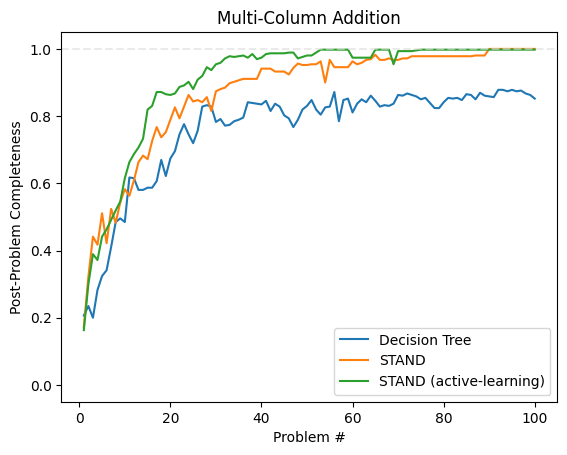

In [11]:
plot_cmp({"Decision Tree" : log_dt, "STAND": log_stand, "STAND (active-learning)" : log_stand_active, }, "Multi-Column Addition")